In [1]:
# %%
# Cell 1: Imports & Setup
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from scipy import stats
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

# Configuration
SAVE_DIR = "Saved_files_new"
plt.style.use('default')
sns.set_palette("husl")

print(f"Visualization setup complete. Using save directory: {SAVE_DIR}")


Visualization setup complete. Using save directory: Saved_files_new


## Data Loading Functions


In [19]:
# %%
# Cell 2: Enhanced Data Loading Functions with Topic-Specific N-grams
def try_read_csv(file_path, sep_choices=(';', ',')):
    """Try to read CSV with different separators for robustness."""
    for sep in sep_choices:
        try:
            df = pd.read_csv(file_path, sep=sep, encoding='utf-8')
            if len(df.columns) == 1 and ',' in df.columns[0]:
                continue
            return df
        except Exception:
            continue
    raise ValueError(f"Could not load {file_path} with any separator.")

def load_complete_analysis_data(date_string, save_dir="Saved_files_new"):
    """
    Load analyzed DataFrame with enhanced file pattern matching.
    Matches the actual file naming convention from the method detection pipeline.
    Now includes topic-specific n-grams loading.
    """
    print(f"Loading complete analysis data for {date_string}...")
    print(f"Searching in directory: {save_dir}")
    
    if not os.path.exists(save_dir):
        print(f"❌ Directory {save_dir} does not exist!")
        return None
    
    try:
        # Primary file patterns (matching refactored method detection pipeline)
        possible_files = [
            f"enhanced_method_analysis_{date_string}.csv",
            f"semantic_scholar_{date_string}_all_results.csv",
            f"semantic_scholar_{date_string}_enhanced_analysis.csv",
            f"semantic_scholar_{date_string}_results.csv",
            f"{date_string}_enhanced_analysis.csv",
            f"{date_string}_results.csv"
        ]
        
        df_filename = None
        print("  Checking for main analysis file...")
        for base in possible_files:
            potential_path = os.path.join(save_dir, base)
            if os.path.exists(potential_path):
                df_filename = potential_path
                print(f"  ✅ Found: {base}")
                break
            else:
                print(f"  ❌ Not found: {base}")
        
        if df_filename is None:
            print(f"\n📁 Available CSV files in {save_dir}:")
            csv_files = [f for f in os.listdir(save_dir) if f.endswith('.csv')]
            for f in sorted(csv_files):
                print(f"    📄 {f}")
            raise FileNotFoundError(f"No analyzed CSV file found for {date_string}")
        
        # Load main DataFrame
        df_analyzed = try_read_csv(df_filename)
        print(f"  ✅ Loaded DataFrame: {df_analyzed.shape}")
        print(f"  📊 Columns: {list(df_analyzed.columns)}")
        
        # Load topic metadata
        topic_keywords = topic_names = method_groups = None
        
        topic_file_patterns = [
            f"topics_{date_string}.json",
            f"topic_names_{date_string}.json", 
            f"semantic_scholar_{date_string}_topic_names.json",
            f"method_variant_groups_{date_string}.json",
            f"{date_string}_topics.json",
            f"{date_string}_topic_names.json"
        ]
        
        print("  Checking for topic metadata...")
        for pattern in topic_file_patterns:
            topic_path = os.path.join(save_dir, pattern)
            if os.path.exists(topic_path):
                print(f"  ✅ Found topic file: {pattern}")
                try:
                    with open(topic_path, 'r', encoding='utf-8') as f:
                        topic_data = json.load(f)
                        
                    if isinstance(topic_data, dict):
                        if 'topics' in topic_data:
                            topic_keywords = topic_data['topics']
                            topic_names = topic_data.get('topic_names', None)
                        elif 'topic_names' in topic_data:
                            topic_names = topic_data['topic_names']
                        else:
                            # Assume it's directly topic names or method groups
                            if any('topic' in str(k).lower() for k in topic_data.keys()):
                                topic_names = topic_data
                            else:
                                method_groups = topic_data
                    break
                except Exception as e:
                    print(f"    ⚠️  Error loading {pattern}: {e}")
                    continue
        
        # Try to load term frequencies
        term_freq_patterns = [
            f"term_frequencies_{date_string}.json",
            f"{date_string}_term_frequencies.json",
            "term_frequencies.json"
        ]
        
        term_frequencies_file = None
        for pattern in term_freq_patterns:
            freq_path = os.path.join(save_dir, pattern)
            if os.path.exists(freq_path):
                term_frequencies_file = pattern
                print(f"  ✅ Found term frequencies: {pattern}")
                break
        
        if not term_frequencies_file:
            print("  ⚠️  No term frequencies file found")
        
        # ADDED: Try to load topic-specific TF-IDF n-grams
        topic_ngram_patterns = [
            f"topic_specific_tfidf_ngrams_{date_string}.json",
            f"topic_tfidf_ngrams_{date_string}.json",
            f"{date_string}_topic_ngrams.json",
            f"topic_ngrams_{date_string}.json",
            f"semantic_scholar_{date_string}_topic_ngrams.json"
        ]
        
        topic_specific_tfidf_ngrams = None
        print("  Checking for topic-specific n-grams...")
        for pattern in topic_ngram_patterns:
            ngram_path = os.path.join(save_dir, pattern)
            if os.path.exists(ngram_path):
                print(f"  ✅ Found topic n-grams: {pattern}")
                try:
                    with open(ngram_path, 'r', encoding='utf-8') as f:
                        topic_specific_tfidf_ngrams = json.load(f)
                    print(f"    📊 Loaded n-grams for {len(topic_specific_tfidf_ngrams)} topics")
                    break
                except Exception as e:
                    print(f"    ⚠️  Error loading {pattern}: {e}")
                    continue
        
        if not topic_specific_tfidf_ngrams:
            print("  ⚠️  No topic-specific n-grams found")
        
        result = {
            'df_analyzed': df_analyzed,
            'topic_names': topic_names,
            'topic_keywords': topic_keywords,
            'method_groups': method_groups,
            'term_frequencies_file': term_frequencies_file,
            'topic_specific_tfidf_ngrams': topic_specific_tfidf_ngrams,
        }
        
        print(f"✅ Successfully loaded analysis data!")
        return result
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# %%
# Helper Function: Access Topic-Specific N-grams
def get_topic_ngrams(topic_id, ngram_type='keywords', top_n=10, topic_specific_tfidf_ngrams=None):
    """
    Get top n-grams for a specific topic.
    
    Parameters:
    - topic_id: Topic identifier (int or str)
    - ngram_type: Type of n-grams ('keywords', 'bigrams', 'trigrams')
    - top_n: Number of top n-grams to return
    - topic_specific_tfidf_ngrams: The loaded n-grams data
    
    Returns:
    - List of tuples (term, score) or None if not found
    """
    if not topic_specific_tfidf_ngrams:
        print("❌ No topic-specific n-grams data available")
        return None
    
    topic_key = str(topic_id)
    if topic_key not in topic_specific_tfidf_ngrams:
        print(f"❌ Topic {topic_id} not found in n-grams data")
        return None
    
    topic_data = topic_specific_tfidf_ngrams[topic_key]
    if ngram_type not in topic_data:
        print(f"❌ N-gram type '{ngram_type}' not found for topic {topic_id}")
        print(f"Available types: {list(topic_data.keys())}")
        return None
    
    ngrams = topic_data[ngram_type]
    if isinstance(ngrams, dict):
        # Sort by score (assuming scores are values)
        sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True)
        return sorted_ngrams[:top_n]
    else:
        print(f"❌ Unexpected n-grams format for topic {topic_id}")
        return None




## Plotting functions

### Global N-gram Frequency Plot

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_publication_trend(df, start_year=None, end_year=None, min_citations=0, figsize=(14, 8)):
    """
    Enhanced publication trend plotting with statistics about temporal distribution.
    
    Parameters:
    - df: DataFrame with publication data
    - start_year: Filter start year (None = no filter)
    - end_year: Filter end year (None = no filter)
    - min_citations: Minimum citation count filter
    - figsize: Figure dimensions
    """
    # Apply filtering
    df_filtered = df.copy()
    
    if start_year is not None:
        df_filtered = df_filtered[df_filtered['year'] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered['year'] <= end_year]
    
    if min_citations > 0 and 'citationCount' in df_filtered.columns:
        df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
    
    # Calculate and print statistics
    total_papers = len(df_filtered)
    
    # Year 2000 statistics
    before_2000 = len(df_filtered[df_filtered['year'] < 2000])
    after_2000 = len(df_filtered[df_filtered['year'] >= 2000])
    pct_before_2000 = (before_2000 / total_papers) * 100 if total_papers > 0 else 0
    pct_after_2000 = (after_2000 / total_papers) * 100 if total_papers > 0 else 0
    
    # Year 2010 statistics
    before_2010 = len(df_filtered[df_filtered['year'] < 2010])
    after_2010 = len(df_filtered[df_filtered['year'] >= 2010])
    pct_before_2010 = (before_2010 / total_papers) * 100 if total_papers > 0 else 0
    pct_after_2010 = (after_2010 / total_papers) * 100 if total_papers > 0 else 0
    
    # Print statistics
    print("\n" + "="*60)
    print("PUBLICATION STATISTICS")
    print("="*60)
    print(f"📊 Total papers: {total_papers:,}")
    print("\n--- Year 2000 Benchmark ---")
    print(f"Before 2000: {before_2000:,} papers ({pct_before_2000:.1f}%)")
    print(f"After 2000:  {after_2000:,} papers ({pct_after_2000:.1f}%)")
    print("\n--- Year 2010 Benchmark ---")
    print(f"Before 2010: {before_2010:,} papers ({pct_before_2010:.1f}%)")
    print(f"After 2010:  {after_2010:,} papers ({pct_after_2010:.1f}%)")
    print("="*60 + "\n")
    
    # Count publications per year
    year_counts = df_filtered.groupby('year').size().reset_index(name='count')
    
    # Create figure with matching size
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot with marker and thicker line to match topic trends style
    ax.plot(year_counts['year'], year_counts['count'], 
            marker='o', linewidth=2, color='#1f77b4')
    
    # Build title with filter information
    title_parts = ['Publication Trends Over Time']
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations > 0:
        filter_parts.append(f"Min citations: {min_citations}")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    # Set title with bold font weight
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    
    # Set axis labels
    ax.set_ylabel('Number of Papers')
    ax.set_xlabel('Year')
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    # Add grid with matching transparency
    ax.grid(True, alpha=0.3)
    
    # Apply tight layout
    plt.tight_layout()
    fig.savefig("output/publication_trend.pdf")
    plt.show()
    
    return year_counts


In [3]:
# %%
# Cell 3: Global N-gram Frequency Plot
def plot_term_frequencies(filename, n_terms=15, save=False, save_dir=SAVE_DIR):
    """
    Enhanced term frequency plotting with better error handling.
    """
    if not filename:
        print("❌ No term frequencies filename provided")
        return
        
    file_prefix = filename.replace('.json', '')
    
    possible_paths = [
        os.path.join(save_dir, filename),
        os.path.join(save_dir, f"{filename}.json") if not filename.endswith('.json') else os.path.join(save_dir, filename)
    ]
    
    filepath = None
    for path in possible_paths:
        if os.path.exists(path):
            filepath = path
            break
    
    if filepath is None:
        print(f"❌ Could not find term frequencies file: {filename}")
        json_files = [f for f in os.listdir(save_dir) if f.endswith('.json')]
        print(f"📁 Available JSON files:")
        for f in sorted(json_files):
            print(f"    📄 {f}")
        return
    
    print(f"📈 Loading term frequencies from: {os.path.basename(filepath)}")
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            frequencies = json.load(f)
    except Exception as e:
        print(f"❌ Error loading frequencies: {e}")
        return
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    
    categories = ['keywords', 'bigrams', 'trigrams']
    titles = [f"Top {n_terms} Keywords", f"Top {n_terms} Bigrams", f"Top {n_terms} Trigrams"]
    colors = ['steelblue', 'darkgreen', 'darkred']
    
    for ax, cat, title, color in zip([ax1, ax2, ax3], categories, titles, colors):
        freq_dict = frequencies.get(cat, {})
        if not freq_dict:
            ax.text(0.5, 0.5, f'No {cat} data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title)
            continue
            
        top_terms = list(freq_dict.keys())[:n_terms]
        top_freqs = [freq_dict[t] for t in top_terms]
        
        bars = ax.barh(top_terms[::-1], top_freqs[::-1], color=color, alpha=0.7)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel("Number of Occurrences in Corpus")
        ax.invert_yaxis()
        
        # Add value labels on bars
        for bar, freq in zip(bars, top_freqs[::-1]):
            width = bar.get_width()
            ax.text(width + 0.01 * max(top_freqs), bar.get_y() + bar.get_height()/2, 
                   str(freq), ha='left', va='center', fontsize=9)
        
        for label in ax.get_yticklabels(): 
            label.set_fontsize(10)
    
    plt.suptitle("Global Term Frequency Analysis", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save:
        output_file = os.path.join(save_dir, f"{file_prefix}_plots.pdf")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"💾 Plot saved as: {output_file}")
    
    plt.show()


### Per-Topic N-gram Frequency Plot

In [4]:
# %%
# Cell 4: Per-Topic N-gram Frequency Plot
def plot_top_terms_for_topic(df, topic_idx, topic_name=None, text_col='processed_text',
                            n_keywords=10, n_bigrams=10, n_trigrams=10, save=False, 
                            prefix='', save_dir=SAVE_DIR):
    """
    Enhanced per-topic term frequency plotting.
    """
    if 'Primary_Topic_Index' in df.columns:
        topic_df = df[df['Primary_Topic_Index'] == topic_idx]
    elif 'Primary_Topic' in df.columns:
        topic_df = df[df['Primary_Topic'] == topic_idx]
    else:
        print("❌ No topic column found in DataFrame")
        return
    
    if topic_df.empty:
        print(f"❌ No documents found for topic {topic_idx}")
        return
    
    print(f"📊 Analyzing {len(topic_df)} documents for topic {topic_idx}")
    
    text_list = topic_df[text_col].fillna('').astype(str).tolist()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    
    topic_display_name = topic_name or f"Topic {topic_idx}"
    titles = [
        f"Top {n_keywords} Keywords",
        f"Top {n_bigrams} Bigrams", 
        f"Top {n_trigrams} Trigrams"
    ]
    
    colors = ['steelblue', 'darkgreen', 'darkred']
    ngram_configs = [(1,1), (2,2), (3,3)]
    n_tops = [n_keywords, n_bigrams, n_trigrams]
    
    for (ngram, ax, title, color, n_top) in zip(ngram_configs, [ax1, ax2, ax3], titles, colors, n_tops):
        try:
            vec = CountVectorizer(ngram_range=ngram, stop_words='english', max_features=1000)
            mat = vec.fit_transform(text_list)
            terms = vec.get_feature_names_out()
            freqs = mat.sum(axis=0).A1
            
            top_idx = freqs.argsort()[::-1][:n_top]
            top_terms = [terms[i] for i in top_idx]
            top_freqs = [int(freqs[i]) for i in top_idx]
            
            bars = ax.barh(top_terms[::-1], top_freqs[::-1], color=color, alpha=0.7)
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel("Number of Occurrences (in Topic)")
            ax.invert_yaxis()
            
            # Add value labels
            for bar, freq in zip(bars, top_freqs[::-1]):
                width = bar.get_width()
                ax.text(width + 0.01 * max(top_freqs), bar.get_y() + bar.get_height()/2,
                       str(freq), ha='left', va='center', fontsize=9)
                       
            for label in ax.get_yticklabels(): 
                label.set_fontsize(10)
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)[:50]}...', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title, fontweight='bold')
    
    plt.suptitle(f'Term Analysis for {topic_display_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save:
        safe_name = str(topic_display_name).replace(' ', '_').replace('/', '_').replace('\\', '_')
        fig_name = f"{prefix}topic_{topic_idx}_{safe_name}_termfrequencies.pdf"
        fig_path = os.path.join(save_dir, fig_name)
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"💾 Per-topic plot saved as: {fig_path}")
    
    plt.show()


###  Method Importance Barplot

In [5]:
# %%
# Cell 5: Method Importance Barplot
def plot_method_importance(df, method_col='Primary_Method', min_count=2, include_low_conf=False,
                          figsize=(14, 8), max_methods=20):
    """
    Enhanced method importance plotting with better formatting.
    """
    if method_col not in df.columns:
        print(f"❌ Column '{method_col}' not found in DataFrame")
        print(f"📊 Available columns: {list(df.columns)}")
        return
    
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    
    # Filter by confidence if column exists and include_low_conf is False
    if conf_col and not include_low_conf:
        df_use = df[~df[conf_col].str.lower().str.contains('low', na=False)]
        conf_info = f" (excluding low confidence)"
    else:
        df_use = df
        conf_info = ""
    
    # Get method counts
    method_counts = df_use[method_col].value_counts()
    method_counts = method_counts[method_counts >= min_count]
    method_counts = method_counts.head(max_methods)  # Limit display
    
    if method_counts.empty:
        print(f"❌ No methods found with min_count >= {min_count}")
        return
    
    print(f"📊 Plotting {len(method_counts)} methods{conf_info}")
    
    plt.figure(figsize=figsize)
    bars = plt.bar(range(len(method_counts)), method_counts.values, 
                   color='mediumseagreen', alpha=0.7, edgecolor='darkgreen')
    
    plt.xticks(range(len(method_counts)), method_counts.index, 
               rotation=45, ha='right', fontsize=10)
    plt.ylabel('Number of Papers', fontsize=12)
    plt.title(f'Method Importance (Papers per Method){conf_info}', 
              fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, method_counts.values)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{int(count)}', ha='center', va='bottom', fontsize=9)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return method_counts


### Topic Importance Barplot

In [6]:
# %%
# Cell 6: Topic Importance Barplot
def get_topic_name(topic_idx, topic_names):
    """Helper function to get topic name with fallback."""
    if not topic_names:
        return f"Topic {topic_idx}"
    return topic_names.get(str(topic_idx), f"{topic_idx}")

def plot_topic_importance_with_names(df, topic_names=None, figsize=(12, 10), 
                                     max_topics=15, save_path=None):
    """
    Enhanced topic importance plotting with horizontal bars and PDF saving.
    
    Parameters:
    - df: DataFrame with topic column
    - topic_names: Dictionary mapping topic IDs to names
    - figsize: Figure size (width, height)
    - max_topics: Maximum number of topics to display
    - save_path: Path to save PDF (e.g., 'output/topics.pdf'). If None, no save.
    """
    # Determine topic column
    topic_col = None
    if 'Primary_Topic' in df.columns:
        topic_col = 'Primary_Topic'
    elif 'Primary_Topic_Index' in df.columns:
        topic_col = 'Primary_Topic_Index'
    else:
        print("❌ No topic column found in DataFrame!")
        print(f"📊 Available columns: {list(df.columns)}")
        return
    
    topic_counts = df[topic_col].value_counts().head(max_topics)
    
    if topic_counts.empty:
        print("❌ No topics found in DataFrame")
        return
    
    print(f"📊 Plotting {len(topic_counts)} topics")
    
    # Sort for better visualization (largest at top)
    topic_counts = topic_counts.sort_values(ascending=True)  # Smallest at bottom
    
    fig, ax = plt.subplots(figsize=figsize)  # Changed to use fig, ax for saving
    
    # Horizontal bars
    bars = ax.barh(range(len(topic_counts)), topic_counts.values, 
                   color='lightcoral', alpha=0.7, edgecolor='darkred')
    
    # Create topic labels
    topic_labels = [get_topic_name(t, topic_names) for t in topic_counts.index]
    
    # Set labels
    ax.set_yticks(range(len(topic_counts)))
    ax.set_yticklabels(topic_labels, fontsize=14)
    
    ax.set_title('Topic Importance (Number of Papers per Topic)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Papers', fontsize=14)
    ax.set_ylabel('Topics', fontsize=14)
    
    # Add value labels at end of bars
    for i, (bar, count) in enumerate(zip(bars, topic_counts.values)):
        ax.text(bar.get_width() + max(topic_counts.values)*0.01,  # 1% offset
                bar.get_y() + bar.get_height()/2,
                str(count), 
                ha='left', va='center', fontsize=14, fontweight='bold')
    
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    # Save as PDF if path provided
    if save_path:
        from pathlib import Path
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        
        # Ensure .pdf extension
        if not str(save_path).endswith('.pdf'):
            save_path = str(save_path) + '.pdf'
        
        fig.savefig(save_path, bbox_inches='tight', format='pdf')
        print(f"💾 Saved: {save_path}")
    
    plt.show()
    
    return topic_counts




###  Method Trends Over Time

In [7]:
# %%
# Cell 7: Enhanced Method Trends Over Time - With Citation/Venue Filtering and Proper Fraction Calculation
def plot_method_trends_over_time(df, method_col='Primary_Method', year_col='year', 
                               methods=None, include_low_conf=False, min_count=2, 
                               min_papers_per_year=20,top_n=10, window_smooth=1, figsize=(14, 8),
                               plot_type='line', value_type='fraction', start_year=None, 
                               end_year=None, min_citations=None, venues=None):
    """
    Enhanced method trends plotting with citation/venue filtering and proper fraction calculation.
    
    Parameters:
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    """
    if method_col not in df.columns:
        print(f"❌ Column '{method_col}' not found in DataFrame")
        return
    
    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    # Start with copy of dataframe
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Remove papers without assigned methods (for fraction calculation base)
    df_filtered = df_filtered[df_filtered[method_col].notna() & (df_filtered[method_col] != '')]
    
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df_filtered.columns else None
    
    # Filter by confidence
    if conf_col and not include_low_conf:
        df_use = df_filtered[~df_filtered[conf_col].str.lower().str.contains('low', na=False)]
    else:
        df_use = df_filtered
    
    # Filter by methods
    if methods is not None:
        if isinstance(methods, str): 
            methods = [methods]
        df_use = df_use[df_use[method_col].isin(methods)]
        label = f"Methods: {', '.join(methods)}"
    else:
        value_counts = df_use[method_col].value_counts()
        methods = value_counts[value_counts >= min_count].head(top_n).index.tolist()
        label = f"Top {len(methods)} Methods"
        df_use = df_use[df_use[method_col].isin(methods)]
    
    if df_use.empty:
        print("❌ No matching method assignments to plot.")
        return
    
    print(f"📈 Plotting trends for: {label}")
    print(f"📊 Papers after all filtering: {len(df_use)}")
    
    # Calculate trends -Use df_filtered (all papers) for total counts
    year_method_counts = df_use.groupby([year_col, method_col]).size().reset_index(name='count')
    year_totals = df_filtered.groupby(year_col).size().reset_index(name='total_count')  # All papers, not just selected methods
    
    # Apply minimum papers per year filter
    valid_years = year_totals[year_totals['total_count'] >= min_papers_per_year]
    print(f"📅 Years with ≥{min_papers_per_year} papers: {len(valid_years)}")
    
    merged = pd.merge(year_method_counts, valid_years, on=year_col)
    
    #Calculate values based on value_type against ALL papers
    if value_type.lower() == 'count':
        merged['value'] = merged['count']
        ylabel = 'Number of Papers'
    else:  # fraction
        merged['value'] = merged['count'] / merged['total_count']  # Fraction of ALL papers
        ylabel = 'Fraction of All Papers'
    
    if window_smooth > 1:
        merged = merged.sort_values([method_col, year_col])
        merged['value'] = merged.groupby(method_col)['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = merged.pivot(index=year_col, columns=method_col, values='value').fillna(0)
        
        # FIXED: Don't normalize again for fractions - they're already fractions of total
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions of all papers
            ylabel = 'Fraction of All Papers'
        else:
            # For counts, show stacked absolute values
            pivot_norm = pivot
            ylabel = 'Number of Papers'
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, method_name in enumerate(pivot_norm.columns):
            y_values = pivot_norm[method_name].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, method_name, 
                   fontsize=9, va='center', ha='left', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        plot_data = merged.copy()
        plot_data[method_col] = plot_data[method_col].astype(str)
        all_methods = sorted(plot_data[method_col].unique())
        
        sns.lineplot(data=plot_data, x=year_col, y='value', hue=method_col, 
                    marker='o', linewidth=2, ax=ax, hue_order=all_methods, legend='full')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create title with filtering info
    title_parts = [f'Method Usage Trends Over Time ({value_type.capitalize()})']
    title_parts.append(f'{label}')
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return merged


### Topic Trends Over Time

In [8]:
# %%
# Cell 8: Enhanced Topic Trends Over Time - With Focus/Background Topic Distinction
def plot_topic_trends_over_time(df, topic_col=None, year_col='year', topics=None, 
                               top_n=10, min_papers_per_year=20, window_smooth=1, 
                               topic_names=None, figsize=(14, 8), plot_type='line',
                               start_year=None, end_year=None, value_type='fraction',
                               min_citations=None, venues=None, focus_topics=None):
    """
    Enhanced topic trends plotting with focus/non-focus distinction.
    
    Parameters:
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    - focus_topics: List of topic IDs to emphasize (None = all topics equal emphasis)
    """
    # Auto-detect topic column
    if topic_col is None:
        if 'Primary_Topic_Index' in df.columns:
            topic_col = 'Primary_Topic_Index'
        elif 'Primary_Topic' in df.columns:
            topic_col = 'Primary_Topic'
        else:
            print("❌ No topic column found!")
            return
    
    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    # Start with copy of dataframe
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Remove papers without assigned topics (for fraction calculation base)
    df_filtered = df_filtered[df_filtered[topic_col].notna() & (df_filtered[topic_col] != '')]
    
    print(f"📅 Year range: {df_filtered[year_col].min()} - {df_filtered[year_col].max()}")
    
    # Filter by topics
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_use = df_filtered[df_filtered[topic_col].isin(topics)]
        label = ", ".join([get_topic_name(t, topic_names) for t in topics])
    else:
        topic_counts = df_filtered[topic_col].value_counts().nlargest(top_n)
        topics = topic_counts.index.tolist()
        label = f"Top {top_n} Topics"
        df_use = df_filtered[df_filtered[topic_col].isin(topics)]
    
    if df_use.empty:
        print("❌ No matching topics to plot.")
        return
    
    print(f"📈 Plotting trends for: {label}")
    print(f"📊 Papers after all filtering: {len(df_use)}")
    
    # Calculate trends
    year_topic_counts = df_use.groupby([year_col, topic_col]).size().reset_index(name='count')
    year_totals = df_filtered.groupby(year_col).size().reset_index(name='total_count')
    
    # Apply minimum papers per year filter
    valid_years = year_totals[year_totals['total_count'] >= min_papers_per_year]
    print(f"📅 Years with ≥{min_papers_per_year} papers: {len(valid_years)}")
    
    if len(valid_years) == 0:
        max_papers = year_totals['total_count'].max()
        min_papers_per_year = max(1, max_papers // 4)
        print(f"🔧 Auto-adjusting threshold to {min_papers_per_year}")
        valid_years = year_totals[year_totals['total_count'] >= min_papers_per_year]
    
    merged = pd.merge(year_topic_counts, valid_years, on=year_col)
    
    # Calculate values based on value_type
    if value_type.lower() == 'count':
        merged['value'] = merged['count']
        ylabel = 'Number of Papers'
    else:  # fraction
        merged['value'] = merged['count'] / merged['total_count']
        ylabel = 'Fraction of All Papers'
    
    if window_smooth > 1:
        merged = merged.sort_values([topic_col, year_col])
        merged['value'] = merged.groupby(topic_col)['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define line styles and markers for distinction
    focus_linestyles = ['-', '-', '-', '-', '-']  # Solid for focused
    nonfocus_linestyles = ['--', '-.', ':']  # Varied dashed for non-focused
    
    focus_markers = ['o', 's', '^', 'D', 'v']  # Distinct markers for focused
    nonfocus_markers = ['o', 's', '^']  # Same markers but will be less visible
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = merged.pivot(index=year_col, columns=topic_col, values='value').fillna(0)
        
        if value_type.lower() == 'fraction':
            pivot_norm = pivot
            ylabel = 'Fraction of All Papers'
        else:
            pivot_norm = pivot
            ylabel = 'Number of Papers'
        
        # Create topic labels for columns
        if topic_names:
            column_labels = [get_topic_name(col, topic_names) for col in pivot_norm.columns]
            pivot_norm.columns = column_labels
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, topic_name in enumerate(pivot_norm.columns):
            y_values = pivot_norm[topic_name].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, topic_name, 
                   fontsize=9, va='center', ha='left', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot with focus/non-focus distinction
        plot_data = merged.copy()
        plot_data[topic_col] = plot_data[topic_col].astype(str)
        all_topics = sorted(plot_data[topic_col].unique())
        
        # Separate focused and non-focused topics
        if focus_topics is not None:
            focus_topics_str = [str(t) for t in focus_topics]
            focused = [t for t in all_topics if t in focus_topics_str]
            nonfocused = [t for t in all_topics if t not in focus_topics_str]
        else:
            focused = all_topics
            nonfocused = []
        
        print(f"📌 Focused topics: {len(focused)}, Background topics: {len(nonfocused)}")
        
        # Plot non-focused topics first (in background)
        for idx, topic in enumerate(nonfocused):
            topic_data = plot_data[plot_data[topic_col] == topic]
            linestyle = nonfocus_linestyles[idx % len(nonfocus_linestyles)]
            marker = nonfocus_markers[idx % len(nonfocus_markers)]
            
            topic_name = get_topic_name(int(topic), topic_names) if topic_names else topic
            
            ax.plot(topic_data[year_col], topic_data['value'],
                   linestyle=linestyle, marker=marker, linewidth=1.5,
                   alpha=0.3, markersize=4, markevery=2,
                   label=topic_name, color='gray')
        
        # Plot focused topics (in foreground)
        for idx, topic in enumerate(focused):
            topic_data = plot_data[plot_data[topic_col] == topic]
            linestyle = focus_linestyles[idx % len(focus_linestyles)]
            marker = focus_markers[idx % len(focus_markers)]
            
            topic_name = get_topic_name(int(topic), topic_names) if topic_names else topic
            
            ax.plot(topic_data[year_col], topic_data['value'],
                   linestyle=linestyle, marker=marker, linewidth=2.5,
                   alpha=1.0, markersize=6,
                   label=topic_name)
        
        # Create custom legend with focused topics first
        handles, labels = ax.get_legend_handles_labels()
        
        # Reorder so focused topics appear first
        if focus_topics is not None and len(nonfocused) > 0:
            # Add separator
            ax.legend(handles=handles, labels=labels,
                     bbox_to_anchor=(1.05, 1), loc='upper left', 
                     #title='Topics\n━━━━━━━━\nFocused\n' + '―' * 8 + f'\nBackground ({len(nonfocused)})',
                     frameon=True)
        else:
            ax.legend(handles=handles, labels=labels,
                     bbox_to_anchor=(1.05, 1), loc='upper left', 
                     title='Topics', frameon=True)
    
    # Create title with filtering info
    title_parts = [f'Topic Trends Over Time ({value_type.capitalize()})']
    title_parts.append(f'{label}')
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    fig.savefig("output/topic_trends_focus.pdf")
    plt.show()
    
    return merged




### Topic-Method Correlation Heatmap

In [9]:
# %%
# Cell 9: Topic-Method Correlation Heatmap
def plot_topic_method_heatmap(df, topic_col=None, method_col='Primary_Method',
                             top_n_methods=8, top_n_topics=8, include_low_conf=False,
                             figsize=(12, 8)):
    """
    Enhanced topic-method correlation heatmap.
    """
    # Auto-detect topic column
    if topic_col is None:
        if 'Primary_Topic' in df.columns:
            topic_col = 'Primary_Topic'
        elif 'Primary_Topic_Index' in df.columns:
            topic_col = 'Primary_Topic_Index'
        else:
            print("❌ No topic column found!")
            return
    
    if method_col not in df.columns:
        print(f"❌ Column '{method_col}' not found in DataFrame")
        return
    
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    
    # Filter by confidence
    if conf_col and not include_low_conf:
        df_use = df[~df[conf_col].str.lower().str.contains('low', na=False)]
    else:
        df_use = df
    
    # Get top methods and topics
    top_methods = df_use[method_col].value_counts().head(top_n_methods).index
    top_topics = df_use[topic_col].value_counts().head(top_n_topics).index
    
    df_corr = df_use[df_use[method_col].isin(top_methods) & df_use[topic_col].isin(top_topics)]
    
    if df_corr.empty:
        print("❌ No sufficient data for topic-method correlation heatmap.")
        return
    
    print(f"📊 Creating heatmap for {len(top_topics)} topics and {len(top_methods)} methods")
    
    # Create pivot table
    pivot = df_corr.pivot_table(index=topic_col, columns=method_col, aggfunc='size', fill_value=0)
    
    plt.figure(figsize=figsize)
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='d', cbar_kws={'label': 'Number of Papers'})
    plt.title("Topic-Method Co-Occurrence Matrix", fontweight='bold', fontsize=14)
    plt.ylabel("Topic", fontsize=12)
    plt.xlabel("Method", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return pivot


### Weighted Method Importance

In [10]:

# %%
# Cell 10: Enhanced Score-Weighted Method Importance with Filtering

def plot_weighted_method_importance_filtered(df,
                                            n_top=5,
                                            plot_top_k=None,
                                            method_label_prefix="Method_",
                                            weighting_method='score',     # 'score' or 'rank'
                                            # Topic Filtering by Number
                                            topic_numbers=None,
                                            topic_names=None,  
                                            min_citations=None,
                                            max_citations=None,
                                            venues_include=None,
                                            venues_exclude=None,
                                            min_year=None,
                                            max_year=None,
                                            # Visualization Parameters
                                            figsize=(14, 8),
                                            save_dir=None,
                                            show_filter_info=True):
    """
    Enhanced weighted method importance with score-based weighting and comprehensive filtering.
    
    Parameters:
    -----------
    weighting_method : str, default 'score'
        'score': Use actual confidence scores from Method_X_Score columns
        'rank': Use rank-based points (original behavior)
    topic_numbers : int or list of int, optional
        Filter by specific topic number(s). Single topic index or list of indices.
    topic_names : dict or callable, optional
        Dictionary mapping topic numbers to names, or a function that takes topic number and returns name.
        Example: {0: "Machine Learning", 1: "Optimization"}
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with methods and their weighted scores
    """
    
    print("🔍 Starting Enhanced Method Importance Analysis with Score-based Weighting...")
    
    # =================================================================
    # HELPER FUNCTION: Get Topic Name from Number
    # =================================================================
    def get_topic_name(topic_num, topic_names_dict):
        """Get topic name from number, with fallback. Handles both int and string keys."""
        if topic_names_dict is None:
            return f"Topic {topic_num}"
        
        if callable(topic_names_dict):
            # If it's a function, call it
            return topic_names_dict(topic_num)
        elif isinstance(topic_names_dict, dict):
            # Try both integer and string keys (FIXED)
            name = topic_names_dict.get(topic_num, None)
            if name is None:
                # Try converting to string
                name = topic_names_dict.get(str(topic_num), None)
            if name is None:
                # Try converting to int
                try:
                    name = topic_names_dict.get(int(topic_num), None)
                except (ValueError, TypeError):
                    pass
            
            return name if name is not None else f"Topic {topic_num}"
        else:
            return f"Topic {topic_num}"
        
    def format_topic_names(topic_numbers, topic_names_dict):
        """Format topic numbers with their names."""
        if isinstance(topic_numbers, int):
            topic_numbers = [topic_numbers]
        
        if len(topic_numbers) == 1:
            return get_topic_name(topic_numbers[0], topic_names_dict)
        else:
            # For multiple topics, show compact format
            names = [get_topic_name(num, topic_names_dict) for num in topic_numbers]
            if len(names) <= 3:
                return ", ".join(names)
            else:
                # If too many, show first few and count
                return f"{', '.join(names[:2])}, and {len(names)-2} more"
    
    # =================================================================
    # STEP 1: Apply All Filters
    # =================================================================
    filtered_df = df.copy()
    original_count = len(filtered_df)
    filter_steps = []
    
    # Topic filtering by NUMBER (simplified)
    topic_names_str = None  # Store formatted topic names for title
    if topic_numbers is not None:
        topic_col = None
        # Look for numeric topic columns (flexible naming)
        for col in ['Primary_Topic_Index']:
            if col in filtered_df.columns:
                topic_col = col
                break
        
        if topic_col is not None:
            # Convert single number to list
            if isinstance(topic_numbers, int):
                topic_numbers = [topic_numbers]
            
            # Generate topic names string for display
            topic_names_str = format_topic_names(topic_numbers, topic_names)
            
            # Filter by numeric topic indices
            mask = filtered_df[topic_col].isin(topic_numbers)
            filtered_df = filtered_df[mask]
            filter_steps.append(f"Topic numbers ({topic_numbers}): {len(filtered_df)} papers")
            
            if show_filter_info:
                print(f"  🎯 Filtering by topics: {topic_names_str}")
                print(f"  📊 Found {len(filtered_df)} papers in selected topics")
        else:
            print("⚠️  Topic number filter requested but no numeric topic column found")
            print(f"     Available columns: {[col for col in filtered_df.columns if 'topic' in col.lower()]}")
    
    # Citation filtering
    if min_citations is not None or max_citations is not None:
        citation_col = None
        for col in ['citationCount', 'citation_count', 'citations']:
            if col in filtered_df.columns:
                citation_col = col
                break
        
        if citation_col is not None:
            if min_citations is not None:
                filtered_df = filtered_df[filtered_df[citation_col] >= min_citations]
                filter_steps.append(f"Min citations (≥{min_citations}): {len(filtered_df)} papers")
            
            if max_citations is not None:
                filtered_df = filtered_df[filtered_df[citation_col] <= max_citations]
                filter_steps.append(f"Max citations (≤{max_citations}): {len(filtered_df)} papers")
        else:
            print("⚠️  Citation filter requested but no citation column found")
    
    # Venue filtering
    if venues_include is not None or venues_exclude is not None:
        venue_col = None
        for col in ['venue', 'Venue', 'journal']:
            if col in filtered_df.columns:
                venue_col = col
                break
        
        if venue_col is not None:
            if venues_include is not None:
                mask = filtered_df[venue_col].str.lower().isin([v.lower() for v in venues_include])
                filtered_df = filtered_df[mask]
                filter_steps.append(f"Venues include ({len(venues_include)} venues): {len(filtered_df)} papers")
            
            if venues_exclude is not None:
                mask = ~filtered_df[venue_col].str.lower().isin([v.lower() for v in venues_exclude])
                filtered_df = filtered_df[mask]
                filter_steps.append(f"Venues exclude ({len(venues_exclude)} venues): {len(filtered_df)} papers")
        else:
            print("⚠️  Venue filter requested but no venue column found")
    
    # Year filtering
    if min_year is not None or max_year is not None:
        year_col = 'year'
        if filtered_df[year_col].dtype == 'object':
            filtered_df[year_col] = pd.to_numeric(filtered_df[year_col], errors='coerce')
        
        if min_year is not None:
            filtered_df = filtered_df[filtered_df[year_col] >= min_year]
            filter_steps.append(f"Min year (≥{min_year}): {len(filtered_df)} papers")
        
        if max_year is not None:
            filtered_df = filtered_df[filtered_df[year_col] <= max_year]
            filter_steps.append(f"Max year (≤{max_year}): {len(filtered_df)} papers")
    
    # Display filtering results
    if show_filter_info:
        print(f"\n📊 Filtering Results:")
        print(f"  Original papers: {original_count:,}")
        for step in filter_steps:
            print(f"  After {step}")
        print(f"  Final papers: {len(filtered_df):,} ({100*len(filtered_df)/original_count:.1f}% retained)")
    
    if len(filtered_df) == 0:
        print("❌ No papers remaining after filtering!")
        return None
    
    # =================================================================
    # STEP 2: Identify Method and Score Columns
    # =================================================================
    
    # Build method column names
    method_cols = []
    score_cols = []
    
    for i in range(1, n_top + 1):
        method_col = f"{method_label_prefix}{i}"
        score_col = f"{method_label_prefix}{i}_Score"
        
        if method_col in filtered_df.columns:
            method_cols.append(method_col)
            # Check if corresponding score column exists
            if score_col in filtered_df.columns:
                score_cols.append(score_col)
            else:
                score_cols.append(None)  # No score column available
    
    if not method_cols:
        print(f"❌ No method columns found with pattern '{method_label_prefix}*'")
        available_method_cols = [col for col in filtered_df.columns if 'method' in col.lower()]
        print(f"📊 Available method columns: {available_method_cols}")
        return None
    
    # Check for score columns if using score-based weighting
    if weighting_method == 'score':
        missing_score_cols = [i for i, col in enumerate(score_cols) if col is None]
        if missing_score_cols:
            print(f"⚠️  Score-based weighting requested but missing score columns for positions: {[i+1 for i in missing_score_cols]}")
            print(f"   Available score columns: {[col for col in filtered_df.columns if 'Score' in col]}")
            print("   Falling back to rank-based weighting")
            weighting_method = 'rank'
    
    print(f"📊 Using {weighting_method}-based weighting with columns: {method_cols}")
    
    # =================================================================
    # STEP 2.5: Count Papers with Methods Assigned
    # =================================================================
    
    papers_with_methods = 0
    for idx, row in filtered_df.iterrows():
        has_method = False
        for method_col in method_cols:
            method = row[method_col]
            if pd.notna(method) and str(method).strip() != "" and str(method).lower() not in ['nan', 'none', 'low', 'lowconfidence']:
                has_method = True
                break
        if has_method:
            papers_with_methods += 1
    
    papers_without_methods = len(filtered_df) - papers_with_methods
    
    if show_filter_info:
        print(f"\n📋 Method Assignment Status:")
        print(f"  Papers with methods: {papers_with_methods:,} ({100*papers_with_methods/len(filtered_df):.1f}%)")
        print(f"  Papers without methods: {papers_without_methods:,} ({100*papers_without_methods/len(filtered_df):.1f}%)")
    
    # =================================================================
    # STEP 3: Calculate Weighted Method Importance
    # =================================================================
    
    method_score_accumulator = {}
    total_papers_processed = 0
    total_scores_used = 0
    
    if weighting_method == 'score':
        print("📊 Using confidence score-based weighting...")
        
        for i, method_col in enumerate(method_cols):
            score_col = score_cols[i]
            
            for idx, row in filtered_df.iterrows():
                method = row[method_col]
                
                # Skip invalid methods
                if pd.isna(method) or method == "" or str(method).lower() in ['nan', 'none', 'low', 'lowconfidence']:
                    continue
                
                # Get confidence score
                if score_col is not None:
                    try:
                        confidence_score = float(row.get(score_col, 0))
                        if confidence_score <= 0:
                            continue
                    except (ValueError, TypeError):
                        continue
                else:
                    confidence_score = (len(method_cols) - i) / len(method_cols)
                
                method_score_accumulator[method] = method_score_accumulator.get(method, 0) + confidence_score
                total_scores_used += confidence_score
        
        total_papers_processed = papers_with_methods
    
    else:  # rank-based weighting
        print("📊 Using rank-based weighting...")
        points = np.arange(len(method_cols), 0, -1)
        
        for i, method_col in enumerate(method_cols):
            pts = points[i]
            method_counts = filtered_df[method_col].value_counts()
            
            for method, count in method_counts.items():
                if pd.isna(method) or method == "" or str(method).lower() in ['nan', 'none', 'low', 'lowconfidence']:
                    continue
                method_score_accumulator[method] = method_score_accumulator.get(method, 0) + pts * count
                total_scores_used += pts * count
        
        total_papers_processed = papers_with_methods
    
    if not method_score_accumulator:
        print("❌ No valid methods found for scoring")
        return None
    
    # Convert to DataFrame and sort
    result_df = pd.DataFrame(list(method_score_accumulator.items()),
                            columns=["Method", "Weighted_Score"])
    result_df = result_df.sort_values("Weighted_Score", ascending=False)
    
    # Limit display if requested
    if plot_top_k is not None:
        result_df = result_df.head(plot_top_k)
    
    print(f"📊 Plotting top {len(result_df)} methods")
    
    # =================================================================
    # STEP 4: Create Enhanced Visualization
    # =================================================================
    
    plt.figure(figsize=figsize)
    
    # Create bars with enhanced styling
    bars = plt.bar(range(len(result_df)), result_df["Weighted_Score"],
                   color="midnightblue", alpha=0.8, edgecolor='darkblue', linewidth=1.2)
    
    # Customize plot appearance
    plt.xticks(range(len(result_df)), result_df["Method"],
               rotation=45, ha='right', fontsize=10)
    
    # Title with topic names
    weighting_info = "Score-weighted" if weighting_method == 'score' else "Rank-weighted"
    title_parts = [f"{weighting_info} Method Importance\n"]
    
    # Add topic names if filtering by topics
    if topic_numbers is not None and topic_names_str is not None:
        title_parts.append(f"Filtered by topics: {topic_names_str}\n")
    
    # Add paper count information
    if papers_with_methods != original_count:
        title_parts.append(f"{papers_with_methods:,} papers with methods assigned within filter criteria")
        title_parts.append(f"({100*papers_with_methods/len(df):.1f}% of total corpus - {len(df):,} papers)")
    
    plt.title(" ".join(title_parts), fontsize=14, fontweight='bold')
    plt.xlabel("Method", fontsize=12)
    
    # Y-label depends on weighting method
    if weighting_method == 'score':
        plt.ylabel("Total Confidence Score", fontsize=12)
    else:
        plt.ylabel("Weighted Importance Score", fontsize=12)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, result_df["Weighted_Score"])):
        if i < 25:
            label_value = f'{score:.0f}' if weighting_method == 'score' else f'{int(score)}'
            plt.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + max(result_df["Weighted_Score"]) * 0.01,
                    label_value, ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Enhanced grid and styling
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save if requested
    if save_dir is not None:
        from datetime import datetime
        weighting_suffix = "score" if weighting_method == 'score' else "rank"
        topic_suffix = f"_topic_{topic_numbers}" if topic_numbers is not None else ""
        save_path = os.path.join(save_dir, f"method_importance_{weighting_suffix}{topic_suffix}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot to: {save_path}")
    
    plt.show()
    
    # =================================================================
    # STEP 5: Display Enhanced Summary Statistics
    # =================================================================
    
    print(f"\n📈 Summary Statistics ({weighting_method}-based):")
    print(f"  Total methods identified: {len(method_score_accumulator)}")
    print(f"  Methods displayed: {len(result_df)}")
    print(f"  Papers with methods: {total_papers_processed:,}")
    
    if weighting_method == 'score':
        print(f"  Score range: {result_df['Weighted_Score'].min():.3f} - {result_df['Weighted_Score'].max():.3f}")
        print(f"  Mean score: {result_df['Weighted_Score'].mean():.3f}")
        print(f"  Total confidence used: {total_scores_used:.2f}")
        print(f"  Average confidence per paper: {total_scores_used/total_papers_processed:.3f}")
        
        # Show confidence level distribution
        high_conf = (result_df['Weighted_Score'] > 1.0).sum()
        med_conf = ((result_df['Weighted_Score'] > 0.5) & (result_df['Weighted_Score'] <= 1.0)).sum()
        low_conf = (result_df['Weighted_Score'] <= 0.5).sum()
        print(f"  High confidence methods (>1.0): {high_conf}")
        print(f"  Medium confidence methods (0.5-1.0): {med_conf}")
        print(f"  Lower confidence methods (≤0.5): {low_conf}")
    else:
        print(f"  Score range: {result_df['Weighted_Score'].min():.0f} - {result_df['Weighted_Score'].max():.0f}")
        print(f"  Mean score: {result_df['Weighted_Score'].mean():.1f}")
        print(f"  Total points assigned: {total_scores_used:.0f}")
    
    return result_df



# =================================================================
# ENHANCED CONVENIENCE WRAPPER FUNCTIONS
# =================================================================

def plot_methods_by_topic_number(df, topic_number, weighting_method='score', **kwargs):
    """Convenience function to plot methods for a specific topic number with score weighting."""
    return plot_weighted_method_importance_filtered(df, 
                                                   topic_numbers=topic_number, 
                                                   weighting_method=weighting_method,
                                                   **kwargs)

def plot_methods_multiple_topics(df, topic_list, weighting_method='score', **kwargs):
    """Convenience function to plot methods for multiple topic numbers with score weighting."""
    return plot_weighted_method_importance_filtered(df, 
                                                   topic_numbers=topic_list,
                                                   weighting_method=weighting_method,
                                                   **kwargs)

def plot_methods_high_impact_by_topic(df, topic_number, min_citations=50, weighting_method='score', **kwargs):
    """Convenience function for high-impact papers in specific topic with score weighting."""
    return plot_weighted_method_importance_filtered(df, 
                                                   topic_numbers=topic_number, 
                                                   min_citations=min_citations,
                                                   weighting_method=weighting_method,
                                                   **kwargs)

def compare_weighting_methods(df, topic_numbers=None, **kwargs):
    """Compare score-based vs rank-based weighting side by side."""
    print("🔍 Comparing Weighting Methods...")
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Score-based plot
    plt.sca(ax1)
    result_score = plot_weighted_method_importance_filtered(df, 
                                                          topic_numbers=topic_numbers,
                                                          weighting_method='score',
                                                          show_filter_info=False,
                                                          **kwargs)
    ax1.set_title("Score-weighted Method Importance", fontweight='bold')
    
    # Rank-based plot  
    plt.sca(ax2)
    result_rank = plot_weighted_method_importance_filtered(df,
                                                         topic_numbers=topic_numbers,
                                                         weighting_method='rank',
                                                         show_filter_info=False,
                                                         **kwargs)
    ax2.set_title("Rank-weighted Method Importance", fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return result_score, result_rank


### Weighted Method Trends Over Time

In [11]:
# 
# Cell 11: Enhanced Score-Weighted Method Trends Over Time
"""Old version without GGT correction option
def plot_weighted_method_trends_over_time(df, n_top=5, methods=None, topics=None, 
                                        plot_top_k=None, year_col='year',
                                        method_label_prefix="Method_", 
                                        min_papers_per_year=20, window_smooth=1,
                                        topic_col='Primary_Topic_Index', topic_names=None,
                                        start_year=None, end_year=None, figsize=(14, 8),
                                        plot_type='line', value_type='fraction',
                                        min_citations=None, venues=None, log_scale=False,
                                        weighting_method='score'):  # NEW PARAMETER
    
    
    #Enhanced weighted method trends with score-based weighting and citation/venue filtering.
    #Parameters:
    #- weighting_method: 'score' (use actual confidence scores) or 'rank' (use rank-based points)
    #- value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    #- min_citations: Filter papers by minimum citation count (None = no filter)
    #- venues: List of venues to include (None = all venues)
    #- plot_type: 'line' or 'area'


    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None: 
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    # Apply topic filtering
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_filtered = df_filtered[df_filtered[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'
    
    # Identify method and score columns
    method_cols = []
    score_cols = []
    for i in range(1, n_top + 1):
        method_col = f"{method_label_prefix}{i}"
        score_col = f"{method_label_prefix}{i}_Score"
        
        if method_col in df_filtered.columns:
            method_cols.append(method_col)
            # Check if corresponding score column exists
            if score_col in df_filtered.columns:
                score_cols.append(score_col)
            else:
                score_cols.append(None)  # No score column available
    
    if not method_cols:
        print(f"❌ No method columns found with prefix '{method_label_prefix}'")
        return
    
    # Check for score columns if using score-based weighting
    if weighting_method == 'score':
        missing_score_cols = [i for i, col in enumerate(score_cols) if col is None]
        if missing_score_cols:
            print(f"⚠️  Score-based weighting requested but missing score columns for positions: {[i+1 for i in missing_score_cols]}")
            print(f"   Available columns: {[col for col in df_filtered.columns if 'Score' in col]}")
            print("   Falling back to rank-based weighting")
            weighting_method = 'rank'
    
    # Filter out papers with no methods assigned
    has_method_mask = df_filtered[method_cols].notna().any(axis=1)
    df_filtered = df_filtered[has_method_mask]
    
    if min_papers_per_year > 1:
        year_counts = df_filtered.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df_filtered = df_filtered[df_filtered[year_col].isin(valid_years)]
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Build records with appropriate weighting
    records = []
    
    if weighting_method == 'score':
        print(f"📊 Using score-based weighting (confidence scores)")
        
        for i, method_col in enumerate(method_cols):
            score_col = score_cols[i]
            
            for idx, row in df_filtered.iterrows():
                method = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.notna(method) and method != "" and pd.notna(year):
                    if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                        
                        # Get confidence score
                        if score_col is not None:
                            confidence_score = row.get(score_col, 0)
                            # Ensure score is numeric and positive
                            try:
                                confidence_score = float(confidence_score)
                                if confidence_score <= 0:
                                    continue  # Skip zero or negative scores
                            except (ValueError, TypeError):
                                continue  # Skip invalid scores
                        else:
                            # Fallback: assign decreasing weights if no score column
                            confidence_score = (len(method_cols) - i) / len(method_cols)
                        
                        records.append({
                            'year': year, 
                            'method': method, 
                            'points': confidence_score,
                            'source': 'score'
                        })
    
    else:  # rank-based weighting
        print(f"📊 Using rank-based weighting (positional points)")
        points = np.arange(len(method_cols), 0, -1)  # [n_top, n_top-1, ..., 1]
        
        for i, method_col in enumerate(method_cols):
            pts = points[i]
            
            for idx, row in df_filtered.iterrows():
                method = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.notna(method) and method != "" and pd.notna(year):
                    if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                        records.append({
                            'year': year, 
                            'method': method, 
                            'points': pts,
                            'source': 'rank'
                        })
    
    if not records:
        print("❌ No method records found")
        return
    
    trend_df = pd.DataFrame(records)
    agg = trend_df.groupby(['year', 'method'])['points'].sum().reset_index()
    
    # Calculate values based on weighting method and value type
    if value_type.lower() == 'count':
        if weighting_method == 'score':
            agg['value'] = agg['points']  # Use raw confidence scores
            ylabel = 'Total Confidence Score'
        else:
            agg['value'] = agg['points'] / n_top  # Normalize by max points per paper
            ylabel = 'Weighted Points'
    else:  # fraction
        # Calculate actual total points assigned per year
        year_actual_totals = trend_df.groupby('year')['points'].sum().reset_index(name='actual_total_points')
        agg = pd.merge(agg, year_actual_totals, on='year')
        agg['value'] = agg['points'] / agg['actual_total_points']  # Fraction of actual assigned points
        
        if weighting_method == 'score':
            ylabel = 'Fraction of Total Confidence (Score-weighted)'
        else:
            ylabel = 'Fraction of Total Assigned Points (Rank-weighted)'
    
    # Method selection
    method_totals = agg.groupby('method')['points'].sum().sort_values(ascending=False)
    
    if methods is not None:
        if isinstance(methods, str): 
            methods = [methods]
        show_methods = [m for m in methods if m in method_totals.index]
    elif plot_top_k is not None:
        show_methods = method_totals.head(plot_top_k).index.tolist()
    else:
        show_methods = method_totals.head(8).index.tolist()
    
    plot_df = agg[agg['method'].isin(show_methods)]
    
    if plot_df.empty:
        print("❌ No data to plot after method selection")
        return
    
    # Apply smoothing
    if window_smooth > 1:
        plot_df = plot_df.sort_values(['method', 'year'])
        plot_df['value'] = plot_df.groupby('method')['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
        print(f"📊 Applied {window_smooth}-year rolling average smoothing")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = plot_df.pivot(index='year', columns='method', values='value').fillna(0)
        
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions
        else:
            pivot_norm = pivot
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, method in enumerate(pivot_norm.columns):
            y_values = pivot_norm[method].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, method, 
                   fontsize=9, va='center', ha='left',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        sns.lineplot(data=plot_df, x='year', y='value', hue='method', style='method',
                    markers=True, dashes=False, linewidth=2, ax=ax)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        if log_scale:
            ax.set_yscale('log')
    
    # Create enhanced title with weighting method info
    weighting_info = "Score-weighted" if weighting_method == 'score' else "Rank-weighted"
    title_parts = [f"{weighting_info} Method Usage Over Time ({value_type.capitalize()})"]
    title_parts.append(f"Topics: {topic_label}")
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    if window_smooth > 1:
        filter_parts.append(f"Smoothing: {window_smooth}yr")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print summary statistics
    if weighting_method == 'score':
        print(f"\n📊 Score-based Weighting Summary:")
        print(f"   Score range: {trend_df['points'].min():.3f} - {trend_df['points'].max():.3f}")
        print(f"   Mean confidence score: {trend_df['points'].mean():.3f}")
        print(f"   Papers with high confidence (>0.1): {(trend_df['points'] > 0.1).sum()}/{len(trend_df)} assignments")
    else:
        print(f"\n📊 Rank-based Weighting Summary:")
        print(f"   Point range: {trend_df['points'].min():.0f} - {trend_df['points'].max():.0f}")
        print(f"   Total method assignments: {len(trend_df)}")
    
    plt.show()
    return plot_df
    """

# New version with GGT correction option
def plot_weighted_method_trends_over_time(df, n_top=5, methods=None, topics=None, 
                                        plot_top_k=None, year_col='year',
                                        method_label_prefix="Method_", 
                                        min_papers_per_year=20, window_smooth=1,
                                        topic_col='Primary_Topic_Index', topic_names=None,
                                        start_year=None, end_year=None, figsize=(14, 8),
                                        plot_type='line', value_type='fraction',
                                        min_citations=None, venues=None, log_scale=False,
                                        weighting_method='score',  
                                        ggt_correction=False, overall_growth_rate=None, save_path=None):
    """
    Enhanced weighted method trends with score-based weighting, citation/venue filtering, and GGT correction.
    
    Parameters:
    - weighting_method: 'score' (use actual confidence scores) or 'rank' (use rank-based points)
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    - ggt_correction: Boolean - apply GGT correction to remove publication inflation bias
    - overall_growth_rate: Background growth rate for GGT correction (calculated if None)
    """
    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None: 
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    # Apply topic filtering
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_filtered = df_filtered[df_filtered[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'
    
    # Calculate GGT correction if requested
    if ggt_correction:
        if overall_growth_rate is None:
            print("🔍 Calculating background publication growth for GGT correction...")
            yearly_totals = df_filtered.groupby(year_col).size()
            years = yearly_totals.index.values
            totals = yearly_totals.values
            
            # Remove years with very few papers
            valid_mask = totals >= 10
            if valid_mask.sum() > 5:  # Need at least 5 years
                years_clean = years[valid_mask]
                totals_clean = totals[valid_mask]
                slope, intercept, r_value, p_value, std_err = stats.linregress(years_clean, totals_clean)
                overall_growth_rate = slope / np.mean(totals_clean)
                
                # Cap at reasonable values
                if overall_growth_rate > 0.15:  # >15% seems excessive
                    overall_growth_rate = 0.05  # Use 5% default
                elif overall_growth_rate < 0:
                    overall_growth_rate = 0.02  # Minimum 2%
                    
                print(f"📊 Calculated background growth: {overall_growth_rate:.1%}/year (R²={r_value**2:.3f})")
            else:
                overall_growth_rate = 0.05  # Default 5%
                print(f"📊 Using default background growth: {overall_growth_rate:.1%}/year")
        else:
            print(f"📊 Using provided background growth: {overall_growth_rate:.1%}/year")
    
    # Identify method and score columns
    method_cols = []
    score_cols = []
    for i in range(1, n_top + 1):
        method_col = f"{method_label_prefix}{i}"
        score_col = f"{method_label_prefix}{i}_Score"
        
        if method_col in df_filtered.columns:
            method_cols.append(method_col)
            # Check if corresponding score column exists
            if score_col in df_filtered.columns:
                score_cols.append(score_col)
            else:
                score_cols.append(None)  # No score column available
    
    if not method_cols:
        print(f"❌ No method columns found with prefix '{method_label_prefix}'")
        return
    
    # Check for score columns if using score-based weighting
    if weighting_method == 'score':
        missing_score_cols = [i for i, col in enumerate(score_cols) if col is None]
        if missing_score_cols:
            print(f"⚠️  Score-based weighting requested but missing score columns for positions: {[i+1 for i in missing_score_cols]}")
            print(f"   Available columns: {[col for col in df_filtered.columns if 'Score' in col]}")
            print("   Falling back to rank-based weighting")
            weighting_method = 'rank'
    
    # Filter out papers with no methods assigned
    has_method_mask = df_filtered[method_cols].notna().any(axis=1)
    df_filtered = df_filtered[has_method_mask]
    
    if min_papers_per_year > 1:
        year_counts = df_filtered.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df_filtered = df_filtered[df_filtered[year_col].isin(valid_years)]
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Build records with appropriate weighting
    records = []
    
    if weighting_method == 'score':
        correction_info = "GGT-corrected" if ggt_correction else "uncorrected"
        print(f"📊 Using score-based weighting (confidence scores, {correction_info})")
        
        for i, method_col in enumerate(method_cols):
            score_col = score_cols[i]
            
            for idx, row in df_filtered.iterrows():
                method = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.notna(method) and method != "" and pd.notna(year):
                    if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                        
                        # Get confidence score
                        if score_col is not None:
                            confidence_score = row.get(score_col, 0)
                            # Ensure score is numeric and positive
                            try:
                                confidence_score = float(confidence_score)
                                if confidence_score <= 0:
                                    continue  # Skip zero or negative scores
                            except (ValueError, TypeError):
                                continue  # Skip invalid scores
                        else:
                            # Fallback: assign decreasing weights if no score column
                            confidence_score = (len(method_cols) - i) / len(method_cols)
                        
                        # Apply GGT correction if requested
                        if ggt_correction:
                            # Calculate years since base year for correction
                            base_year = df_filtered[year_col].min()
                            years_elapsed = year - base_year
                            
                            # Apply exponential decay correction
                            growth_factor = (1 + overall_growth_rate) ** years_elapsed
                            confidence_score_corrected = confidence_score / growth_factor
                        else:
                            confidence_score_corrected = confidence_score
                        
                        records.append({
                            'year': year, 
                            'method': method, 
                            'points': confidence_score_corrected,
                            'source': 'score',
                            'original_points': confidence_score,
                            'ggt_corrected': ggt_correction
                        })
    
    else:  # rank-based weighting
        correction_info = "GGT-corrected" if ggt_correction else "uncorrected"
        print(f"📊 Using rank-based weighting (positional points, {correction_info})")
        points = np.arange(len(method_cols), 0, -1)  # [n_top, n_top-1, ..., 1]
        
        for i, method_col in enumerate(method_cols):
            pts = points[i]
            
            for idx, row in df_filtered.iterrows():
                method = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.notna(method) and method != "" and pd.notna(year):
                    if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                        
                        # Apply GGT correction if requested
                        if ggt_correction:
                            base_year = df_filtered[year_col].min()
                            years_elapsed = year - base_year
                            growth_factor = (1 + overall_growth_rate) ** years_elapsed
                            pts_corrected = pts / growth_factor
                        else:
                            pts_corrected = pts
                        
                        records.append({
                            'year': year, 
                            'method': method, 
                            'points': pts_corrected,
                            'source': 'rank',
                            'original_points': pts,
                            'ggt_corrected': ggt_correction
                        })
    
    if not records:
        print("❌ No method records found")
        return
    
    trend_df = pd.DataFrame(records)
    agg = trend_df.groupby(['year', 'method'])['points'].sum().reset_index()
    
    # Calculate values based on weighting method and value type
    if value_type.lower() == 'count':
        if weighting_method == 'score':
            agg['value'] = agg['points']  # Use raw confidence scores
            ylabel = 'Total Confidence Score'
            if ggt_correction:
                ylabel += ' (GGT-Corrected)'
        else:
            agg['value'] = agg['points'] / n_top  # Normalize by max points per paper
            ylabel = 'Weighted Points'
            if ggt_correction:
                ylabel += ' (GGT-Corrected)'
    else:  # fraction
        # Calculate actual total points assigned per year
        year_actual_totals = trend_df.groupby('year')['points'].sum().reset_index(name='actual_total_points')
        agg = pd.merge(agg, year_actual_totals, on='year')
        agg['value'] = agg['points'] / agg['actual_total_points']  # Fraction of actual assigned points
        
        if weighting_method == 'score':
            ylabel = 'Fraction of Total Confidence (Score-weighted)'
        else:
            ylabel = 'Fraction of Total Assigned Points (Rank-weighted)'
        
        if ggt_correction:
            ylabel += ' - GGT Corrected'
    
    # Method selection
    method_totals = agg.groupby('method')['points'].sum().sort_values(ascending=False)
    
    if methods is not None:
        if isinstance(methods, str): 
            methods = [methods]
        show_methods = [m for m in methods if m in method_totals.index]
    elif plot_top_k is not None:
        show_methods = method_totals.head(plot_top_k).index.tolist()
    else:
        show_methods = method_totals.head(8).index.tolist()
    
    plot_df = agg[agg['method'].isin(show_methods)]
    
    if plot_df.empty:
        print("❌ No data to plot after method selection")
        return
    
    # Apply smoothing
    if window_smooth > 1:
        plot_df = plot_df.sort_values(['method', 'year'])
        plot_df['value'] = plot_df.groupby('method')['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
        print(f"📊 Applied {window_smooth}-year rolling average smoothing")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = plot_df.pivot(index='year', columns='method', values='value').fillna(0)
        
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions
        else:
            pivot_norm = pivot
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, method in enumerate(pivot_norm.columns):
            y_values = pivot_norm[method].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, method, 
                   fontsize=9, va='center', ha='left',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        sns.lineplot(data=plot_df, x='year', y='value', hue='method', style='method',
                    markers=True, dashes=False, linewidth=2, ax=ax)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        if log_scale:
            ax.set_yscale('log')
    
    # Create enhanced title with weighting method and GGT info
    weighting_info = "Score-weighted" if weighting_method == 'score' else "Rank-weighted"
    ggt_info = " (GGT-Corrected)" if ggt_correction else ""
    title_parts = [f"{weighting_info} Method Usage Over Time{ggt_info} ({value_type.capitalize()})"]
    title_parts.append(f"Topics: {topic_label}")
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    if window_smooth > 1:
        filter_parts.append(f"Smoothing: {window_smooth}yr")
    if ggt_correction:
        filter_parts.append(f"Background growth: {overall_growth_rate:.1%}/yr")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add GGT correction annotation if applied
    if ggt_correction:
        ax.text(0.02, 0.98, f"GGT Correction Applied\nBackground growth: {overall_growth_rate:.1%}/year", 
                transform=ax.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    # Save as PDF if path provided
    if save_path is not None:
        from pathlib import Path
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        
        # Ensure .pdf extension
        if not str(save_path).endswith('.pdf'):
            save_path = str(save_path) + '.pdf'
        
        fig.savefig(save_path, bbox_inches='tight', format='pdf')
        print(f"💾 Saved: {save_path}")
    # Print summary statistics with GGT info
    if weighting_method == 'score':
        print(f"\n📊 Score-based Weighting Summary:")
        print(f"   Score range: {trend_df['points'].min():.3f} - {trend_df['points'].max():.3f}")
        print(f"   Mean confidence score: {trend_df['points'].mean():.3f}")
        print(f"   Papers with high confidence (>0.1): {(trend_df['points'] > 0.1).sum()}/{len(trend_df)} assignments")
        
        if ggt_correction:
            original_range = f"{trend_df['original_points'].min():.3f} - {trend_df['original_points'].max():.3f}"
            print(f"   Original score range (before GGT): {original_range}")
            print(f"   Background growth correction: {overall_growth_rate:.1%}/year")
    else:
        print(f"\n📊 Rank-based Weighting Summary:")
        print(f"   Point range: {trend_df['points'].min():.0f} - {trend_df['points'].max():.0f}")
        print(f"   Total method assignments: {len(trend_df)}")
        
        if ggt_correction:
            print(f"   Background growth correction: {overall_growth_rate:.1%}/year")
    
    plt.show()
    return plot_df


### Weighted Topic-Method Correlation Heatmap

In [12]:
# %%
# Cell 12: Enhanced Weighted Topic-Method Correlation Heatmap
def plot_weighted_topic_method_heatmap(df, n_top=5, topics=None, 
                                     topic_col='Primary_Topic_Index',
                                     method_label_prefix="Method_",
                                     plot_top_topics=8, plot_top_methods=8, 
                                     topic_names=None, start_year=None, end_year=None, 
                                     year_col='year', min_papers_per_year=10,
                                     figsize=(12, 10)):
    """
    Enhanced weighted topic-method correlation heatmap.
    """
    df_filtered = df.copy()
    
    # Validate columns
    if topic_col not in df_filtered.columns:
        if 'Primary_Topic' in df_filtered.columns:
            topic_col = 'Primary_Topic'
        else:
            print(f"❌ No topic column found")
            return
    
    # Year filtering
    if year_col in df_filtered.columns and (start_year is not None or end_year is not None):
        if start_year is not None:
            df_filtered = df_filtered[df_filtered[year_col] >= start_year]
        if end_year is not None:
            df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Topic filtering
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_filtered = df_filtered[df_filtered[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'
    
    # Minimum papers per year filtering
    if year_col in df_filtered.columns and min_papers_per_year > 1:
        year_counts = df_filtered.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df_filtered = df_filtered[df_filtered[year_col].isin(valid_years)]
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    print(f"📊 Creating heatmap from {len(df_filtered)} papers")
    
    # Build method columns
    method_cols = []
    for i in range(1, n_top + 1):
        col_name = f"{method_label_prefix}{i}"
        if col_name in df_filtered.columns:
            method_cols.append(col_name)
    
    if not method_cols:
        print(f"❌ No method columns found")
        return
    
    # Build topic-method pairs
    records = []
    points = np.arange(len(method_cols), 0, -1)
    
    for i, col in enumerate(method_cols):
        pts = points[i]
        for idx, row in df_filtered.iterrows():
            topic = row[topic_col]
            method = row[col]
            if pd.notna(method) and method != "" and pd.notna(topic):
                if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                    records.append({'topic_num': topic, 'method': method, 'points': pts})
    
    if not records:
        print("❌ No valid topic-method pairs found")
        return
    
    hdf = pd.DataFrame(records)
    
    # Add topic names
    if topic_names:
        hdf['topic'] = hdf['topic_num'].apply(lambda t: topic_names.get(str(t), str(t)))
    else:
        hdf['topic'] = hdf['topic_num'].astype(str)
    
    # Clean up topic labels
    hdf['topic'] = hdf['topic'].astype(str).str.replace('_', ' ', regex=False)
    
    # Get top topics and methods by total points
    topic_points = hdf.groupby('topic')['points'].sum().sort_values(ascending=False)
    method_points = hdf.groupby('method')['points'].sum().sort_values(ascending=False)
    
    top_topic_labels = topic_points.head(plot_top_topics).index
    top_method_names = method_points
    


### Methology Life Cycle

#### Old version

In [14]:
import pandas as pd
import numpy as np
from scipy import stats
def classify_technology_lifecycle_characteristics_full(df, canonical_methods=None, time_window=5, min_publications=2):
    """
    Klassifiser ALLE metoder i emerging/growing/mature/declining basert på 
    publikasjonstrender og score-weighted importance
    """
    
    method_temporal_profiles = {}
    total_methods = len(canonical_methods)
    processed_count = 0
    
    print(f"📊 Processing {total_methods} canonical methods")
    print(f"📊 Min publications threshold: {min_publications}")
    
    # Gå gjennom ALLE metodene (fjern [:5] begrensningen)
    for method_idx, method in enumerate(canonical_methods):
        # Progress update hver 10. metode
        if method_idx % 10 == 0 or method_idx < 10:
            print(f"\n🔍 Processing method {method_idx+1}/{total_methods}: {method}")
        
        try:
            # Beregn årlige scores for denne metoden
            method_scores_by_year = calculate_method_yearly_score_safe(df, method)
            
            if len(method_scores_by_year) < 3 or method_scores_by_year.sum() < min_publications:
                if method_idx < 10:  # Bare vis warning for første 10
                    print(f"  ⚠️ Insufficient data: {method_scores_by_year.sum():.2f} total score")
                continue
                
            if method_idx < 10:  # Detaljert logging for første 10
                print(f"  📊 Found {len(method_scores_by_year)} years, total score: {method_scores_by_year.sum():.2f}")
            
            # Beregn trendkarakteristikker
            growth_metrics = calculate_growth_trend(method_scores_by_year, method='linear_regression')
            peak_ratio = method_scores_by_year.max() / method_scores_by_year.mean() if method_scores_by_year.mean() > 0 else 0
            total_weighted_importance = method_scores_by_year.sum()
            
            # Klassifisering
            growth_rate = growth_metrics['growth_rate']
            r_squared = growth_metrics['r_squared']
            trend_type = growth_metrics.get('trend_type', 'linear')
            
            lifecycle_stage = classify_lifecycle_stage_refined(
                growth_rate, r_squared, trend_type, total_weighted_importance, peak_ratio
            )
            
            method_temporal_profiles[method] = {
                'lifecycle_stage': lifecycle_stage,
                'growth_rate': growth_rate,
                'r_squared': r_squared,
                'trend_type': trend_type,
                'peak_ratio': peak_ratio,
                'total_importance': total_weighted_importance,
                'yearly_scores': method_scores_by_year
            }
            
            processed_count += 1
            
            if method_idx < 10:  # Detaljert logging for første 10
                print(f"  ✅ Stage: {lifecycle_stage}, Growth: {growth_rate:.4f}, R²: {r_squared:.3f}")
            
        except Exception as e:
            if method_idx < 10:
                print(f"  ❌ Error processing {method}: {e}")
            continue
    
    print(f"\n✅ Processing complete! Successfully analyzed {processed_count}/{total_methods} methods")
    return method_temporal_profiles

def classify_lifecycle_stage_refined(growth_rate, r_squared, trend_type, total_importance, peak_ratio):
    """Raffinerte kriterier basert på observerte mønstre"""
    
    # Empirisk baserte terskler fra dine resultater
    very_high_importance = 100   # Artificial neural network nivå
    high_importance = 35         # Dynamic programming/Loss of load nivå  
    medium_importance = 15       # Over fault tree analysis
    high_peak_ratio = 6.0        # Tydelig vekstperiode
    strong_growth = 0.05          # Betydelig årlig vekst
    
    # Klassifiseringslogikk basert på observerte mønstre
    if total_importance > very_high_importance and growth_rate > strong_growth:
        return 'Emerging'  # Høy aktivitet og fortsatt vekst
    elif peak_ratio > high_peak_ratio and growth_rate > 0.03:
        return 'Growing'   # Tydelig vekstmønster
    elif total_importance > high_importance and r_squared > 0.4:
        return 'Mature'    # Høy viktighet og stabil trend
    else:
        return 'Declining' # Alt annet

# Kjør full analyse
print("🚀 Starting FULL lifecycle analysis...")
results_full = classify_technology_lifecycle_characteristics_full(
    canonical_methods=sorted(unique_methods),  # Alle 86 metoder
    min_publications=2
)

# Detaljert analyse av resultater
print(f"\n📊 COMPREHENSIVE LIFECYCLE ANALYSIS RESULTS")
print("="*70)

if results_full:
    # Kategoriser resultater
    lifecycle_counts = {}
    stage_examples = {}
    
    for method, profile in results_full.items():
        stage = profile['lifecycle_stage']
        lifecycle_counts[stage] = lifecycle_counts.get(stage, 0) + 1
        
        if stage not in stage_examples:
            stage_examples[stage] = []
        stage_examples[stage].append({
            'method': method,
            'importance': profile['total_importance'],
            'growth_rate': profile['growth_rate'],
            'r_squared': profile['r_squared'],
            'peak_ratio': profile['peak_ratio']
        })
    
    # Summary statistics
    print(f"📈 LIFECYCLE STAGE SUMMARY:")
    total_analyzed = sum(lifecycle_counts.values())
    for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
        count = lifecycle_counts.get(stage, 0)
        percentage = (count/total_analyzed)*100 if total_analyzed > 0 else 0
        print(f"  {stage:>10}: {count:>2} methods ({percentage:>5.1f}%)")
    
    print(f"\nTotal methods analyzed: {total_analyzed}")
    
    # Top examples per category
    print(f"\n🏆 TOP EXAMPLES BY LIFECYCLE STAGE:")
    for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
        if stage in stage_examples:
            # Sort by importance for that stage
            examples = sorted(stage_examples[stage], 
                            key=lambda x: x['importance'], reverse=True)[:3]
            
            print(f"\n{stage.upper()} Technologies:")
            for i, ex in enumerate(examples, 1):
                print(f"  {i}. {ex['method']}")
                print(f"     Importance: {ex['importance']:.1f}, Growth: {ex['growth_rate']:.3f}, "
                      f"R²: {ex['r_squared']:.3f}, Peak ratio: {ex['peak_ratio']:.2f}")

else:
    print("❌ No results generated")

# Save results til analyse
if results_full:
    print(f"\n💾 Saving results for further analysis...")
    
    # Lag DataFrame for videre analyse
    results_df = pd.DataFrame([
        {
            'method': method,
            'lifecycle_stage': profile['lifecycle_stage'],
            'growth_rate': profile['growth_rate'],
            'r_squared': profile['r_squared'],
            'total_importance': profile['total_importance'],
            'peak_ratio': profile['peak_ratio'],
            'years_active': len(profile['yearly_scores'])
        }
        for method, profile in results_full.items()
    ])
    
    print(f"📊 Results DataFrame shape: {results_df.shape}")
    print(f"📊 Sample of results:")
    print(results_df.head(10)[['method', 'lifecycle_stage', 'total_importance', 'growth_rate']])


def calculate_method_yearly_score_safe(df, target_method):
    """
    Beregn årlige scores for en metode med sikker type-håndtering
    """
    yearly_scores = pd.Series(dtype=float)
    
    # Gå gjennom alle år
    for year in df['year'].unique():
        if pd.isna(year):
            continue
            
        year_data = df[df['year'] == year]
        year_score = 0.0
        
        # Gå gjennom alle metode-kolonner
        for i in range(1, 11):
            method_col = f'Method_{i}'
            score_col = f'Method_{i}_Score'
            
            if method_col in year_data.columns and score_col in year_data.columns:
                # Finn matches
                matches = year_data[method_col] == target_method
                
                if matches.any():
                    # Få scores og konverter til numerisk
                    method_scores = year_data.loc[matches, score_col]
                    
                    # Konverter til numerisk, håndter strings
                    numeric_scores = pd.to_numeric(method_scores, errors='coerce').fillna(0)
                    
                    # Hvis vi har confidence scores
                    if 'Method_Confidence' in year_data.columns:
                        confidence_scores = year_data.loc[matches, 'Method_Confidence']
                        numeric_confidence = pd.to_numeric(confidence_scores, errors='coerce').fillna(0.5)
                        year_score += (numeric_scores * numeric_confidence).sum()
                    else:
                        year_score += numeric_scores.sum()
        
        yearly_scores[year] = year_score
    
    # Fjern år med 0 score
    yearly_scores = yearly_scores[yearly_scores > 0].sort_index()
    
    return yearly_scores

def calculate_growth_trend(yearly_scores, method='linear_regression'):
    """
    Beregn growth trend - forenklet versjon
    """
    if len(yearly_scores) < 3:
        return {'growth_rate': 0, 'trend_type': 'insufficient_data', 'r_squared': 0}
    
    years = np.array(yearly_scores.index, dtype=float)
    scores = np.array(yearly_scores.values, dtype=float)
    
    # Håndter edge cases
    if np.all(scores <= 0) or np.isnan(scores).all():
        return {'growth_rate': 0, 'trend_type': 'no_activity', 'r_squared': 0}
    
    try:
        # Lineær regresjon
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, scores)
        
        return {
            'growth_rate': slope,
            'r_squared': r_value**2, 
            'trend_type': 'linear',
            'p_value': p_value,
            'relative_growth': slope / np.mean(scores) if np.mean(scores) > 0 else 0,
            'std_error': std_err
        }
    except Exception as e:
        print(f"    ⚠️ Regression error: {e}")
        return {'growth_rate': 0, 'trend_type': 'error', 'r_squared': 0}




🚀 Starting FULL lifecycle analysis...


NameError: name 'unique_methods' is not defined

In [15]:
def calculate_publication_inflation_correction(df):
    """
    Calculate publication inflation correction using GGT method
    Based on Nelis et al. (2022) - General Growth Tendency
    """
    
    print("🔍 CALCULATING PUBLICATION INFLATION CORRECTION")
    print("="*50)
    
    # Calculate total publications per year in your dataset
    yearly_totals = df['year'].value_counts().sort_index()
    print(f"Data spans from {yearly_totals.index.min()} to {yearly_totals.index.max()}")
    
    # Calculate overall publication growth rate
    years = yearly_totals.index.values
    total_pubs = yearly_totals.values
    
    # Remove years with very low counts (less than 10 papers)
    valid_mask = total_pubs >= 10
    years_clean = years[valid_mask]
    total_pubs_clean = total_pubs[valid_mask]
    
    print(f"Valid years for analysis: {len(years_clean)} (from {years_clean.min()} to {years_clean.max()})")
    print(f"Publication growth pattern:")
    for i, year in enumerate(years_clean[-10:]):  # Show last 10 years
        count = total_pubs_clean[-(10-i)]
        print(f"  {year}: {count} papers")
    
    # Calculate average annual growth rate of total publications
    if len(years_clean) > 5:
        slope, intercept, r_value, p_value, std_err = stats.linregress(years_clean, total_pubs_clean)
        overall_growth_rate = slope / np.mean(total_pubs_clean)  # Relative growth rate
        
        print(f"\n📈 Overall dataset growth characteristics:")
        print(f"  Average papers per year: {np.mean(total_pubs_clean):.1f}")
        print(f"  Annual absolute growth: {slope:.2f} papers/year")
        print(f"  Annual relative growth: {overall_growth_rate:.3f} ({overall_growth_rate*100:.1f}%)")
        print(f"  R²: {r_value**2:.3f}")
        
        # Use literature-based correction if our dataset growth is extreme
        # Nelis et al. found ~4-5% annual growth in major databases
        if overall_growth_rate > 0.1:  # >10% annual growth
            print(f"  ⚠️ High growth rate detected - using literature-based correction")
            overall_growth_rate = 0.05  # Use 5% as reasonable background growth
        
    else:
        overall_growth_rate = 0.05  # Default to literature value
        print(f"  Using default literature-based growth rate: 5%")
    
    return overall_growth_rate, yearly_totals

def calculate_ggt_corrected_growth(method_yearly_scores, overall_growth_rate):
    """
    Calculate GGT-corrected growth rate for a specific method
    Following Nelis et al. (2022) methodology
    """
    
    if len(method_yearly_scores) < 3:
        return {'growth_rate': 0, 'ggt_corrected_growth': 0, 'trend_type': 'insufficient_data'}
    
    years = np.array(method_yearly_scores.index)
    scores = np.array(method_yearly_scores.values)
    
    # Calculate raw growth rate
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, scores)
    raw_growth_rate = slope / np.mean(scores) if np.mean(scores) > 0 else 0
    
    # Apply GGT correction: subtract background publication growth
    ggt_corrected_growth = raw_growth_rate - overall_growth_rate
    
    return {
        'growth_rate': raw_growth_rate,
        'ggt_corrected_growth': ggt_corrected_growth, 
        'overall_growth_rate': overall_growth_rate,
        'r_squared': r_value**2,
        'trend_type': 'ggt_corrected'
    }

def classify_lifecycle_stage_ggt_corrected(raw_growth, ggt_growth, total_importance, 
                                         peak_ratio, years_active):
    """
    Classify lifecycle stages using GGT-corrected growth rates
    This addresses the publication inflation bias you identified
    """
    
    print(f"    Raw growth: {raw_growth:.3f}, GGT-corrected: {ggt_growth:.3f}")
    
    # Use GGT-corrected growth for classification
    # Following Nelis et al. (2022) GGT classification:
    # Consistent strong growth: 15%<GGT<40%  
    # Consistent growth: 5%<GGT<15%
    # No consistent growth: -5%<GGT<5%
    # Consistent decrease: GGT<-10%
    
    # MATURE: High importance, long history, stable (corrected) growth
    if total_importance > 50 and years_active > 25 and abs(ggt_growth) < 0.05:
        return 'Mature'
    
    # EMERGING: Strong corrected growth (not just publication inflation)
    elif ggt_growth > 0.10 and total_importance > 10:  # 10% corrected growth
        return 'Emerging'
    
    # GROWING: Moderate corrected growth
    elif ggt_growth > 0.02 and total_importance > 15:  # 2% corrected growth
        return 'Growing'
    
    # DECLINING: Negative corrected growth or very low activity
    else:
        return 'Declining'

# Apply GGT correction to your analysis
print("🔧 APPLYING PUBLICATION INFLATION CORRECTION")
print("="*60)

# Step 1: Calculate background publication growth
overall_growth_rate, yearly_totals = calculate_publication_inflation_correction(df)

# Step 2: Recalculate all method growth rates with GGT correction
ggt_corrected_results = {}

print(f"\n🔄 Recalculating growth rates for {len(results_full)} methods...")

for method, profile in results_full.items():
    # Get original yearly scores
    yearly_scores = profile['yearly_scores']
    
    # Calculate GGT-corrected growth
    ggt_metrics = calculate_ggt_corrected_growth(yearly_scores, overall_growth_rate)
    
    # Apply corrected classification
    ggt_stage = classify_lifecycle_stage_ggt_corrected(
        ggt_metrics['growth_rate'],
        ggt_metrics['ggt_corrected_growth'],
        profile['total_importance'],
        profile['peak_ratio'], 
        len(yearly_scores)
    )
    
    # Store results
    ggt_corrected_results[method] = profile.copy()
    ggt_corrected_results[method].update({
        'lifecycle_stage': ggt_stage,
        'raw_growth_rate': ggt_metrics['growth_rate'],
        'ggt_corrected_growth': ggt_metrics['ggt_corrected_growth'],
        'overall_growth_correction': overall_growth_rate
    })

# Step 3: Show corrected results
print(f"\n📊 GGT-CORRECTED CLASSIFICATION RESULTS:")
print("="*50)

ggt_distribution = {}
for method, profile in ggt_corrected_results.items():
    stage = profile['lifecycle_stage']
    ggt_distribution[stage] = ggt_distribution.get(stage, 0) + 1

total_methods = len(ggt_corrected_results)
for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
    count = ggt_distribution.get(stage, 0)
    percentage = (count/total_methods)*100
    print(f"  {stage:>10}: {count:>2} methods ({percentage:>5.1f}%)")

# Step 4: Verify key methods
print(f"\n✅ KEY METHODS (GGT-corrected):")
key_methods = ['monte carlo simulation', 'artificial neural network', 'genetic algorithm ga', 
              'reinforcement learning', 'particle swarm optimization']

for method in key_methods:
    if method in ggt_corrected_results:
        profile = ggt_corrected_results[method]
        print(f"  {method}:")
        print(f"    Stage: {profile['lifecycle_stage']}")
        print(f"    Raw growth: {profile['raw_growth_rate']:.3f}")
        print(f"    GGT-corrected: {profile['ggt_corrected_growth']:.3f}")
        print(f"    Importance: {profile['total_importance']:.1f}")
        print(f"    Years active: {len(profile['yearly_scores'])}")

print(f"\n📝 INTERPRETATION:")
print(f"Background publication growth rate: {overall_growth_rate:.3f} ({overall_growth_rate*100:.1f}%)")
print(f"Methods with positive GGT-corrected growth are genuinely emerging/growing")
print(f"Methods with near-zero GGT-corrected growth are mature (stable after inflation correction)")
print(f"Methods with negative GGT-corrected growth are declining relative to field growth")


🔧 APPLYING PUBLICATION INFLATION CORRECTION


NameError: name 'df' is not defined

#### Current Version 

In [ ]:
def calculate_publication_inflation_correction(df, topic_filter=None):
    """
    Calculate publication inflation correction using GGT method
    Based on Nelis et al. (2022) - General Growth Tendency
    
    Parameters:
    - df: DataFrame with publication data
    - topic_filter: int or list of int, optional. Topic indices to filter by.
    """
    
    print("🔍 CALCULATING PUBLICATION INFLATION CORRECTION")
    print("="*50)
    
    # Apply topic filter if specified
    df_filtered = df.copy()
    if topic_filter is not None:
        if isinstance(topic_filter, int):
            topic_filter = [topic_filter]
        
        topic_col = 'Primary_Topic_Index'  # Adjust if your column name is different
        if topic_col in df_filtered.columns:
            df_filtered = df_filtered[df_filtered[topic_col].isin(topic_filter)]
            print(f"🎯 Filtering by topics: {topic_filter}")
            print(f"   Papers after filter: {len(df_filtered)} (from {len(df)} total)")
        else:
            print(f"⚠️ Topic filter requested but '{topic_col}' column not found")
    
    # Calculate total publications per year in filtered dataset
    yearly_totals = df_filtered['year'].value_counts().sort_index()
    print(f"Data spans from {yearly_totals.index.min()} to {yearly_totals.index.max()}")
    
    # Calculate overall publication growth rate
    years = yearly_totals.index.values
    total_pubs = yearly_totals.values
    
    # Remove years with very low counts (less than 10 papers)
    valid_mask = total_pubs >= 10
    years_clean = years[valid_mask]
    total_pubs_clean = total_pubs[valid_mask]
    
    print(f"Valid years for analysis: {len(years_clean)} (from {years_clean.min()} to {years_clean.max()})")
    print(f"Publication growth pattern (last 10 years):")
    for i, year in enumerate(years_clean[-10:]):  # Show last 10 years
        count = total_pubs_clean[-(10-i)]
        print(f"  {year}: {count} papers")
    
    # Calculate average annual growth rate of total publications
    if len(years_clean) > 5:
        slope, intercept, r_value, p_value, std_err = stats.linregress(years_clean, total_pubs_clean)
        overall_growth_rate = slope / np.mean(total_pubs_clean)  # Relative growth rate
        
        print(f"\n📈 Overall dataset growth characteristics:")
        print(f"  Average papers per year: {np.mean(total_pubs_clean):.1f}")
        print(f"  Annual absolute growth: {slope:.2f} papers/year")
        print(f"  Annual relative growth: {overall_growth_rate:.3f} ({overall_growth_rate*100:.1f}%)")
        print(f"  R²: {r_value**2:.3f}")
        
        # Use literature-based correction if our dataset growth is extreme
        if overall_growth_rate > 0.1:  # >10% annual growth
            print(f"  ⚠️ High growth rate detected - using literature-based correction")
            overall_growth_rate = 0.05  # Use 5% as reasonable background growth
        
    else:
        overall_growth_rate = 0.05  # Default to literature value
        print(f"  Using default literature-based growth rate: 5%")
    
    return overall_growth_rate, yearly_totals, r_value**2 if len(years_clean) > 5 else 0

def calculate_method_yearly_score_safe(df, target_method):
    """
    Calculate yearly scores for a method with proper confidence score handling
    Each paper contributes at most once per year, using highest confidence score
    """
    yearly_scores = pd.Series(dtype=float)
    
    for year in df['year'].unique():
        if pd.isna(year):
            continue
            
        year_data = df[df['year'] == year]
        year_score = 0.0
        
        # Process each paper in this year
        for paper_idx in year_data.index:
            paper_row = year_data.loc[paper_idx]
            
            # Find all mentions of target method in this paper
            paper_confidences = []
            
            for i in range(1, 11):
                method_col = f'Method_{i}'
                score_col = f'Method_{i}_Score'
                
                if (method_col in paper_row and score_col in paper_row and 
                    paper_row[method_col] == target_method):
                    
                    # Get confidence score for this mention
                    confidence = pd.to_numeric(paper_row[score_col], errors='coerce')
                    if not pd.isna(confidence) and confidence > 0:
                        paper_confidences.append(confidence)
            
            # Use maximum confidence if method found in this paper
            if paper_confidences:
                max_confidence = max(paper_confidences)
                year_score += max_confidence  # Each paper contributes 0-1
        
        yearly_scores[year] = year_score
    
    # Remove years with 0 score
    yearly_scores = yearly_scores[yearly_scores > 0].sort_index()
    
    return yearly_scores


def calculate_ggt_corrected_growth(method_yearly_scores, overall_growth_rate):
    """
    Calculate GGT-corrected growth rate for a specific method
    Following Nelis et al. (2022) methodology
    """
    
    if len(method_yearly_scores) < 3:
        return {
            'raw_growth_rate': 0, 
            'ggt_corrected_growth': 0, 
            'r_squared': 0,
            'trend_type': 'insufficient_data',
            'p_value': 1.0,
            'relative_growth': 0,
            'std_error': 0
        }
    
    years = np.array(method_yearly_scores.index)
    scores = np.array(method_yearly_scores.values)
    
    # Håndter edge cases
    if np.all(scores <= 0) or np.isnan(scores).all():
        return {
            'raw_growth_rate': 0, 
            'ggt_corrected_growth': 0, 
            'r_squared': 0,
            'trend_type': 'no_activity',
            'p_value': 1.0,
            'relative_growth': 0,
            'std_error': 0
        }
    
    try:
        # Calculate raw growth rate through linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, scores)
        raw_growth_rate = slope / np.mean(scores) if np.mean(scores) > 0 else 0
        
        # Apply GGT correction: subtract background publication growth
        ggt_corrected_growth = raw_growth_rate - overall_growth_rate
        
        return {
            'raw_growth_rate': raw_growth_rate,
            'ggt_corrected_growth': ggt_corrected_growth,
            'r_squared': r_value**2,
            'trend_type': 'ggt_corrected',
            'p_value': p_value,
            'relative_growth': ggt_corrected_growth,  # Use corrected growth as relative measure
            'std_error': std_err,
            'overall_growth_correction': overall_growth_rate
        }
        
    except Exception as e:
        print(f"    ⚠️ Regression error: {e}")
        return {
            'raw_growth_rate': 0, 
            'ggt_corrected_growth': 0, 
            'r_squared': 0,
            'trend_type': 'error',
            'p_value': 1.0,
            'relative_growth': 0,
            'std_error': 0
        }

def classify_lifecycle_stage_ggt_corrected(ggt_growth, raw_growth, r_squared, 
                                           total_importance, peak_ratio, years_active):
    """
    Lifecycle classification with confidence-based tiered declining criteria.
    
    Tiered declining logic:
    - TIER 1: Moderate decline (-5%) with clear peak (>3.0) and good R² (>0.3)
    - TIER 2: Strong decline (-10%) with moderate evidence (peak >2.0, R² >0.1)
    - TIER 3: Any negative decline with very strong evidence (peak >3.0, R² >0.4)
    - TIER 4: Very clear historical peak (>4.0) with any negative growth
    """
    
    # Importance thresholds (based on your dataset statistics)
    very_high_importance = 200
    high_importance = 78        # 75th percentile
    medium_importance = 35      # median
    low_importance = 20         # 25th percentile
    
    # GGT thresholds following Nelis et al. (2022)
    intense_growth_threshold = 0.40    # Nelis: 40-80%
    strong_growth_threshold = 0.15     # Nelis: 15-40%
    moderate_growth_threshold = 0.05   # Nelis: 5-15%
    stable_threshold = 0.05            # Nelis: -5% to +5%
    moderate_decline_threshold = -0.05 # Moderate decline
    strong_decline_threshold = -0.10   # Nelis: < -10%
    
    # Peak and R² confidence thresholds
    very_clear_peak = 4.0          # Very high confidence
    clear_peak = 3.0               # High confidence
    moderate_peak = 2.0            # Moderate confidence
    
    very_high_r_squared = 0.4      # Very strong fit
    high_r_squared = 0.3           # Strong fit
    moderate_r_squared = 0.2       # Moderate fit
    low_r_squared = 0.1            # Basic fit
    
    # =====================================================================
    # EMERGING: Strong positive GGT-corrected growth
    # =====================================================================
    if ggt_growth > intense_growth_threshold:
        return 'Emerging'
    
    if ggt_growth > strong_growth_threshold and total_importance > medium_importance:
        return 'Emerging'
    
    # =====================================================================
    # GROWING: Moderate positive GGT-corrected growth
    # =====================================================================
    if (ggt_growth > moderate_growth_threshold and 
        total_importance > medium_importance and 
        peak_ratio > 2.5):
        return 'Growing'
    
    # =====================================================================
    # DECLINING: Multi-tier confidence-based approach
    # =====================================================================
    
    # TIER 1: Moderate decline with clear evidence
    # GGT < -5%, Clear peak (>3.0), Strong R² (>0.3)
    if (ggt_growth < moderate_decline_threshold and      # < -5%
        r_squared > high_r_squared and                   # R² > 0.3
        peak_ratio > clear_peak and                      # Peak > 3.0
        years_active > 5):                               # Min 5 years (FIXED)
        return 'Declining'
    
    # TIER 2: Strong decline with moderate evidence
    # GGT < -10%, Moderate peak (>2.0), Basic R² (>0.1)
    if (ggt_growth < strong_decline_threshold and        # < -10%
        r_squared > low_r_squared and                    # R² > 0.1
        peak_ratio > moderate_peak and                   # Peak > 2.0
        years_active > 5):                               # Min 5 years 
        return 'Declining'
    
    # TIER 3: ANY negative growth with very strong evidence
    # GGT < 0, Clear peak (>3.0), Very strong R² (>0.4)
    # This catches cases like linear programming (-3.58%)
    if (ggt_growth < 0 and                               # Any negative
        r_squared > very_high_r_squared and              # R² > 0.4 
        peak_ratio > clear_peak and                      # Peak > 3.0
        years_active > 8):                               # Established 
        return 'Declining'
    
    # TIER 4: Very clear historical peak with current low activity
    # Peak > 4.0, ANY negative growth, Currently low importance
    if (peak_ratio > very_clear_peak and                 # Peak > 4.0
        ggt_growth < 0 and                               # Any negative
        r_squared > moderate_r_squared and               # R² > 0.2 
        years_active > 8):                               # Established 
        return 'Declining'
    
    # =====================================================================
    # MATURE: Stable methods with established presence
    # =====================================================================
    
    # High importance with stable GGT growth
    if (total_importance > high_importance and 
        abs(ggt_growth) <= stable_threshold and 
        years_active > 10):
        return 'Mature'
    
    # Medium importance with reasonable history, not declining
    if (total_importance > medium_importance and 
        ggt_growth >= moderate_decline_threshold and     # NOT below -5%
        years_active > 8):
        return 'Mature'
    
    # Any method above low importance threshold that hasn't declined
    if (total_importance > low_importance and
        ggt_growth > moderate_decline_threshold):        # Above -5%
        return 'Mature'
    
    # =====================================================================
    # DEFAULT CLASSIFICATION
    # =====================================================================
    
    # Low importance without clear peak = likely niche/emerging
    if (total_importance < low_importance and 
        peak_ratio < moderate_peak and
        ggt_growth >= 0):                                # Not negative
        return 'Emerging'
    
    # Conservative default for unclear cases
    return 'Mature'

def calculate_ggt_corrected_growth_dual(method_yearly_scores, overall_growth_rate, 
                                       recent_years_window=10):
    """
    Calculate BOTH full history and recent trend to detect trajectory changes.
    
    Returns both classifications to enable comparison and pattern detection.
    """
    
    if len(method_yearly_scores) < 3:
        return {
            'raw_growth_rate_full': 0,
            'raw_growth_rate_recent': 0,
            'ggt_corrected_growth_full': 0,
            'ggt_corrected_growth_recent': 0,
            'r_squared_full': 0,
            'r_squared_recent': 0,
            'trend_type': 'insufficient_data',
            'p_value_full': 1.0,
            'p_value_recent': 1.0,
            'years_used_full': 0,
            'years_used_recent': 0,
            'std_error_full': 0,
            'std_error_recent': 0,
            'overall_growth_correction': overall_growth_rate
        }
    
    years = np.array(method_yearly_scores.index)
    scores = np.array(method_yearly_scores.values)
    
    if np.all(scores <= 0) or np.isnan(scores).all():
        return {
            'raw_growth_rate_full': 0,
            'raw_growth_rate_recent': 0,
            'ggt_corrected_growth_full': 0,
            'ggt_corrected_growth_recent': 0,
            'r_squared_full': 0,
            'r_squared_recent': 0,
            'trend_type': 'no_activity',
            'p_value_full': 1.0,
            'p_value_recent': 1.0,
            'years_used_full': 0,
            'years_used_recent': 0,
            'std_error_full': 0,
            'std_error_recent': 0,
            'overall_growth_correction': overall_growth_rate
        }
    
    try:
        # FULL HISTORY TREND
        slope_full, intercept_full, r_value_full, p_value_full, std_err_full = \
            stats.linregress(years, scores)
        raw_growth_full = slope_full / np.mean(scores) if np.mean(scores) > 0 else 0
        ggt_corrected_full = raw_growth_full - overall_growth_rate
        
        # RECENT TREND (if enough data)
        if len(years) >= recent_years_window:
            years_recent = years[-recent_years_window:]
            scores_recent = scores[-recent_years_window:]
            
            slope_recent, intercept_recent, r_value_recent, p_value_recent, std_err_recent = \
                stats.linregress(years_recent, scores_recent)
            raw_growth_recent = slope_recent / np.mean(scores_recent) if np.mean(scores_recent) > 0 else 0
            ggt_corrected_recent = raw_growth_recent - overall_growth_rate
            
            years_used_recent = len(years_recent)
        else:
            # Not enough data for recent window, use full history
            raw_growth_recent = raw_growth_full
            ggt_corrected_recent = ggt_corrected_full
            r_value_recent = r_value_full
            p_value_recent = p_value_full
            std_err_recent = std_err_full
            years_used_recent = len(years)
        
        return {
            'raw_growth_rate_full': raw_growth_full,
            'raw_growth_rate_recent': raw_growth_recent,
            'ggt_corrected_growth_full': ggt_corrected_full,
            'ggt_corrected_growth_recent': ggt_corrected_recent,
            'r_squared_full': r_value_full**2,
            'r_squared_recent': r_value_recent**2,
            'trend_type': 'ggt_corrected_dual',
            'p_value_full': p_value_full,
            'p_value_recent': p_value_recent,
            'years_used_full': len(years),
            'years_used_recent': years_used_recent,
            'std_error_full': std_err_full,
            'std_error_recent': std_err_recent,
            'overall_growth_correction': overall_growth_rate
        }
        
    except Exception as e:
        print(f"    ⚠️ Regression error: {e}")
        return {
            'raw_growth_rate_full': 0,
            'raw_growth_rate_recent': 0,
            'ggt_corrected_growth_full': 0,
            'ggt_corrected_growth_recent': 0,
            'r_squared_full': 0,
            'r_squared_recent': 0,
            'trend_type': 'error',
            'p_value_full': 1.0,
            'p_value_recent': 1.0,
            'years_used_full': 0,
            'years_used_recent': 0,
            'std_error_full': 0,
            'std_error_recent': 0,
            'overall_growth_correction': overall_growth_rate
        }


def detect_trajectory_pattern(ggt_full, ggt_recent, r2_full, r2_recent, 
                              growth_threshold=0.05, decline_threshold=-0.05):
    """
    Detect trajectory change patterns between full history and recent trends.
    
    Patterns:
    - 'resurgent': Declined historically but growing recently (revival/rebirth)
    - 'die_hard': Growing historically but declining recently (fading out)
    - 'consistent_growth': Growing both historically and recently
    - 'consistent_decline': Declining both historically and recently
    - 'consistent_stable': Stable both periods
    - 'emerging': Low historical activity, recent growth
    """
    
    # Require minimum R² to consider trend reliable
    min_r2 = 0.15
    
    # Classify historical trend
    if r2_full < min_r2:
        hist_trend = 'unclear'
    elif ggt_full > growth_threshold:
        hist_trend = 'growth'
    elif ggt_full < decline_threshold:
        hist_trend = 'decline'
    else:
        hist_trend = 'stable'
    
    # Classify recent trend
    if r2_recent < min_r2:
        recent_trend = 'unclear'
    elif ggt_recent > growth_threshold:
        recent_trend = 'growth'
    elif ggt_recent < decline_threshold:
        recent_trend = 'decline'
    else:
        recent_trend = 'stable'
    
    # Detect patterns
    if hist_trend == 'decline' and recent_trend == 'growth':
        return 'resurgent'  # Revival/rebirth
    elif hist_trend == 'growth' and recent_trend == 'decline':
        return 'die_hard'  # Fading out despite past success
    elif hist_trend == 'growth' and recent_trend == 'growth':
        return 'consistent_growth'
    elif hist_trend == 'decline' and recent_trend == 'decline':
        return 'consistent_decline'
    elif hist_trend == 'stable' and recent_trend == 'stable':
        return 'consistent_stable'
    elif hist_trend in ['unclear', 'stable'] and recent_trend == 'growth':
        return 'emerging'
    else:
        return 'mixed'


def classify_lifecycle_stage_ggt_corrected_dual(ggt_growth_recent, ggt_growth_full, 
                                                r_squared_recent, r_squared_full,
                                                total_importance, peak_ratio, years_active,
                                                trajectory_pattern):
    """
    Enhanced classification using RECENT trend for primary classification,
    but considering trajectory pattern for nuance.
    """
    
    # Use your existing importance thresholds
    high_importance = 78
    medium_importance = 35
    low_importance = 20
    
    # GGT thresholds
    intense_growth_threshold = 0.40
    strong_growth_threshold = 0.15
    moderate_growth_threshold = 0.05
    stable_threshold = 0.05
    moderate_decline_threshold = -0.05
    strong_decline_threshold = -0.10
    
    # Peak and R² thresholds
    very_clear_peak = 4.0
    clear_peak = 3.0
    moderate_peak = 2.0
    very_high_r_squared = 0.4
    high_r_squared = 0.3
    moderate_r_squared = 0.2
    
    # PRIMARY CLASSIFICATION based on RECENT trend
    
    # EMERGING (including resurgent methods)
    if ggt_growth_recent > intense_growth_threshold:
        return 'Emerging'
    
    if ggt_growth_recent > strong_growth_threshold and total_importance > medium_importance:
        return 'Emerging'
    
    # Special case: Resurgent methods with strong recent growth
    if (trajectory_pattern == 'resurgent' and 
        ggt_growth_recent > moderate_growth_threshold and
        r_squared_recent > moderate_r_squared):
        return 'Emerging'  # Classify as emerging due to revival
    
    # GROWING
    if (ggt_growth_recent > moderate_growth_threshold and 
        total_importance > medium_importance and 
        peak_ratio > 2.5):
        return 'Growing'
    
    # DECLINING (multi-tier with recent trend focus)
    
    # Tier 1: Clear recent decline
    if (ggt_growth_recent < moderate_decline_threshold and
        r_squared_recent > high_r_squared and
        peak_ratio > clear_peak and
        years_active > 5):
        return 'Declining'
    
    # Tier 2: Strong recent decline
    if (ggt_growth_recent < strong_decline_threshold and
        r_squared_recent > moderate_r_squared and
        peak_ratio > moderate_peak and
        years_active > 5):
        return 'Declining'
    
    # Tier 3: Any negative with very strong evidence
    if (ggt_growth_recent < 0 and
        r_squared_recent > very_high_r_squared and
        peak_ratio > clear_peak and
        years_active > 8):
        return 'Declining'
    
    # Tier 4: Die-hard methods (were growing, now declining)
    if (trajectory_pattern == 'die_hard' and
        ggt_growth_recent < 0 and
        r_squared_recent > moderate_r_squared and
        peak_ratio > clear_peak):
        return 'Declining'
    
    # MATURE
    if (total_importance > high_importance and
        abs(ggt_growth_recent) <= stable_threshold and
        years_active > 10):
        return 'Mature'
    
    if (total_importance > medium_importance and
        ggt_growth_recent >= moderate_decline_threshold and
        years_active > 8):
        return 'Mature'
    
    if (total_importance > low_importance and
        ggt_growth_recent > moderate_decline_threshold):
        return 'Mature'
    
    # DEFAULT
    if (total_importance < low_importance and
        peak_ratio < moderate_peak and
        ggt_growth_recent >= 0):
        return 'Emerging'
    
    return 'Mature'

def classify_technology_lifecycle_ggt_integrated(df, canonical_methods=None, min_publications=2, 
                                                 topic_filter=None, topic_names=None,
                                                 start_year=None, end_year=2024):
    """
    Integrated lifecycle analysis with GGT correction applied from the start
    
    Parameters:
    - df: DataFrame with publication data
    - canonical_methods: List of method names to analyze
    - min_publications: Minimum number of publications for a method to be included
    - topic_filter: int or list of int, optional. Filter by specific topic(s)
    - topic_names: dict, optional. Mapping of topic indices to names for display
    - start_year: int, optional. First year to include (None = no lower bound)
    - end_year: int, optional. Last year to include (default 2024 for complete years)
    """
    
    # STEP 0: Filter by year range 
    df_analysis = df.copy()
    initial_count = len(df_analysis)
    
    if start_year is not None:
        df_analysis = df_analysis[df_analysis['year'] >= start_year]
    
    if end_year is not None:
        df_analysis = df_analysis[df_analysis['year'] <= end_year]
    
    filtered_count = len(df_analysis)
    
    if start_year is not None or end_year is not None:
        print(f"\n📅 YEAR RANGE FILTER")
        print(f"   Range: {start_year or 'all'} to {end_year or 'all'}")
        print(f"   Papers: {filtered_count} of {initial_count} ({filtered_count/initial_count*100:.1f}%)")
        if filtered_count < initial_count:
            excluded = initial_count - filtered_count
            print(f"   Excluded: {excluded} papers outside year range")
    
    # topic filter (if specified)
    filter_description = ""
    
    if topic_filter is not None:
        if isinstance(topic_filter, int):
            topic_filter = [topic_filter]
        
        topic_col = 'Primary_Topic_Index'
        if topic_col in df_analysis.columns:
            df_analysis = df_analysis[df_analysis[topic_col].isin(topic_filter)]
            
            # Create filter description
            if topic_names:
                topic_name_list = [topic_names.get(str(t), f"Topic {t}") for t in topic_filter]
                filter_description = f" (Topics: {', '.join(topic_name_list)})"
            else:
                filter_description = f" (Topics: {topic_filter})"
            
            print(f"\n🎯 TOPIC FILTER APPLIED{filter_description}")
            print(f"   Papers: {len(df_analysis)} ({100*len(df_analysis)/initial_count:.1f}% of original)")
        else:
            print(f"⚠️ Topic filter requested but '{topic_col}' column not found")
    
    # Add year range to filter description if applied
    year_description = ""
    if start_year is not None or end_year is not None:
        year_description = f" | Years: {start_year or 'start'}–{end_year or 'end'}"
    
    # Step 1: Calculate publication inflation correction on filtered data
    print(f"\n🔧 STEP 1: CALCULATING PUBLICATION INFLATION CORRECTION{filter_description}{year_description}")
    overall_growth_rate, yearly_totals, dataset_r_squared = calculate_publication_inflation_correction(
        df_analysis, topic_filter=None  # Already filtered above
    )
    
    # Step 2: Process methods with GGT correction
    print(f"\n🔧 STEP 2: PROCESSING {len(canonical_methods)} METHODS WITH GGT CORRECTION{filter_description}{year_description}")
    print("="*70)
    
    method_temporal_profiles = {}
    processed_count = 0
    
    for method_idx, method in enumerate(canonical_methods):
        # Progress update
        if method_idx % 10 == 0 or method_idx < 10:
            print(f"\n🔍 Processing method {method_idx+1}/{len(canonical_methods)}: {method}")
        
        try:
            # Calculate yearly scores using filtered dataframe
            method_scores_by_year = calculate_method_yearly_score_safe(df_analysis, method)
            
            if len(method_scores_by_year) < 3 or method_scores_by_year.sum() < min_publications:
                if method_idx < 10:
                    print(f"  ⚠️ Insufficient data: {method_scores_by_year.sum():.2f} total score")
                continue
            
            # Calculate GGT-corrected growth metrics (DUAL) - FIXED: Only call once
            growth_metrics = calculate_ggt_corrected_growth_dual(
                method_scores_by_year, 
                overall_growth_rate,
                recent_years_window=10
            )
            
            # Calculate additional characteristics - FIXED: Only calculate once
            peak_ratio = method_scores_by_year.max() / method_scores_by_year.mean() if method_scores_by_year.mean() > 0 else 0
            total_weighted_importance = method_scores_by_year.sum()
            years_active = len(method_scores_by_year)
            
            # Detect trajectory pattern
            trajectory_pattern = detect_trajectory_pattern(
                growth_metrics['ggt_corrected_growth_full'],
                growth_metrics['ggt_corrected_growth_recent'],
                growth_metrics['r_squared_full'],
                growth_metrics['r_squared_recent']
            )
            
            # Classify using RECENT trend but considering trajectory pattern
            lifecycle_stage = classify_lifecycle_stage_ggt_corrected_dual(
                growth_metrics['ggt_corrected_growth_recent'],  # PRIMARY: recent trend
                growth_metrics['ggt_corrected_growth_full'],     # CONTEXT: historical trend
                growth_metrics['r_squared_recent'],
                growth_metrics['r_squared_full'],
                total_weighted_importance,
                peak_ratio,
                years_active,
                trajectory_pattern
            )
            
            # Store comprehensive results with trajectory info
            method_temporal_profiles[method] = {
                'lifecycle_stage': lifecycle_stage,
                'trajectory_pattern': trajectory_pattern,
                'raw_growth_rate_full': growth_metrics['raw_growth_rate_full'],
                'raw_growth_rate_recent': growth_metrics['raw_growth_rate_recent'],
                'ggt_corrected_growth_full': growth_metrics['ggt_corrected_growth_full'],
                'ggt_corrected_growth_recent': growth_metrics['ggt_corrected_growth_recent'],
                'r_squared_full': growth_metrics['r_squared_full'],
                'r_squared_recent': growth_metrics['r_squared_recent'],
                'trend_type': growth_metrics['trend_type'],
                'peak_ratio': peak_ratio,
                'total_importance': total_weighted_importance,
                'years_active': years_active,
                'yearly_scores': method_scores_by_year,
                'p_value_full': growth_metrics['p_value_full'],  # FIXED
                'p_value_recent': growth_metrics['p_value_recent'],  # FIXED
                'std_error_full': growth_metrics['std_error_full'],  # FIXED
                'std_error_recent': growth_metrics['std_error_recent'],  # FIXED
                'years_used_full': growth_metrics['years_used_full'],  # NEW
                'years_used_recent': growth_metrics['years_used_recent'],  # NEW
                'overall_growth_correction': overall_growth_rate,
                'topic_filter': topic_filter,
                'filter_description': filter_description,
                'start_year': start_year,
                'end_year': end_year
            }
            
            processed_count += 1
            
            # FIXED: Use correct field names for progress output
            if method_idx < 10:
                print(f"  ✅ Stage: {lifecycle_stage} | Pattern: {trajectory_pattern}")
                print(f"     Raw growth (recent): {growth_metrics['raw_growth_rate_recent']:.4f}, "
                      f"GGT-corrected: {growth_metrics['ggt_corrected_growth_recent']:.4f}")
                print(f"     R² (recent): {growth_metrics['r_squared_recent']:.3f}, "
                      f"Importance: {total_weighted_importance:.1f}")
                print(f"     Full history GGT: {growth_metrics['ggt_corrected_growth_full']:.4f}")
            
        except Exception as e:
            if method_idx < 10:
                print(f"  ❌ Error processing {method}: {e}")
            import traceback
            traceback.print_exc()  # ADDED: Better error debugging
            continue
    
    print(f"\n✅ Processing complete! Successfully analyzed {processed_count}/{len(canonical_methods)} methods")
    print(f"📊 Dataset growth correction: {overall_growth_rate:.1%} annually (R² = {dataset_r_squared:.3f})")
    print(f"📅 Analysis period: {start_year or 'start'} to {end_year or 'end'}")
    if filter_description:
        print(f"🎯 Analysis based on filtered dataset{filter_description}")
    
    return method_temporal_profiles, overall_growth_rate, dataset_r_squared


def analyze_ggt_results(results, overall_growth_rate):
    """
    Comprehensive analysis of GGT-corrected results with dual trend analysis.
    """
    
    print(f"\n📊 GGT-CORRECTED LIFECYCLE ANALYSIS RESULTS (DUAL TREND)")
    print("="*70)
    
    if not results:
        print("❌ No results generated")
        return None
    
    # Distribution analysis
    lifecycle_counts = {}
    stage_examples = {}
    trajectory_counts = {}
    
    for method, profile in results.items():
        stage = profile['lifecycle_stage']
        lifecycle_counts[stage] = lifecycle_counts.get(stage, 0) + 1
        
        # Track trajectory patterns
        pattern = profile.get('trajectory_pattern', 'unknown')
        trajectory_counts[pattern] = trajectory_counts.get(pattern, 0) + 1
        
        if stage not in stage_examples:
            stage_examples[stage] = []
        stage_examples[stage].append({
            'method': method,
            'importance': profile['total_importance'],
            'raw_growth_full': profile['raw_growth_rate_full'],
            'raw_growth_recent': profile['raw_growth_rate_recent'],
            'ggt_growth_full': profile['ggt_corrected_growth_full'],
            'ggt_growth_recent': profile['ggt_corrected_growth_recent'],
            'r_squared_full': profile['r_squared_full'],
            'r_squared_recent': profile['r_squared_recent'],
            'peak_ratio': profile['peak_ratio'],
            'trajectory_pattern': pattern
        })
    
    # Summary statistics
    total_analyzed = sum(lifecycle_counts.values())
    
    print(f"\n📈 LIFECYCLE STAGE DISTRIBUTION (based on recent trends):")
    for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
        count = lifecycle_counts.get(stage, 0)
        percentage = (count/total_analyzed)*100 if total_analyzed > 0 else 0
        print(f"  {stage:>10}: {count:>3} methods ({percentage:>5.1f}%)")
    
    print(f"\n🔄 TRAJECTORY PATTERN DISTRIBUTION:")
    for pattern in ['resurgent', 'die_hard', 'consistent_growth', 'consistent_decline', 
                    'emerging', 'consistent_stable', 'mixed']:
        count = trajectory_counts.get(pattern, 0)
        if count > 0:
            percentage = (count/total_analyzed)*100
            print(f"  {pattern.replace('_', ' ').title():>20}: {count:>3} methods ({percentage:>5.1f}%)")
    
    print(f"\nTotal methods analyzed: {total_analyzed}")
    print(f"Background publication growth: {overall_growth_rate:.1%} annually")
    print(f"Analysis window: Last 10 years for recent trends")
    
    # Top examples per category with DUAL GGT metrics
    print(f"\n🏆 TOP EXAMPLES BY LIFECYCLE STAGE (Recent Trend Classification):")
    for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
        if stage in stage_examples:
            examples = sorted(stage_examples[stage], 
                            key=lambda x: x['importance'], reverse=True)[:5]  # Top 5
            
            print(f"\n{stage.upper()}:")
            for i, ex in enumerate(examples, 1):
                pattern_icon = {
                    'resurgent': '🔄',
                    'die_hard': '📉',
                    'consistent_growth': '📈',
                    'consistent_decline': '⬇️',
                    'emerging': '🌱',
                    'consistent_stable': '➡️',
                    'mixed': '🔀'
                }.get(ex['trajectory_pattern'], '•')
                
                print(f"  {i}. {pattern_icon} {ex['method']}")
                print(f"     Pattern: {ex['trajectory_pattern'].replace('_', ' ').title()}")
                print(f"     Recent: GGT={ex['ggt_growth_recent']:+.3f}, R²={ex['r_squared_recent']:.2f}")
                print(f"     Full:   GGT={ex['ggt_growth_full']:+.3f}, R²={ex['r_squared_full']:.2f}")
                print(f"     Importance: {ex['importance']:.1f}, Peak ratio: {ex['peak_ratio']:.2f}")
    
    # Highlight interesting trajectory patterns
    print(f"\n🔍 NOTABLE TRAJECTORY PATTERNS:")
    
    # Resurgent methods (revival)
    resurgent_methods = [m for m, p in results.items() if p.get('trajectory_pattern') == 'resurgent']
    if resurgent_methods:
        print(f"\n🔄 RESURGENT METHODS (Historical decline → Recent growth):")
        resurgent_sorted = sorted(resurgent_methods, 
                                 key=lambda m: results[m]['total_importance'], reverse=True)[:5]
        for i, method in enumerate(resurgent_sorted, 1):
            prof = results[method]
            print(f"  {i}. {method}")
            print(f"     Full history: {prof['ggt_corrected_growth_full']:+.3f} → "
                  f"Recent: {prof['ggt_corrected_growth_recent']:+.3f}")
            print(f"     Revival strength: {prof['ggt_corrected_growth_recent'] - prof['ggt_corrected_growth_full']:+.3f}")
    
    # Die-hard methods (fading)
    diehard_methods = [m for m, p in results.items() if p.get('trajectory_pattern') == 'die_hard']
    if diehard_methods:
        print(f"\n📉 DIE-HARD METHODS (Historical growth → Recent decline):")
        diehard_sorted = sorted(diehard_methods, 
                               key=lambda m: results[m]['total_importance'], reverse=True)[:5]
        for i, method in enumerate(diehard_sorted, 1):
            prof = results[method]
            print(f"  {i}. {method}")
            print(f"     Full history: {prof['ggt_corrected_growth_full']:+.3f} → "
                  f"Recent: {prof['ggt_corrected_growth_recent']:+.3f}")
            print(f"     Decline rate: {prof['ggt_corrected_growth_recent'] - prof['ggt_corrected_growth_full']:+.3f}")
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame([
        {
            'method': method,
            'lifecycle_stage': profile['lifecycle_stage'],
            'trajectory_pattern': profile.get('trajectory_pattern', 'unknown'),
            'raw_growth_rate_full': profile['raw_growth_rate_full'],
            'raw_growth_rate_recent': profile['raw_growth_rate_recent'],
            'ggt_corrected_growth_full': profile['ggt_corrected_growth_full'],
            'ggt_corrected_growth_recent': profile['ggt_corrected_growth_recent'],
            'trend_change': profile['ggt_corrected_growth_recent'] - profile['ggt_corrected_growth_full'],
            'r_squared_full': profile['r_squared_full'],
            'r_squared_recent': profile['r_squared_recent'],
            'total_importance': profile['total_importance'],
            'peak_ratio': profile['peak_ratio'],
            'years_active': profile['years_active'],
            'years_used_recent': profile.get('years_used_recent', 10),
            'p_value_recent': profile.get('p_value_recent', 1.0)
        }
        for method, profile in results.items()
    ])
    
    # Sort by importance
    results_df = results_df.sort_values('total_importance', ascending=False)
    
    print(f"\n💾 Results DataFrame created with shape: {results_df.shape}")
    print(f"   Columns: {', '.join(results_df.columns)}")
    
    return results_df


def analyze_trajectory_patterns(results):
    """
    Detailed analysis of trajectory patterns with examples.
    """
    
    patterns = {}
    for method, profile in results.items():
        pattern = profile.get('trajectory_pattern', 'unknown')
        if pattern not in patterns:
            patterns[pattern] = []
        patterns[pattern].append({
            'method': method,
            'lifecycle': profile['lifecycle_stage'],
            'ggt_full': profile['ggt_corrected_growth_full'],
            'ggt_recent': profile['ggt_corrected_growth_recent'],
            'change': profile['ggt_corrected_growth_recent'] - profile['ggt_corrected_growth_full'],
            'importance': profile['total_importance'],
            'r2_recent': profile['r_squared_recent']
        })
    
    print("\n🔄 DETAILED TRAJECTORY PATTERN ANALYSIS")
    print("="*70)
    
    pattern_descriptions = {
        'resurgent': 'Methods experiencing revival after historical decline',
        'die_hard': 'Previously successful methods now fading',
        'consistent_growth': 'Sustained growth throughout history',
        'consistent_decline': 'Persistent decline over time',
        'emerging': 'Recently emerging methods with limited history',
        'consistent_stable': 'Stable methods with minimal change',
        'mixed': 'Methods with unclear or complex patterns'
    }
    
    for pattern in ['resurgent', 'die_hard', 'consistent_growth', 'consistent_decline', 
                   'emerging', 'consistent_stable', 'mixed']:
        if pattern in patterns:
            methods = sorted(patterns[pattern], key=lambda x: x['importance'], reverse=True)
            print(f"\n{pattern.upper().replace('_', ' ')} ({len(methods)} methods)")
            print(f"   {pattern_descriptions.get(pattern, '')}")
            print(f"   {'─'*66}")
            
            for i, m in enumerate(methods[:8], 1):  # Top 8
                print(f"   {i}. {m['method'][:45]:<45} (Lifecycle: {m['lifecycle']})")
                print(f"      GGT: Full={m['ggt_full']:+.3f} → Recent={m['ggt_recent']:+.3f} "
                      f"(Δ={m['change']:+.3f})")
                print(f"      Importance: {m['importance']:.1f}, R²={m['r2_recent']:.2f}")
    
    return patterns


def create_trajectory_comparison_table(results, top_n=30):
    """
    Create comparison table showing full vs recent trends.
    """
    
    comparison_data = []
    for method, profile in results.items():
        comparison_data.append({
            'Method': method,
            'Lifecycle': profile['lifecycle_stage'],
            'Pattern': profile.get('trajectory_pattern', 'unknown'),
            'GGT_Full': profile['ggt_corrected_growth_full'],
            'GGT_Recent': profile['ggt_corrected_growth_recent'],
            'Change': profile['ggt_corrected_growth_recent'] - profile['ggt_corrected_growth_full'],
            'R²_Recent': profile['r_squared_recent'],
            'Importance': profile['total_importance']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('Importance', ascending=False).head(top_n)

def load_canonical_methods(json_path):
    """
    Load canonical methods and associated terms from JSON.
    Expected JSON schema examples:
      - {"methods": [{"name": "monte carlo simulation", "aliases": ["monte-carlo", "mcs"]}, ...]}
      - or {"monte carlo simulation": ["monte-carlo", "mcs"], ...}
    Returns:
      canonical_methods: sorted list of canonical method names
      method_alias_map: dict canonical_name -> set of normalized aliases (including the canonical name)
    """
    p = Path(json_path)
    assert p.exists(), f"Canonical methods file not found: {json_path}"
    
    with open(p, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    canonical_methods = []
    method_alias_map = {}
    
    # Try schema 1: top-level dict with "methods" list
    if isinstance(data, dict) and "methods" in data and isinstance(data["methods"], list):
        for item in data["methods"]:
            # Expected keys: name, aliases (optional)
            name = item.get("name", "").strip().lower()
            if not name:
                continue
            aliases = item.get("aliases", []) or item.get("terms", []) or []
            aliases = [str(a).strip().lower() for a in aliases if str(a).strip()]
            alias_set = set(aliases + [name])
            canonical_methods.append(name)
            method_alias_map[name] = alias_set
    
    # Try schema 2: dict mapping canonical -> list of aliases
    elif isinstance(data, dict):
        for name, aliases in data.items():
            cname = str(name).strip().lower()
            alias_list = aliases if isinstance(aliases, list) else []
            alias_list = [str(a).strip().lower() for a in alias_list if str(a).strip()]
            alias_set = set(alias_list + [cname])
            canonical_methods.append(cname)
            method_alias_map[cname] = alias_set
    
    canonical_methods = sorted(set(canonical_methods))
    return canonical_methods, method_alias_map





#### supporting functions for GGT plotting

In [14]:
def export_ggt_results(results_ggt,
                       overall_growth_rate,
                       dataset_rsquared,
                       out_csv="Saved_files_new/ggt_results.csv",
                       yearly_csv="Saved_files_new/ggt_yearly_scores.csv",
                       save_yearly=True):
    """
    Flatten GGT results with DUAL trend analysis to CSV files.
    
    Exports:
    1. Method-level CSV with full and recent trend metrics
    2. Metadata CSV with dataset-level statistics
    3. Optional yearly scores CSV (long format)
    """
    
    rows = []
    yearly_rows = []
    
    for method, prof in results_ggt.items():
        # Method-level row with DUAL trend data (robust to missing keys)
        rows.append({
            "method": method,
            "lifecycle_stage": prof.get("lifecycle_stage"),
            "trajectory_pattern": prof.get("trajectory_pattern", "unknown"),
            
            # Recent trend (PRIMARY for classification)
            "ggt_corrected_growth_recent": prof.get("ggt_corrected_growth_recent"),
            "raw_growth_rate_recent": prof.get("raw_growth_rate_recent"),
            "r_squared_recent": prof.get("r_squared_recent"),
            "p_value_recent": prof.get("p_value_recent"),
            "std_error_recent": prof.get("std_error_recent"),
            "years_used_recent": prof.get("years_used_recent"),
            
            # Full history trend (CONTEXT)
            "ggt_corrected_growth_full": prof.get("ggt_corrected_growth_full"),
            "raw_growth_rate_full": prof.get("raw_growth_rate_full"),
            "r_squared_full": prof.get("r_squared_full"),
            "p_value_full": prof.get("p_value_full"),
            "std_error_full": prof.get("std_error_full"),
            "years_used_full": prof.get("years_used_full"),
            
            # Trend change metrics
            "trend_change": prof.get("ggt_corrected_growth_recent", 0) - prof.get("ggt_corrected_growth_full", 0),
            
            # Method characteristics
            "total_importance": prof.get("total_importance"),
            "peak_ratio": prof.get("peak_ratio"),
            "years_active": prof.get("years_active"),
            
            # Context
            "overall_growth_correction": prof.get("overall_growth_correction", overall_growth_rate),
            "start_year": prof.get("start_year"),
            "end_year": prof.get("end_year"),
            "topic_filter": str(prof.get("topic_filter")) if prof.get("topic_filter") else None,
            "filter_description": prof.get("filter_description", "")
        })
        
        # Optional: yearly scores long form (method, year, value)
        if save_yearly:
            ys = prof.get("yearly_scores")
            if ys is not None and len(ys) > 0:
                # ys is expected to be a pandas Series indexed by year
                for yr, val in ys.items():
                    yearly_rows.append({
                        "method": method,
                        "year": int(yr),
                        "yearly_value": float(val)
                    })
    
    # Create DataFrames
    df_methods = pd.DataFrame(rows)
    
    # Normalize numeric types (safeguard if something was string)
    numeric_cols = [
        "ggt_corrected_growth_recent", "raw_growth_rate_recent", "r_squared_recent",
        "p_value_recent", "std_error_recent", "years_used_recent",
        "ggt_corrected_growth_full", "raw_growth_rate_full", "r_squared_full",
        "p_value_full", "std_error_full", "years_used_full",
        "trend_change", "total_importance", "peak_ratio", "years_active",
        "overall_growth_correction"
    ]
    
    for c in numeric_cols:
        if c in df_methods.columns:
            df_methods[c] = pd.to_numeric(df_methods[c], errors="coerce")
    
    # Save method-level CSV
    from pathlib import Path
    Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
    df_methods.to_csv(out_csv, index=False)
    print(f"💾 Saved GGT method results (dual trend): {out_csv}")
    print(f"   Methods: {len(df_methods)}")
    print(f"   Columns: {len(df_methods.columns)}")
    
    # Save dataset-level metadata (enhanced with dual trend info)
    meta_csv = str(Path(out_csv).with_name(Path(out_csv).stem + "_meta.csv"))
    
    # Calculate trajectory pattern distribution for metadata
    pattern_counts = df_methods['trajectory_pattern'].value_counts().to_dict()
    lifecycle_counts = df_methods['lifecycle_stage'].value_counts().to_dict()
    
    pd.DataFrame([{
        "overall_growth_rate": overall_growth_rate,
        "dataset_r_squared": dataset_rsquared,
        "n_methods": len(df_methods),
        "recent_years_window": 10,  # Document the window size
        "start_year": df_methods['start_year'].iloc[0] if 'start_year' in df_methods.columns else None,
        "end_year": df_methods['end_year'].iloc[0] if 'end_year' in df_methods.columns else None,
        "n_emerging": lifecycle_counts.get('Emerging', 0),
        "n_growing": lifecycle_counts.get('Growing', 0),
        "n_mature": lifecycle_counts.get('Mature', 0),
        "n_declining": lifecycle_counts.get('Declining', 0),
        "n_resurgent": pattern_counts.get('resurgent', 0),
        "n_die_hard": pattern_counts.get('die_hard', 0),
        "n_consistent_growth": pattern_counts.get('consistent_growth', 0),
        "n_consistent_decline": pattern_counts.get('consistent_decline', 0)
    }]).to_csv(meta_csv, index=False)
    print(f"💾 Saved GGT metadata: {meta_csv}")
    
    # Save trajectory pattern summary
    pattern_csv = str(Path(out_csv).with_name(Path(out_csv).stem + "_patterns.csv"))
    pattern_summary = df_methods.groupby(['lifecycle_stage', 'trajectory_pattern']).size().reset_index(name='count')
    pattern_summary.to_csv(pattern_csv, index=False)
    print(f"💾 Saved trajectory pattern summary: {pattern_csv}")
    
    # Save yearly scores if requested
    if save_yearly and yearly_rows:
        df_yearly = pd.DataFrame(yearly_rows)
        df_yearly = df_yearly.sort_values(["method", "year"])
        Path(yearly_csv).parent.mkdir(parents=True, exist_ok=True)
        df_yearly.to_csv(yearly_csv, index=False)
        print(f"💾 Saved GGT yearly scores: {yearly_csv}")
        print(f"   Total rows: {len(df_yearly)}")
        print(f"   Year range: {df_yearly['year'].min()} - {df_yearly['year'].max()}")
    
    # Print summary statistics
    print(f"\n📊 EXPORT SUMMARY:")
    print(f"   Lifecycle distribution:")
    for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
        count = lifecycle_counts.get(stage, 0)
        pct = (count / len(df_methods) * 100) if len(df_methods) > 0 else 0
        print(f"      {stage:>10}: {count:>3} ({pct:>5.1f}%)")
    
    print(f"\n   Notable trajectory patterns:")
    for pattern in ['resurgent', 'die_hard', 'consistent_growth', 'consistent_decline']:
        count = pattern_counts.get(pattern, 0)
        if count > 0:
            pct = (count / len(df_methods) * 100)
            print(f"      {pattern.replace('_', ' ').title():>20}: {count:>3} ({pct:>5.1f}%)")
    
    return df_methods


def load_ggt_results(csv_path="Saved_files_new/ggt_results.csv",
                    meta_csv=None,
                    yearly_csv=None):
    """
    Load previously exported GGT results with dual trend data.
    
    Returns:
    - df_methods: DataFrame with method-level results
    - metadata: dict with dataset-level statistics
    - df_yearly: DataFrame with yearly scores (if available)
    """
    
    from pathlib import Path
    
    # Load method results
    df_methods = pd.read_csv(csv_path)
    print(f"📂 Loaded GGT results: {csv_path}")
    print(f"   Methods: {len(df_methods)}")
    
    # Load metadata
    if meta_csv is None:
        meta_csv = str(Path(csv_path).with_name(Path(csv_path).stem + "_meta.csv"))
    
    metadata = None
    if Path(meta_csv).exists():
        meta_df = pd.read_csv(meta_csv)
        metadata = meta_df.iloc[0].to_dict()
        print(f"📂 Loaded metadata: {meta_csv}")
    
    # Load yearly scores if available
    df_yearly = None
    if yearly_csv:
        if Path(yearly_csv).exists():
            df_yearly = pd.read_csv(yearly_csv)
            print(f"📂 Loaded yearly scores: {yearly_csv}")
            print(f"   Rows: {len(df_yearly)}")
    
    return df_methods, metadata, df_yearly


In [15]:
def plot_ggt_lifecycle_distribution(results_ggt, figsize=(12, 10), show_percentages=True, 
                                    topic_filter=None, topic_names=None,
                                    show_comparison=True, fontsize=12):
    """
    Visualize the number of methods in each lifecycle category (GGT-corrected).
    Can show both recent-trend-based classification and comparison with full history.
    
    Parameters:
    - results_ggt: Dictionary with method profiles containing 'lifecycle_stage'
    - figsize: Figure size tuple
    - show_percentages: If True, show percentages on bars
    - topic_filter: int or list of int, optional. For title display only
    - topic_names: dict, optional. Mapping of topic indices to names
    - show_comparison: If True, show side-by-side comparison of full vs recent classification
    """
    
    # Count methods in each category (recent trend classification)
    stages = ['Emerging', 'Growing', 'Mature', 'Declining']
    counts_recent = {stage: 0 for stage in stages}
    counts_full = {stage: 0 for stage in stages}
    
    # Check if we have dual trend data
    has_dual = False
    for method, profile in results_ggt.items():
        stage_recent = profile.get('lifecycle_stage', 'Unknown')
        if stage_recent in counts_recent:
            counts_recent[stage_recent] += 1
        
        # Check if full history classification is available
        if 'ggt_corrected_growth_full' in profile and show_comparison:
            has_dual = True
            # Classify based on full history for comparison
            stage_full = classify_lifecycle_stage_ggt_corrected_dual(
                profile['ggt_corrected_growth_full'],  # Use full for classification
                profile['ggt_corrected_growth_full'],
                profile['r_squared_full'],
                profile['r_squared_full'],
                profile['total_importance'],
                profile['peak_ratio'],
                profile['years_active'],
                'consistent_stable'  # Dummy pattern
            )
            if stage_full in counts_full:
                counts_full[stage_full] += 1
    
    total_methods = sum(counts_recent.values())
    
    # Define colors for each stage
    colors = {
        'Emerging': '#2ecc71',    # Green
        'Growing': '#3498db',     # Blue
        'Mature': '#f39c12',      # Orange
        'Declining': '#e74c3c'    # Red
    }
    
    # Create plot (single or comparison)
    if has_dual and show_comparison:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)
        axes = [ax1, ax2]
        titles = ['Full History Classification', 'Recent Trend Classification']
        count_sets = [counts_full, counts_recent]
    else:
        fig, ax1 = plt.subplots(figsize=(figsize[0]//2, figsize[1]))
        axes = [ax1]
        titles = ['Recent Trend Classification']
        count_sets = [counts_recent]
    
    # Plot each panel
    for ax, title, counts in zip(axes, titles, count_sets):
        bar_colors = [colors[stage] for stage in stages]
        x_pos = np.arange(len(stages))
        bars = ax.bar(x_pos, [counts[stage] for stage in stages], 
                      color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars
        max_count = max(counts.values()) if counts.values() else 1
        for i, (bar, stage) in enumerate(zip(bars, stages)):
            height = bar.get_height()
            count = counts[stage]
            
            label = f'{int(count)}'
            
            if show_percentages and total_methods > 0:
                pct = (count / total_methods) * 100
                label += f'\n({pct:.1f}%)'
            
            ax.text(bar.get_x() + bar.get_width()/2, height + max_count * 0.02,
                    label, ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
        
        # Customize subplot
        ax.set_xlabel('Lifecycle Stage', fontsize=fontsize, fontweight='bold')
        ax.set_ylabel('Number of Methods', fontsize=fontsize, fontweight='bold')
        ax.set_title(title, fontsize=fontsize, fontweight='bold', pad=25) # pad adds space above title
        ax.set_xticks(x_pos)
        ax.set_xticklabels(stages, fontsize=fontsize)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')
        #ax.set_ylim(0, max_count * 1.25 if max_count > 0 else 10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Build overall title with topic filter info
    title_parts = ['Method Distribution by Lifecycle Category (GGT-Corrected)']
    
    if topic_filter is not None:
        if isinstance(topic_filter, int):
            topic_filter = [topic_filter]
        
        if topic_names:
            topic_name_list = [topic_names.get(str(t), f"Topic {t}") for t in topic_filter]
            if len(topic_name_list) == 1:
                title_parts.append(f" - {topic_name_list[0]}")
            elif len(topic_name_list) <= 3:
                title_parts.append(f" - {', '.join(topic_name_list)}")
            else:
                title_parts.append(f" - {len(topic_name_list)} topics")
    
    fig.suptitle(''.join(title_parts), fontsize=fontsize, fontweight='bold', y=0.98)
    
    # Add summary statistics box
    summary_text = f'Total Methods: {total_methods}\nWindow: Last 10 years'
    #if has_dual and show_comparison:
        # Show changes between full and recent
        #changes = sum(1 for m, p in results_ggt.items() 
        #             if p.get('trajectory_pattern') in ['resurgent', 'die_hard'])
        #summary_text += f'\nTrajectory changes: {changes}'
    
    axes[-1].text(0.98, 0.98, summary_text,
                 transform=axes[-1].transAxes, fontsize=fontsize-2,
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                          edgecolor='gray', alpha=0.9))
    
    plt.tight_layout()
    fig.savefig("output/lifecycle_classification_distribution.pdf")
    plt.show()
    
    # Print summary
    filter_text = ""
    if topic_filter is not None:
        if topic_names and len(topic_filter) <= 3:
            topic_name_list = [topic_names.get(str(t), f"Topic {t}") for t in topic_filter]
            filter_text = f" (Filtered by: {', '.join(topic_name_list)})"
        else:
            filter_text = f" (Filtered by topics: {topic_filter})"
    
    print(f"\n📊 Lifecycle Category Distribution (Recent Trend){filter_text}:")
    print("=" * 60)
    for stage in stages:
        count_recent = counts_recent[stage]
        pct = (count_recent / total_methods * 100) if total_methods > 0 else 0
        
        if has_dual and show_comparison:
            count_full = counts_full[stage]
            change = count_recent - count_full
            change_str = f"({change:+d})" if change != 0 else ""
            print(f"  {stage:12s}: {count_recent:3d} methods ({pct:5.1f}%) {change_str:>6s}")
        else:
            print(f"  {stage:12s}: {count_recent:3d} methods ({pct:5.1f}%)")
    
    print("=" * 60)
    print(f"  {'Total':12s}: {total_methods:3d} methods")
    
    if has_dual and show_comparison:
        print(f"\n  Note: Changes show Recent vs Full history classification")
        print(f"        Positive = More methods in this stage with recent trends")
    
    return counts_recent, counts_full if has_dual else None


def plot_trajectory_pattern_distribution(results_ggt, figsize=(12, 6), show_percentages=True):
    """
    Visualize the distribution of trajectory patterns across methods.
    """
    
    # Count trajectory patterns
    patterns = {}
    for method, profile in results_ggt.items():
        pattern = profile.get('trajectory_pattern', 'unknown')
        patterns[pattern] = patterns.get(pattern, 0) + 1
    
    total = sum(patterns.values())
    
    # Sort by count
    sorted_patterns = sorted(patterns.items(), key=lambda x: x[1], reverse=True)
    pattern_names = [p[0] for p in sorted_patterns]
    pattern_counts = [p[1] for p in sorted_patterns]
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colors for patterns
    pattern_colors = {
        'resurgent': '#27ae60',          # Dark green - revival
        'die_hard': '#c0392b',           # Dark red - fading
        'consistent_growth': '#2ecc71',  # Green - sustained growth
        'consistent_decline': '#e74c3c', # Red - persistent decline
        'emerging': '#3498db',           # Blue - new
        'consistent_stable': '#f39c12',  # Orange - stable
        'mixed': '#95a5a6',              # Gray - unclear
        'unknown': '#7f8c8d'             # Dark gray
    }
    
    colors = [pattern_colors.get(p, '#95a5a6') for p in pattern_names]
    
    # Create bar chart
    x_pos = np.arange(len(pattern_names))
    bars = ax.bar(x_pos, pattern_counts, color=colors, alpha=0.8, 
                  edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, count in zip(bars, pattern_counts):
        height = bar.get_height()
        label = f'{int(count)}'
        if show_percentages:
            pct = (count / total * 100)
            label += f'\n({pct:.1f}%)'
        ax.text(bar.get_x() + bar.get_width()/2, height + max(pattern_counts) * 0.02,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customize plot
    ax.set_xlabel('Trajectory Pattern', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Methods', fontsize=12, fontweight='bold')
    ax.set_title('Method Trajectory Patterns\n(Full History vs Recent Trends)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([p.replace('_', ' ').title() for p in pattern_names], 
                       rotation=45, ha='right', fontsize=10)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, max(pattern_counts) * 1.15 if pattern_counts else 10)
    
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n🔄 Trajectory Pattern Distribution:")
    print("=" * 60)
    for pattern, count in sorted_patterns:
        pct = (count / total * 100)
        print(f"  {pattern.replace('_', ' ').title():>25s}: {count:3d} ({pct:5.1f}%)")
    print("=" * 60)
    print(f"  {'Total':>25s}: {total:3d}")
    
    return patterns


In [16]:
#Method trend plots with and without GGT correction

def plot_ggt_corrected_trends(df, results_ggt, overall_growth_rate, 
                             methods=None, n_top_methods=8,
                             start_year=None, end_year=None, 
                             figsize=(18, 10), window_smooth=3,
                             min_papers_threshold=5,
                             show_recent_window=True):
    """
    Create comparison of uncorrected, GGT-corrected, and recent window trends
    
    Parameters:
    - show_recent_window: If True, show 3-panel plot including recent trend window
    """
    
    # Select methods to plot
    if methods is None:
        method_importance = {method: profile['total_importance'] 
                           for method, profile in results_ggt.items()}
        top_methods = sorted(method_importance.items(), 
                           key=lambda x: x[1], reverse=True)[:n_top_methods]
        methods = [method for method, _ in top_methods]
        print(f"📊 Plotting top {n_top_methods} methods by importance")
    
    # Prepare data for all plots
    plot_data_raw = []
    plot_data_corrected = []
    plot_data_recent = []
    
    print(f"🔍 Processing {len(methods)} methods for trend visualization...")
    
    for method in methods:
        if method not in results_ggt:
            print(f"⚠️ Method '{method}' not found in results")
            continue
            
        yearly_scores = results_ggt[method]['yearly_scores']
        
        if len(yearly_scores) < 3 or yearly_scores.sum() < min_papers_threshold:
            print(f"⚠️ Insufficient data for {method}")
            continue
        
        # Apply year filtering
        if start_year is not None:
            yearly_scores = yearly_scores[yearly_scores.index >= start_year]
        if end_year is not None:
            yearly_scores = yearly_scores[yearly_scores.index <= end_year]
            
        if len(yearly_scores) < 3:
            continue
        
        # Raw data
        for year, score in yearly_scores.items():
            plot_data_raw.append({
                'year': year,
                'method': method,
                'score': score
            })
        
        # Calculate GGT-corrected scores
        corrected_scores = yearly_scores.copy()
        base_year = yearly_scores.index.min()
        
        for year in yearly_scores.index:
            years_elapsed = year - base_year
            growth_factor = (1 + overall_growth_rate) ** years_elapsed
            corrected_scores[year] = yearly_scores[year] / growth_factor
        
        # Normalize to maintain scale
        if corrected_scores.sum() > 0:
            corrected_scores = corrected_scores * (yearly_scores.sum() / corrected_scores.sum())
        
        for year, score in corrected_scores.items():
            plot_data_corrected.append({
                'year': year,
                'method': method,  
                'score': score
            })
        
        # Recent window data (last 10 years)
        recent_years = yearly_scores.index[-10:] if len(yearly_scores) >= 10 else yearly_scores.index
        for year in recent_years:
            if year in yearly_scores.index:
                plot_data_recent.append({
                    'year': year,
                    'method': method,
                    'score': yearly_scores[year]
                })
    
    if not plot_data_raw:
        print("❌ No data available for plotting")
        return
    
    # Create DataFrames
    df_raw = pd.DataFrame(plot_data_raw)
    df_corrected = pd.DataFrame(plot_data_corrected)
    df_recent = pd.DataFrame(plot_data_recent)
    
    # Apply smoothing
    if window_smooth > 1:
        print(f"📊 Applying {window_smooth}-year rolling average smoothing")
        for df_plot in [df_raw, df_corrected, df_recent]:
            df_plot['score'] = df_plot.groupby('method')['score'].transform(
                lambda x: x.rolling(window_smooth, min_periods=1, center=True).mean()
            )
    
    # Create subplots
    if show_recent_window:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize, sharey=False)
        axes = [ax1, ax2, ax3]
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0]*2/3, figsize[1]))
        axes = [ax1, ax2]
    
    # Plot 1: Uncorrected trends
    sns.lineplot(data=df_raw, x='year', y='score', hue='method', 
                style='method', markers=True, dashes=False, 
                linewidth=2.5, markersize=6, ax=ax1)
    
    ax1.set_title('Uncorrected Method Trends\n(Raw Publication Scores)', 
                  fontweight='bold', fontsize=11)
    ax1.set_ylabel('Annual Weighted Score', fontsize=10)
    ax1.set_xlabel('Year', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 2: GGT-corrected trends  
    sns.lineplot(data=df_corrected, x='year', y='score', hue='method',
                style='method', markers=True, dashes=False, 
                linewidth=2.5, markersize=6, ax=ax2)
    
    ax2.set_title(f'GGT-Corrected Method Trends\n(Background: {overall_growth_rate:.1%}/year)', 
                  fontweight='bold', fontsize=11)
    ax2.set_ylabel('GGT-Corrected Score', fontsize=10)
    ax2.set_xlabel('Year', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 3: Recent window trends (if requested)
    if show_recent_window:
        sns.lineplot(data=df_recent, x='year', y='score', hue='method',
                    style='method', markers=True, dashes=False, 
                    linewidth=2.5, markersize=6, ax=ax3)
        
        ax3.set_title('Recent Trend Window\n(Last 10 Years - Used for Classification)', 
                      fontweight='bold', fontsize=11)
        ax3.set_ylabel('Score', fontsize=10)
        ax3.set_xlabel('Year', fontsize=10)
        ax3.grid(True, alpha=0.3)
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        # Highlight the recent window
        if len(df_recent) > 0:
            min_year = df_recent['year'].min()
            ax3.axvline(x=min_year, color='red', linestyle='--', alpha=0.5, 
                       label=f'Window start ({int(min_year)})')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary with DUAL trend information
    print(f"\n📈 TREND ANALYSIS SUMMARY:")
    print(f"Background growth rate: {overall_growth_rate:.1%} annually")
    print(f"Recent window: Last 10 years")
    
    # Show both full and recent growth rates
    print(f"\n{'Method':<25} {'Full GGT':<10} {'Recent GGT':<12} {'Pattern':<15} {'Stage'}")
    print("-" * 80)
    
    for method in methods[:10]:  # Top 10
        if method not in results_ggt:
            continue
        
        prof = results_ggt[method]
        ggt_full = prof.get('ggt_corrected_growth_full', prof.get('ggt_corrected_growth', 0))
        ggt_recent = prof.get('ggt_corrected_growth_recent', prof.get('ggt_corrected_growth', 0))
        pattern = prof.get('trajectory_pattern', 'unknown')
        stage = prof.get('lifecycle_stage', 'Unknown')
        
        # Add emoji indicators
        pattern_icon = {
            'resurgent': '🔄',
            'die_hard': '📉',
            'consistent_growth': '📈',
            'consistent_decline': '⬇️'
        }.get(pattern, '•')
        
        print(f"{method[:24]:<25} {ggt_full:>+9.3f} {ggt_recent:>+11.3f} "
              f"{pattern_icon} {pattern[:12]:<13} {stage}")
    
    return df_raw, df_corrected, df_recent if show_recent_window else None


###  Data Loading and Setup

In [ ]:
# %%
# Cell 13: Data Loading and Setup with Topic-Specific N-grams
def setup_analysis_data(date_string, save_dir=SAVE_DIR):
    """
    Complete data loading and validation setup with topic-specific n-grams.
    """
    print("="*60)
    print("🔍 LOADING ANALYSIS DATA")
    print("="*60)
    
    # Load main analysis data
    analysis_data = load_complete_analysis_data(date_string, save_dir)
    
    if analysis_data is None:
        print("❌ Failed to load analysis data!")
        return None
    
    df = analysis_data['df_analyzed']
    topic_names = analysis_data['topic_names']
    term_frequencies_file = analysis_data.get('term_frequencies_file')
    topic_specific_tfidf_ngrams = analysis_data.get('topic_specific_tfidf_ngrams')
    
    print(f"\n📊 DATA SUMMARY:")
    print(f"  Papers loaded: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Date range: {df['year'].min() if 'year' in df.columns else 'N/A'} - {df['year'].max() if 'year' in df.columns else 'N/A'}")
    
    # Check for key columns
    key_columns = ['Primary_Method', 'Primary_Topic', 'Primary_Topic_Index', 'year']
    missing_columns = [col for col in key_columns if col not in df.columns]
    
    if missing_columns:
        print(f"  ⚠️  Missing columns: {missing_columns}")
    else:
        print(f"  ✅ All key columns present")
    
    # Method columns check
    method_cols = [col for col in df.columns if col.startswith('Method_')]
    print(f"  Method columns found: {len(method_cols)}")
    if method_cols:
        print(f"    Examples: {method_cols[:3]}")
    
    # Topic information
    if topic_names:
        print(f"  Topic names loaded: {len(topic_names)}")
        print(f"  Sample topics:")
        for i, (idx, name) in enumerate(list(topic_names.items())[:3]):
            print(f"    Topic {idx}: {name}")
    
    # Term frequencies
    if term_frequencies_file:
        print(f"  ✅ Term frequencies available: {term_frequencies_file}")
    else:
        print(f"  ⚠️  No term frequencies file found")
    
    # ENHANCED: Topic-specific n-grams info with detailed breakdown
    if topic_specific_tfidf_ngrams is not None:
        print(f"  ✅ Topic-specific TF-IDF n-grams available")
        print(f"    📈 Topics with n-grams: {len(topic_specific_tfidf_ngrams)}")
        
        # Show sample structure
        if topic_specific_tfidf_ngrams:
            sample_topic = list(topic_specific_tfidf_ngrams.keys())[0]
            sample_data = topic_specific_tfidf_ngrams[sample_topic]
            
            if isinstance(sample_data, dict):
                print(f"    📝 N-gram types available: {list(sample_data.keys())}")
                
                # Show counts for each n-gram type
                for ngram_type, ngrams in sample_data.items():
                    if isinstance(ngrams, dict):
                        print(f"      {ngram_type}: {len(ngrams)} terms")
            else:
                print(f"    📝 Structure: {type(sample_data)}")
    else:
        print(f"  ⚠️  No topic-specific TF-IDF n-grams found")
    
    print("\n" + "="*60)
    
    return {
        'df': df,
        'topic_names': topic_names,
        'term_frequencies_file': term_frequencies_file,
        'method_cols': method_cols,
        'topic_specific_tfidf_ngrams': topic_specific_tfidf_ngrams
    }




## Running the code

In [109]:
# Main data loading with corrected date string
#date_string = "2025_08_28_reliability_resilience_power_systems"  
#date_string = "2025_09_08_reliability_resilience_power_systems"  
#date_string = "2025_09_10_reliability_resilience_power_systems" 
#date_string = "2025_09_11_reliability_resilience_power_systems" 
#date_string = "2025_09_12_reliability_resilience_power_systems" 
#date_string = "2025_09_17_reliability_resilience_power_systems" 
#date_string = "2025_09_30_reliability_resilience_power_systems" 
#date_string = "2025_10_08_reliability_resilience_power_systems" 
date_string = "2025_10_29_reliability_resilience_power_systems" 
data = setup_analysis_data(date_string)

if data is None:
    print("❌ Cannot proceed without data. Please check your file paths and naming.")
else:
    df = data['df']
    topic_names = data['topic_names']
    
    # Enhanced topic names display
    if topic_names:
        print("\n📚 Loaded Topic Names:")
        for idx, name in topic_names.items():
            print(f"  Topic {idx}: {name}")
            #create topic names dict for later use
    
    term_frequencies_file = data['term_frequencies_file']
    method_cols = data['method_cols']
    topic_specific_tfidf_ngrams = data['topic_specific_tfidf_ngrams']
    
    # Show topic-specific n-grams structure if available
    if topic_specific_tfidf_ngrams:
        print("\n🔍 Topic-Specific N-grams Structure:")
        for topic_id, ngram_data in list(topic_specific_tfidf_ngrams.items())[:3]:
            topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}") if topic_names else f"Topic {topic_id}"
            print(f"  Topic {topic_id} ({topic_name}):")
            if isinstance(ngram_data, dict):
                for ngram_type, terms in ngram_data.items():
                    if isinstance(terms, dict):
                        sample_terms = list(terms.keys())[:5]
                        print(f"    {ngram_type}: {len(terms)} terms - Sample: {sample_terms}")
    
    print("✅ Data setup complete! Ready for visualization.")

🔍 LOADING ANALYSIS DATA
Loading complete analysis data for 2025_10_29_reliability_resilience_power_systems...
Searching in directory: Saved_files_new
  Checking for main analysis file...
  ✅ Found: enhanced_method_analysis_2025_10_29_reliability_resilience_power_systems.csv
  ✅ Loaded DataFrame: (30917, 39)
  📊 Columns: ['paperId', 'title', 'abstract', 'venue', 'year', 'citationCount', 'fieldsOfStudy', 'authors', 'openAccessPdf', 'text', 'processed_text', 'Primary_Topic_Index', 'Primary_Score', 'Dominance_Ratio', 'Primary_Topic', 'Method_1', 'Method_1_Score', 'Method_2', 'Method_2_Score', 'Method_3', 'Method_3_Score', 'Method_4', 'Method_4_Score', 'Method_5', 'Method_5_Score', 'Method_6', 'Method_6_Score', 'Method_7', 'Method_7_Score', 'Method_8', 'Method_8_Score', 'Method_9', 'Method_9_Score', 'Method_10', 'Method_10_Score', 'Primary_Method', 'Primary_Method_Score', 'Method_Confidence', 'Total_Method_Score']
  Checking for topic metadata...
  ✅ Found topic file: topics_2025_10_29_reli

In [ ]:
# plot of number of papers per year.



In [110]:
  # Show topic-specific n-grams structure if available
if topic_specific_tfidf_ngrams:
    print("\n🔍 Topic-Specific N-grams Structure:")
    for topic_id, ngram_data in list(topic_specific_tfidf_ngrams.items()):
        topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}") if topic_names else f"Topic {topic_id}"
        print(f"  Topic {topic_id} ({topic_name}):")
        if isinstance(ngram_data, dict):
            for ngram_type, terms in ngram_data.items():
                if isinstance(terms, dict):
                    sample_terms = list(terms.keys())[:5]
                    print(f"    {ngram_type}: {len(terms)} terms - Sample: {sample_terms}")


🔍 Topic-Specific N-grams Structure:
  Topic 0 (Wireless Communication Systems):
    keywords: 15 terms - Sample: ['communication', 'channel', 'network', 'wireless', 'user']
    bigrams: 15 terms - Sample: ['power allocation', 'wireless communication', 'multiple access', 'data rate', 'base station']
    trigrams: 15 terms - Sample: ['bit error rate', 'input multiple output', 'multiple input multiple', 'wireless sensor network', 'multiple output mimo']
  Topic 1 (Power System Reliability):
    keywords: 15 terms - Sample: ['reliability', 'distribution', 'network', 'wind', 'load']
    bigrams: 15 terms - Sample: ['distribution network', 'wind power', 'power flow', 'transmission line', 'reactive power']
    trigrams: 15 terms - Sample: ['monte carlo simulation', 'distributed generation dg', 'optimal power flow', 'particle swarm optimization', 'ieee reliability test']
  Topic 2 (Renewable Energy Systems):
    keywords: 15 terms - Sample: ['wind', 'energy', 'solar', 'pv', 'renewable']
    b

### Plots

In [111]:
#Print topic names, numbers, and top 5 ngrams from the topic_specific_tfidf_ngrams  
if topic_specific_tfidf_ngrams:
    print("\n🔍 Topic-Specific N-grams Structure:")
    for topic_id, ngram_data in list(topic_specific_tfidf_ngrams.items())[:3]:
        topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}") if topic_names else f"Topic {topic_id}"
        print(f"  Topic {topic_id} ({topic_name}):")
        if isinstance(ngram_data, dict):
            for ngram_type, terms in ngram_data.items():
                if isinstance(terms, dict):
                    sample_terms = list(terms.keys())[:5]
                    print(f"    {ngram_type}: {len(terms)} terms - Sample: {sample_terms}")


🔍 Topic-Specific N-grams Structure:
  Topic 0 (Wireless Communication Systems):
    keywords: 15 terms - Sample: ['communication', 'channel', 'network', 'wireless', 'user']
    bigrams: 15 terms - Sample: ['power allocation', 'wireless communication', 'multiple access', 'data rate', 'base station']
    trigrams: 15 terms - Sample: ['bit error rate', 'input multiple output', 'multiple input multiple', 'wireless sensor network', 'multiple output mimo']
  Topic 1 (Power System Reliability):
    keywords: 15 terms - Sample: ['reliability', 'distribution', 'network', 'wind', 'load']
    bigrams: 15 terms - Sample: ['distribution network', 'wind power', 'power flow', 'transmission line', 'reactive power']
    trigrams: 15 terms - Sample: ['monte carlo simulation', 'distributed generation dg', 'optimal power flow', 'particle swarm optimization', 'ieee reliability test']
  Topic 2 (Renewable Energy Systems):
    keywords: 15 terms - Sample: ['wind', 'energy', 'solar', 'pv', 'renewable']
    b

### Global Term Frequencies Visualization

📈 Loading term frequencies from: term_frequencies_2025_10_08_reliability_resilience_power_systems.json
💾 Plot saved as: Saved_files_new\term_frequencies_2025_10_08_reliability_resilience_power_systems_plots.pdf


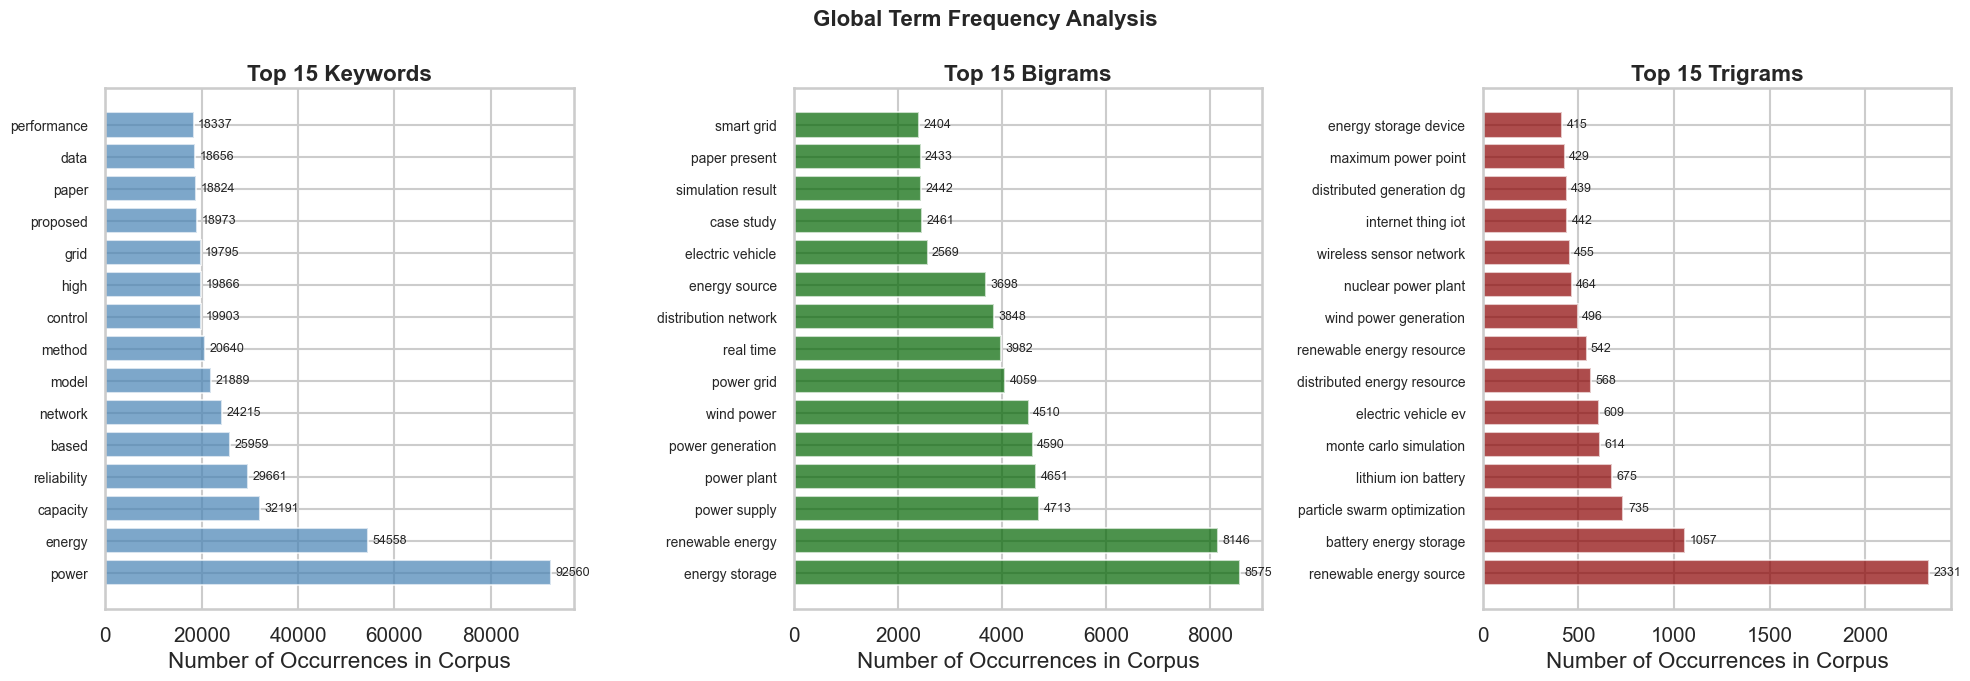

In [76]:
# %%
# Cell 14: Global Term Frequencies Visualization
if data and term_frequencies_file:
    plot_term_frequencies(term_frequencies_file, n_terms=15, save=True)
else:
    print("❌ Term frequencies not available")


### Per-Topic Analysis

📊 Analyzing 4566 documents for topic 1
💾 Per-topic plot saved as: Saved_files_new\topic_1_Power_System_Reliability_termfrequencies.pdf


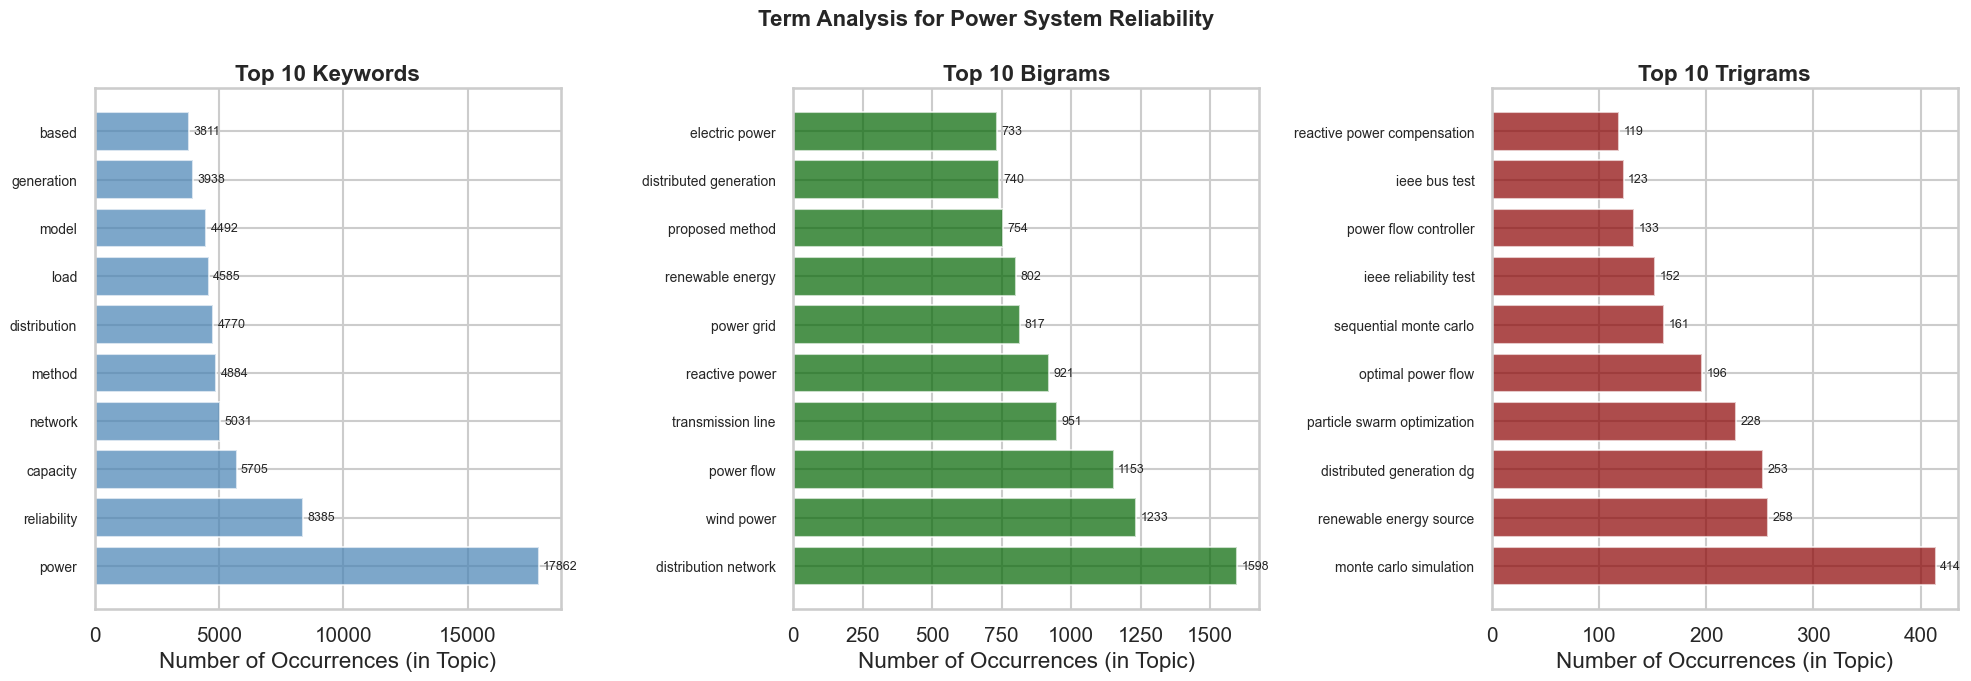

In [77]:
# %%
# Cell 15: Per-Topic Analysis
if data:
    topic_to_plot = 1

    name = topic_names.get(str(topic_to_plot), f"Topic {topic_to_plot}") if topic_names else f"Topic {topic_to_plot}"
    plot_top_terms_for_topic(df, topic_to_plot, topic_name=name, save=True)


### Method Importance

In [78]:
# Print a list of all unique methods present in the method columns of df
unique_methods = set()
for col in method_cols:
    if col.startswith('Method_') and not col.endswith('_Score') and not col.endswith('_Confidence'):
        unique_methods.update(df[col].dropna().unique())
# Remove invalid entries
unique_methods = [m for m in unique_methods if str(m).lower() not in ['nan', 'none', 'lowconfidence']]
print(f"Unique methods found ({len(unique_methods)}):")

for method in sorted(unique_methods):
    print(method)

Unique methods found (206):
adaptive modulation
adaptive neuro-fuzzy inference
agent-based modeling
alternating direction method
analytic hierarchy process ahp
ant colony optimization
approximate computing
artificial bee colony algorithm
automatic generation control agc
bat algorithm
bayesian optimization
binary particle swarm
capacity prediction
closed-form expression
clustering analysis
contingency analysis
convolutional neural network cnns
cost-benefit analysis
cuckoo search
cumulative distribution function
data mining
data-driven optimization
decision tree
deep deterministic
deep deterministic policy gradient
deep neural network
deep q-network
deep reinforcement learning drl
demand response
demand side management dsm
differential evolution
discrete wavelet transform
doubly-fed induction generation
dynamic line rating
dynamic pricing
dynamic programming
dynamic reactive power compensation
dynamic resource allocation
dynamic voltage restorer
economic dispatch
empirical mode decomposi

📊 Plotting 15 methods


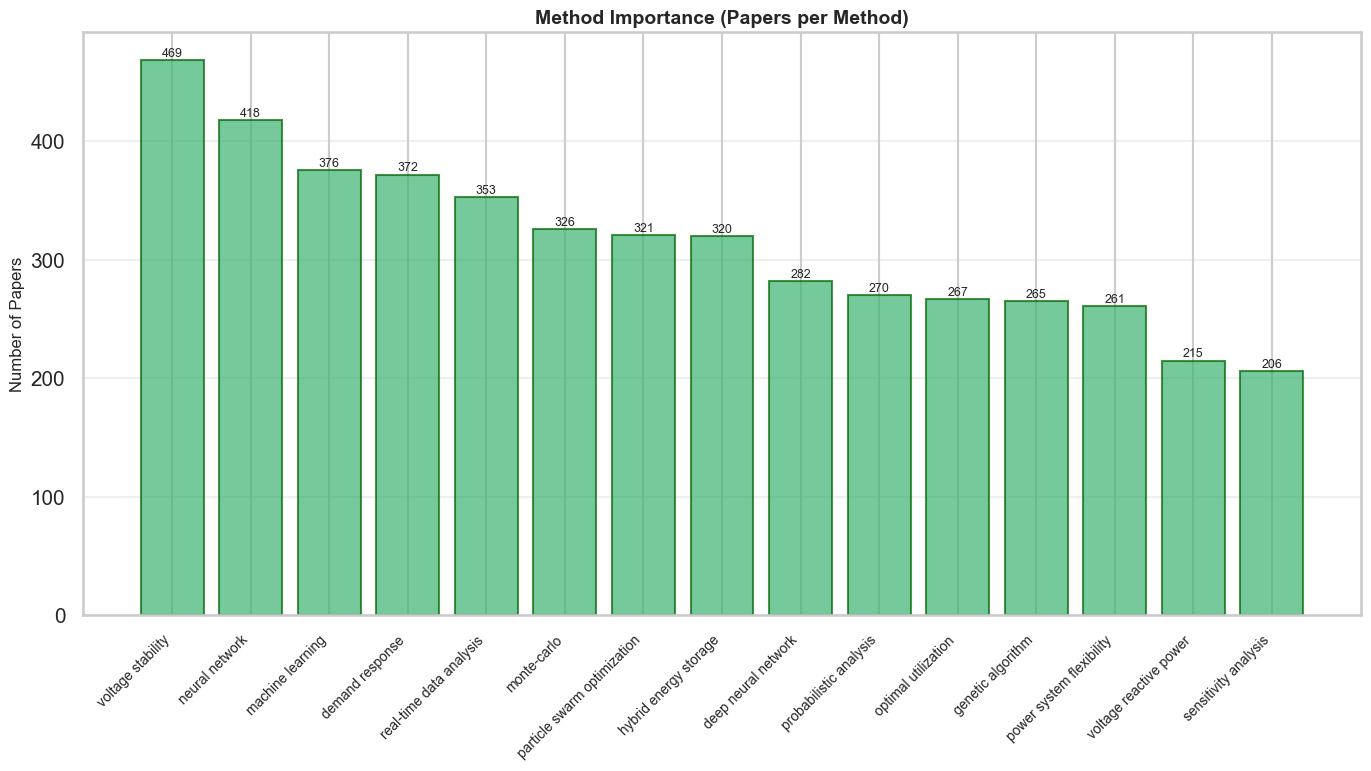

In [112]:
# %%
# Cell 16: Method Importance
if data:
    plot_method_importance(df, max_methods=15, include_low_conf=True
    )


### Topic Importance

In [113]:
for t,n in topic_names.items():print("Topic",t,":",n)

Topic 0 : Wireless Communication Systems
Topic 1 : Power System Reliability
Topic 2 : Renewable Energy Systems
Topic 3 : Electric Vehicle Battery Systems
Topic 4 : Energy Resilience Management
Topic 5 : Thermal Energy Systems
Topic 6 : Renewable Energy Optimization
Topic 7 : Water Energy Systems
Topic 8 : Smart Network Reliability
Topic 9 : Power System Control


In [80]:
for t,n in topic_names.items():print("Topic",t,":",n)

Topic 0 : Wireless Communication Systems
Topic 1 : Power System Reliability
Topic 2 : Renewable Energy Systems
Topic 3 : Electric Vehicle Battery Systems
Topic 4 : Energy Resilience Management
Topic 5 : Thermal Energy Systems
Topic 6 : Renewable Energy Optimization
Topic 7 : Water Energy Systems
Topic 8 : Smart Network Reliability
Topic 9 : Power System Control


In [ ]:

print(f"Saving topic paper count plot to: {save_path}")

Saving topic paper count plot to: output/2025_10_08_reliability_resilience_power_systems_topic_paper_count.pdf


📊 Plotting 10 topics
💾 Saved: output/2025_10_29_reliability_resilience_power_systems_topic_paper_count.pdf


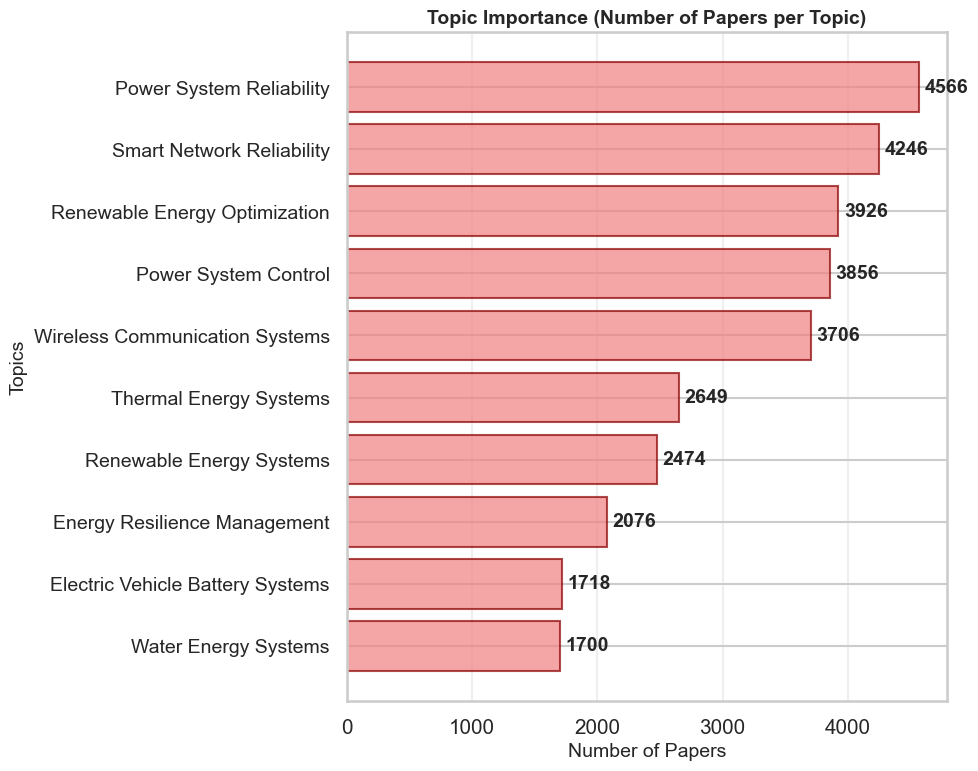

In [114]:
# %%
# Cell 17: Topic Importance
save_path = f"output/{date_string}_topic_paper_count.pdf"
if data:
    plot_topic_importance_with_names(df, topic_names, max_topics=15,figsize=(10,8),save_path=save_path)

### Method Trends Over Time

📊 Citation filter: 5999/30917 papers (≥10 citations)
📈 Plotting trends for: Top 198 Methods
📊 Papers after all filtering: 2723
📅 Years with ≥20 papers: 22


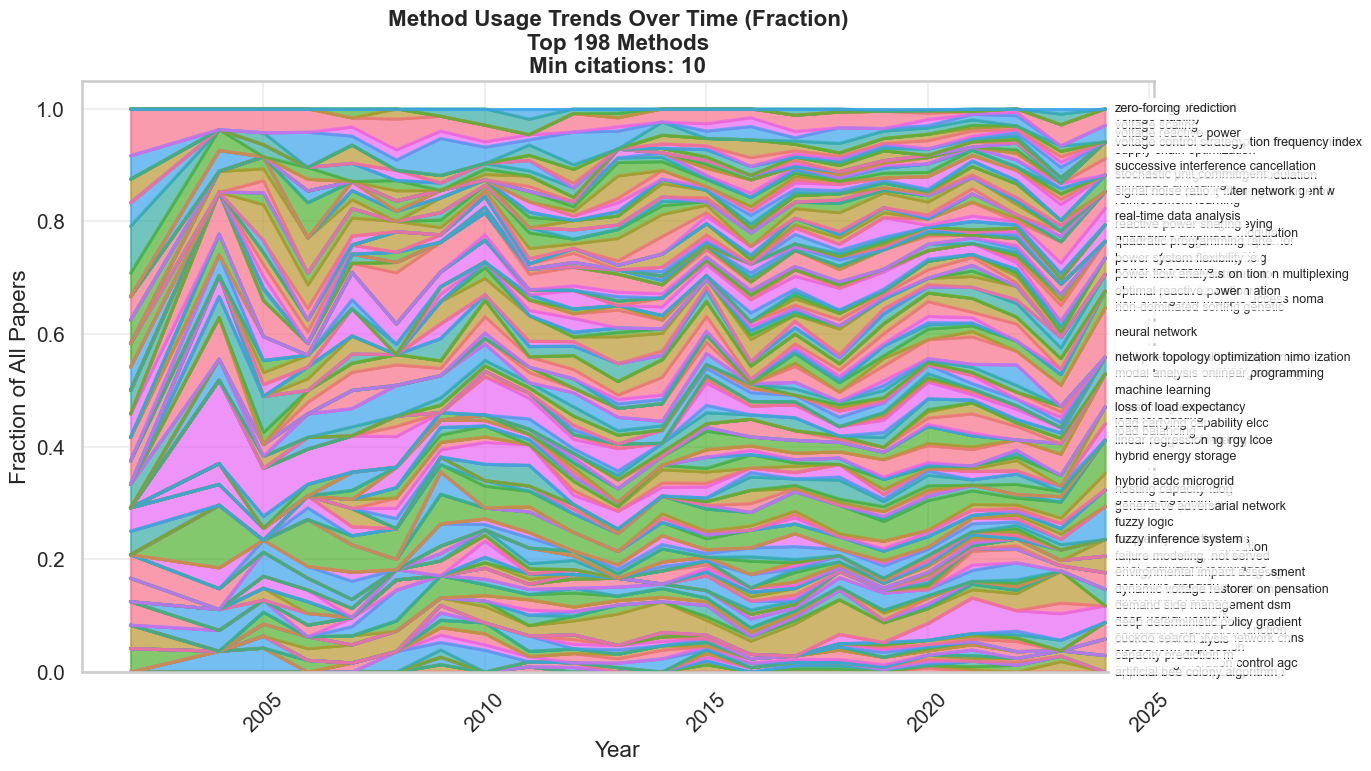

In [115]:
# %%
# Cell 18: Method Trends Over Time
if data:
    plot_method_trends_over_time(df, min_count=1,plot_type='area',value_type='fraction', window_smooth=1,min_citations=10, top_n=300, include_low_conf=True)


### Topic Trends Over Time

In [83]:
#print a list of topic namesas a vertical list
print("\n📚 Loaded Topic Names:")
for idx, name in topic_names.items():
    print(f"  Topic {idx}: {name}")
# print(tolist(topic_names.keys()))


📚 Loaded Topic Names:
  Topic 0: Wireless Communication Systems
  Topic 1: Power System Reliability
  Topic 2: Renewable Energy Systems
  Topic 3: Electric Vehicle Battery Systems
  Topic 4: Energy Resilience Management
  Topic 5: Thermal Energy Systems
  Topic 6: Renewable Energy Optimization
  Topic 7: Water Energy Systems
  Topic 8: Smart Network Reliability
  Topic 9: Power System Control


In [84]:
#Plot list of unique venues in the dataframe, skip venues that appear less than 5 times
#Group venues that contain "IEEE", "ACM", "Springer", "Elsevier", "Wiley" into a single group called "Major Publishers"
if 'venue' in df.columns:
    venue_counts = df['venue'].value_counts(dropna=True)
    
    # Define publisher patterns for better matching
    publisher_patterns = {
        'IEEE': ['ieee', 'institute of electrical'],
        'ACM': ['acm', 'association for computing'],
        'Springer': ['springer', 'lecture notes'],
        'Elsevier': ['elsevier', 'science direct'],
        'Wiley': ['wiley', 'john wiley']
    }
    
    def categorize_venue_enhanced(venue):
        if pd.isna(venue) or not isinstance(venue, str):
            return 'Other'
        
        venue_lower = venue.lower()
        
        # Check each publisher with multiple patterns
        for publisher, patterns in publisher_patterns.items():
            if any(pattern in venue_lower for pattern in patterns):
                return f'{publisher}'
        
        # Group small venues
        if venue_counts.get(venue, 0) < 5:
            return 'Small Venues'
        else:
            return venue
    
    df['venue_category'] = df['venue'].apply(categorize_venue_enhanced)
    unique_venues = df['venue_category'].value_counts()
    
    print("\n🏛️ Enhanced Venue Categories:")
    for venue, count in unique_venues.head(10).items():
        print(f"  {venue}: {count} papers")



🏛️ Enhanced Venue Categories:
  Other: 7856 papers
  Small Venues: 7090 papers
  IEEE: 6680 papers
  Energies: 625 papers
  Journal of Physics: Conference Series: 284 papers
  Sustainability: 241 papers
  arXiv.org: 225 papers
  ECS Meeting Abstracts: 152 papers
  Frontiers in Energy Research: 151 papers
  Applied Sciences: 145 papers



PUBLICATION STATISTICS
📊 Total papers: 28,683

--- Year 2000 Benchmark ---
Before 2000: 1,229 papers (4.3%)
After 2000:  27,454 papers (95.7%)

--- Year 2010 Benchmark ---
Before 2010: 3,862 papers (13.5%)
After 2010:  24,821 papers (86.5%)



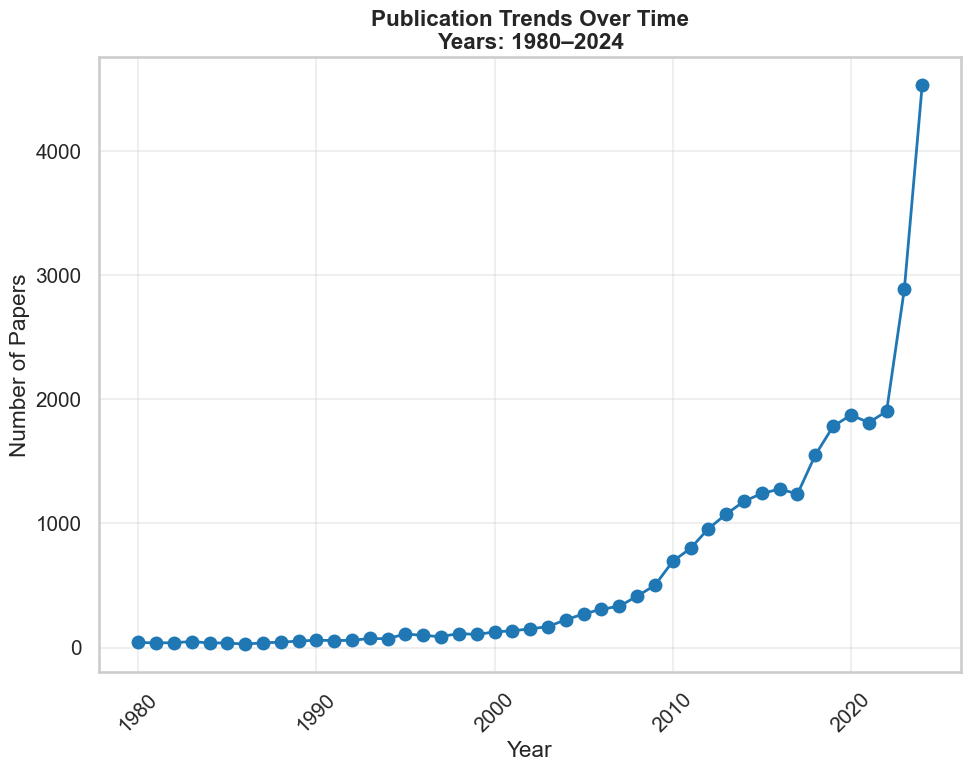

year  count
0   1980     41
1   1981     37
2   1982     39
3   1983     48
4   1984     37
5   1985     37
6   1986     27
7   1987     38
8   1988     43
9   1989     52
10  1990     59
11  1991     56
12  1992     58
13  1993     73
14  1994     71
15  1995    110
16  1996     97
17  1997     88
18  1998    113
19  1999    105
20  2000    126
21  2001    135
22  2002    150
23  2003    169
24  2004    224
25  2005    271
26  2006    309
27  2007    333
28  2008    414
29  2009    502
30  2010    695
31  2011    800
32  2012    958
33  2013   1076
34  2014   1179
35  2015   1242
36  2016   1278
37  2017   1238
38  2018   1552
39  2019   1783
40  2020   1875
41  2021   1814
42  2022   1904
43  2023   2892
44  2024   4535

In [116]:

# Usage example (matching your original call):
plot_publication_trend(df, start_year=1980, end_year=2024,figsize=(10,8))

📅 Year range: 1980 - 2024
📈 Plotting trends for: Top 10 Topics
📊 Papers after all filtering: 28683
📅 Years with ≥0 papers: 45
📌 Focused topics: 10, Background topics: 0


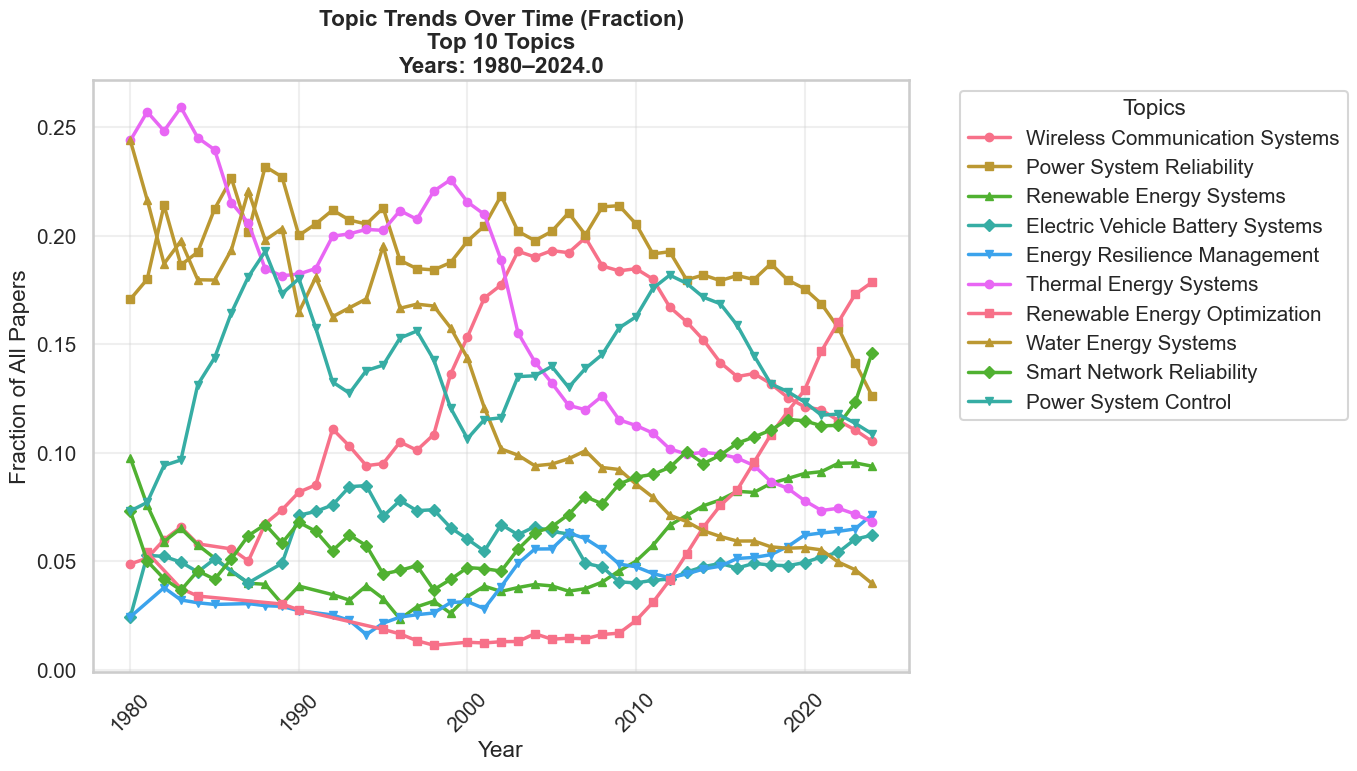

📅 Year range: 1980 - 2024
📈 Plotting trends for: Top 10 Topics
📊 Papers after all filtering: 28683
📅 Years with ≥1 papers: 45
📌 Focused topics: 4, Background topics: 6


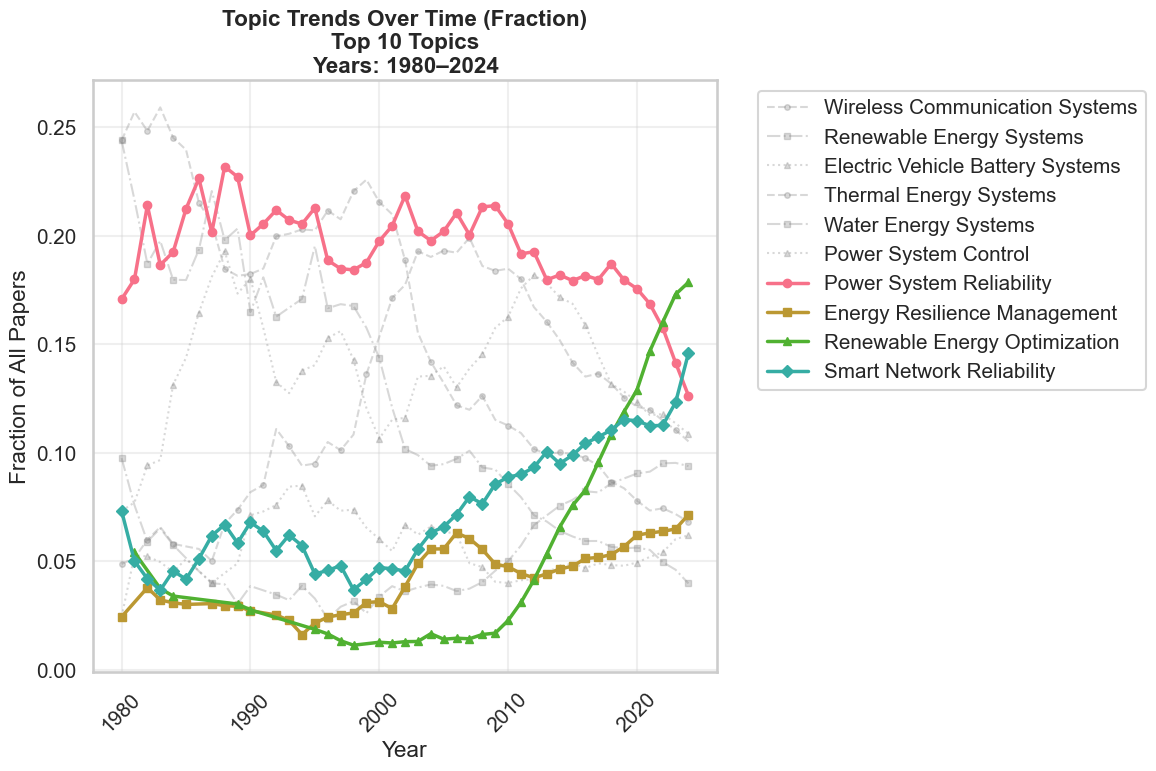

year  Primary_Topic_Index  count  total_count     value
0    1980                    0      2           41  0.048780
9    1981                    0      2           37  0.051417
18   1982                    0      3           39  0.059919
27   1983                    0      4           48  0.065773
37   1984                    0      1           37  0.058024
..    ...                  ...    ...          ...       ...
390  2020                    9    224         1875  0.123406
400  2021                    9    209         1814  0.117341
410  2022                    9    215         1904  0.117792
420  2023                    9    269         2892  0.113586
430  2024                    9    467         4535  0.108719

[431 rows x 5 columns]

In [117]:
# %%
# Cell 19: Topic Trends Over Time

result = plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',  # ✅ Explicitly use the Index column
    #topics=[0,3,7,8],  # List of topic indices to plot decreasing
    #topics=[4,5,6,9],  # List of topic indices to plot increasing
    #topics=[1,2], # Listof topic indices to plot stable
    #topics=[1,4,8],
    topic_names=topic_names, 
    min_papers_per_year=0,
    plot_type='line', # 'line' or 'area'
    value_type='fraction',  # 'fraction' or 'count'
    window_smooth=5,
    start_year=1980,
    end_year=2024.
)
"""
# %%
# Example 1: Fraction-based area plot (default behavior)
plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',
    topics=[0,1,2,3,4],
    topic_names=topic_names, 
    plot_type='area',
    y_axis='fraction',  # Shows percentages
    start_year=2000,
    end_year=2024
)

# Example 2: Absolute count-based area plot
plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',
    topics=[0,1,2,3,4],
    topic_names=topic_names, 
    plot_type='area',
    y_axis='count',  # Shows absolute numbers
    start_year=2000,
    end_year=2024
)
"""
#Line plot with full topic names in legend
plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',
    focus_topics=[1,4,6,8],
    topic_names=topic_names, 
    plot_type='line',
    value_type='fraction',
    start_year=1980,
    window_smooth=5,
    min_papers_per_year=1,
    #min_citations=5,
    end_year=2024,
    figsize=(12,8)
)


### Weighted Method Importance

In [87]:
print(topic_names)

{'0': 'Wireless Communication Systems', '1': 'Power System Reliability', '2': 'Renewable Energy Systems', '3': 'Electric Vehicle Battery Systems', '4': 'Energy Resilience Management', '5': 'Thermal Energy Systems', '6': 'Renewable Energy Optimization', '7': 'Water Energy Systems', '8': 'Smart Network Reliability', '9': 'Power System Control'}


🔍 Starting Enhanced Method Importance Analysis with Score-based Weighting...

📊 Filtering Results:
  Original papers: 30,917
  After Min citations (≥0): 30917 papers
  After Min year (≥1950): 30917 papers
  After Max year (≤2024): 29004 papers
  Final papers: 29,004 (93.8% retained)
📊 Using score-based weighting with columns: ['Method_1', 'Method_2', 'Method_3', 'Method_4', 'Method_5', 'Method_6', 'Method_7', 'Method_8', 'Method_9', 'Method_10']

📋 Method Assignment Status:
  Papers with methods: 12,659 (43.6%)
  Papers without methods: 16,345 (56.4%)
📊 Using confidence score-based weighting...
📊 Plotting top 15 methods
💾 Saved plot to: output\method_importance_score_20251029_142833.pdf


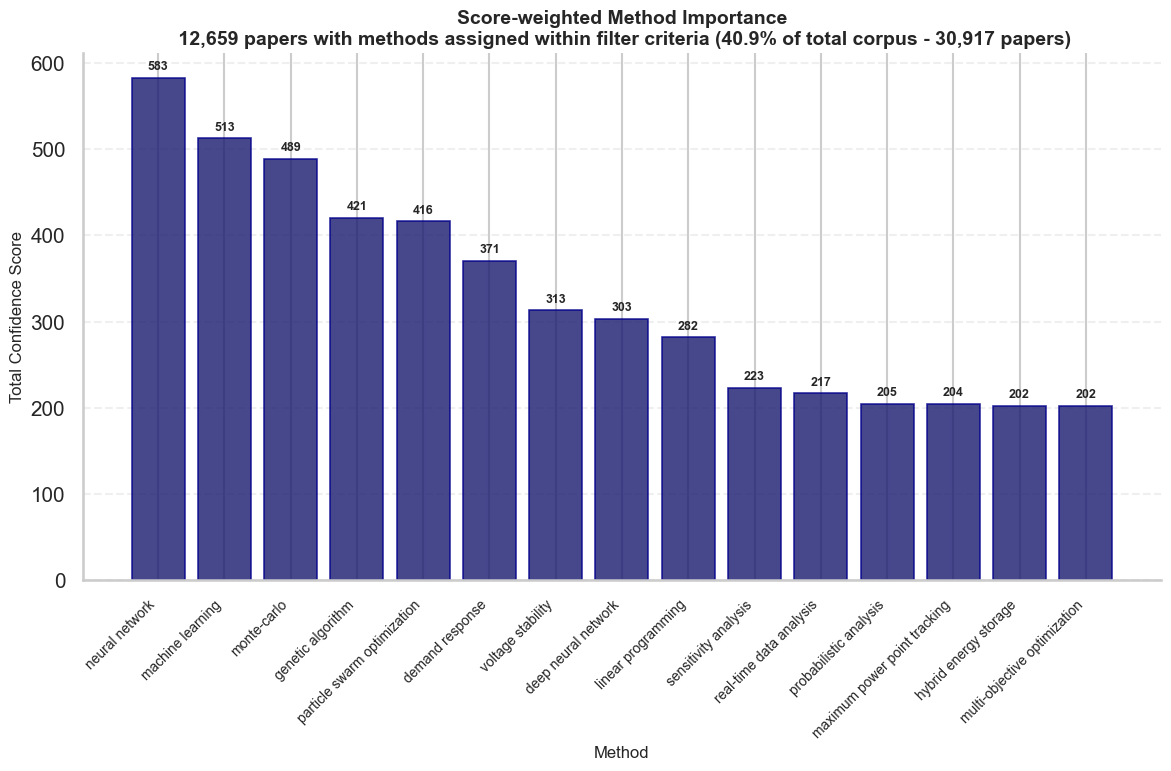


📈 Summary Statistics (score-based):
  Total methods identified: 209
  Methods displayed: 15
  Papers with methods: 12,659
  Score range: 201.973 - 582.971
  Mean score: 329.600
  Total confidence used: 13206.13
  Average confidence per paper: 1.043
  High confidence methods (>1.0): 15
  Medium confidence methods (0.5-1.0): 0
  Lower confidence methods (≤0.5): 0


Method  Weighted_Score
44                 neural network      582.971362
12               machine learning      512.949288
7                     monte-carlo      488.952699
68              genetic algorithm      420.599461
117   particle swarm optimization      416.478171
30                demand response      370.845293
45              voltage stability      313.078611
185           deep neural network      303.380481
29             linear programming      281.643374
43           sensitivity analysis      223.070189
19        real-time data analysis      216.701226
5          probabilistic analysis      204.619784
51   maximum power point tracking      204.319238
75          hybrid energy storage      202.410920
119  multi-objective optimization      201.973055

In [118]:
# %%
# Cell 20: Weighted Method Importance
"""def plot_weighted_method_importance_filtered(df, 
                                           n_top=5, 
                                           plot_top_k=None, 
                                           method_label_prefix="Method_",
                                           # NEW: Simplified Topic Filtering by Number
                                           topic_numbers=None,          # Filter by topic number(s) - list or single int
                                           min_citations=None,          # Minimum citation count
                                           max_citations=None,          # Maximum citation count
                                           venues_include=None,         # List of venues to include
                                           venues_exclude=None,         # List of venues to exclude
                                           min_year=None,              # Minimum publication year
                                           max_year=None,              # Maximum publication year
                                           # Visualization Parameters
                                           figsize=(14, 8),
                                           save_dir=None,
                                           show_filter_info=True):"""

#if data:
    #weighted_results = plot_weighted_method_importance_filtered(df, n_top=10, plot_top_k=25, figsize=(12,8), min_year=1980, max_year=2024, min_citations=5)


plot_weighted_method_importance_filtered(df, 
                                         n_top=10,
                                         plot_top_k=15,
                                         figsize=(12,8),
                                         topic_names=topic_names,
                                         min_year=1950,
                                         max_year=2024,
                                         min_citations=0,
                                         #topic_numbers=[1,4,8],
                                         weighting_method='score',
                                         save_dir="output")
# score_result, rank_result = compare_weighting_methods(df, topic_numbers=[0, 1, 2])



### Weighted Method Trends

📊 Citation filter: 28879/28879 papers (≥0 citations)
📊 Using score-based weighting (confidence scores, uncorrected)

📊 Score-based Weighting Summary:
   Score range: 0.011 - 1.000
   Mean confidence score: 0.542
   Papers with high confidence (>0.1): 24261/24343 assignments


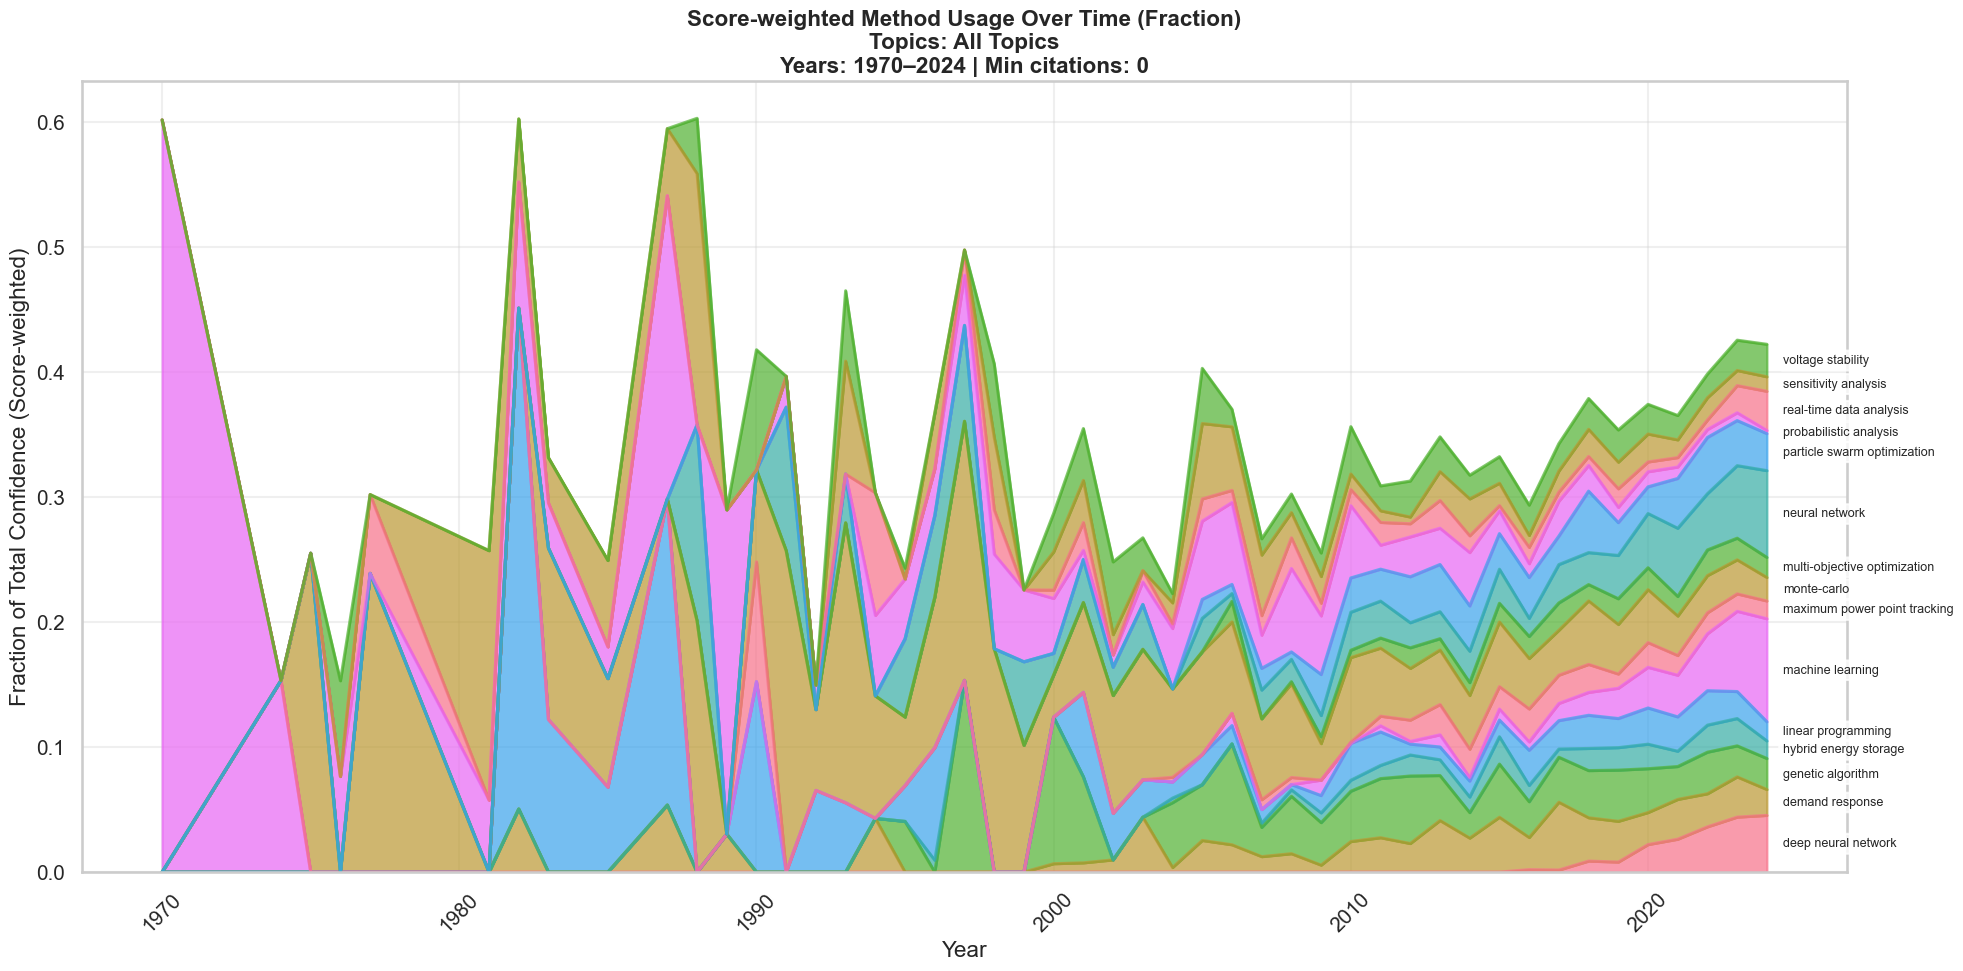

In [119]:
# %%
# Cell 21: Weighted Method Trends
plot_top_k=15
#adjust fig height to method count / 2 +3 and round up to nearest integer
#fig_height = min(int((plot_top_k / 3) + 5),20)
fig_height = 10

if data:
    plot_weighted_method_trends_over_time(
        df, n_top=10, plot_top_k=plot_top_k, 
        start_year=1970, end_year=2024, 
        min_papers_per_year=1,
        plot_type='area',
        value_type='fraction',
        min_citations=0, 
        window_smooth=0,
        #
        # methods=["monte carlo simulation","artificial neural network", "optimal power flow opf", "stochastic optimization","loss of load probability", "probabilistic reliability", "stochastic programming", "state estimation"],
        figsize=(20, fig_height),
        log_scale=False
        
    )


### Topic-Specific Method Trends

📊 Citation filter: 24148/24148 papers (≥0 citations)
📊 Using score-based weighting (confidence scores, uncorrected)

📊 Score-based Weighting Summary:
   Score range: 0.013 - 0.996
   Mean confidence score: 0.553
   Papers with high confidence (>0.1): 5676/5677 assignments


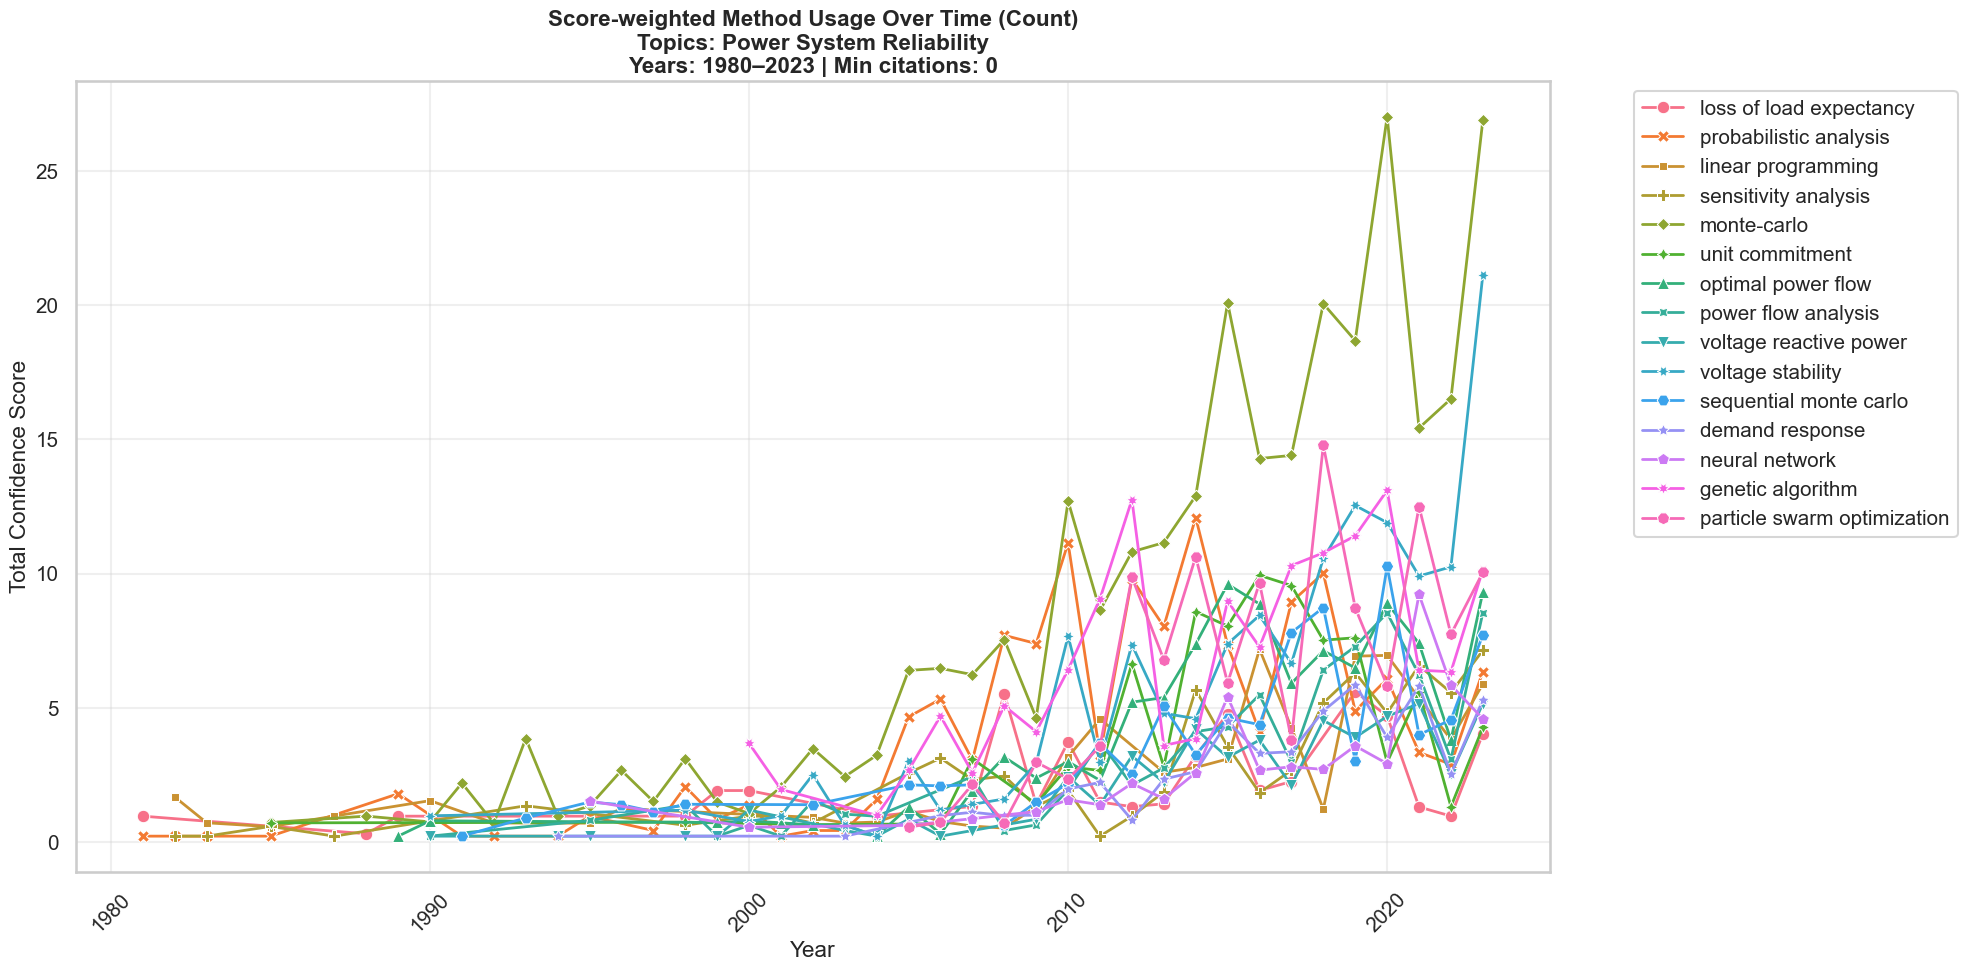

In [120]:
# %%
# Example usage with both weighting methods:
# plot_df_score = plot_weighted_method_trends_over_time(df, weighting_method='score')
# plot_df_rank = plot_weighted_method_trends_over_time(df, weighting_method='rank')


# Cell 22: Topic-Specific Method Trends
plot_top_k=15
#adjust fig height to method count / 2 +3 and round up to nearest integer
fig_height = int((plot_top_k / 4) + 7)
if data:
    plot_weighted_method_trends_over_time(
        df, n_top=10, 
        topics=[1], 
        topic_names=topic_names,
        start_year=1980, end_year=2023, 
        min_papers_per_year=1,
        min_citations=0, 
        plot_top_k=plot_top_k,
        plot_type='line', window_smooth=1,
        value_type='count',  # 'fraction' or 'count'
        weighting_method='score',
        log_scale=False,
        figsize=(20, fig_height),
        #min_citations=5,
        #venues=['IEEE Transactions on Power Systems', 'IEEE Transactions on Smart Grid', 'Electric Power Systems Research'],
        #methods=['particle swarm optimization','monte carlo simulation']
        
    )


In [121]:
#usage:
canonical_json_path = "Saved_files_new/method_variant_groups.json"  
canonical_methods, method_alias_map = load_canonical_methods(canonical_json_path)
print(f"✅ Loaded {len(canonical_methods)} canonical methods")
print("   Sample:", canonical_methods[:10])

✅ Loaded 219 canonical methods
   Sample: ['adaptive modulation', 'adaptive neuro-fuzzy inference', 'agent-based modeling', 'alternating direction method', 'analytic hierarchy process ahp', 'ant colony optimization', 'approximate computing', 'artificial bee colony algorithm', 'automatic generation control agc', 'bat algorithm']


### GGT correction of growth

In [122]:
# GGT corrected growth analysis

# Run integrated analysis
results_ggt, background_growth, dataset_rsquared = classify_technology_lifecycle_ggt_integrated(
    df, 
    canonical_methods=canonical_methods,  # loaded from JSON
    min_publications=1,
    #topic_filter=[1,4,8]
)



📅 YEAR RANGE FILTER
   Range: all to 2024
   Papers: 29004 of 30917 (93.8%)
   Excluded: 1913 papers outside year range

🔧 STEP 1: CALCULATING PUBLICATION INFLATION CORRECTION | Years: start–2024
🔍 CALCULATING PUBLICATION INFLATION CORRECTION
Data spans from 1952 to 2024
Valid years for analysis: 58 (from 1960 to 2024)
Publication growth pattern (last 10 years):
  2015: 1242 papers
  2016: 1278 papers
  2017: 1238 papers
  2018: 1552 papers
  2019: 1783 papers
  2020: 1875 papers
  2021: 1814 papers
  2022: 1904 papers
  2023: 2892 papers
  2024: 4535 papers

📈 Overall dataset growth characteristics:
  Average papers per year: 498.6
  Annual absolute growth: 35.97 papers/year
  Annual relative growth: 0.072 (7.2%)
  R²: 0.535

🔧 STEP 2: PROCESSING 219 METHODS WITH GGT CORRECTION | Years: start–2024

🔍 Processing method 1/219: adaptive modulation
  ✅ Stage: Mature | Pattern: mixed
     Raw growth (recent): 0.0394, GGT-corrected: -0.0327
     R² (recent): 0.019, Importance: 33.4
     Fu

In [123]:

# Analyze results
results_df = analyze_ggt_results(results_ggt, background_growth)

# Key methods verification
print(f"\n✅ KEY METHODS VERIFICATION (GGT-Corrected):")
key_methods = ['monte carlo simulation', 'artificial neural network', 'genetic algorithm', 
              'reinforcement learning', 'particle swarm optimization']

for method in key_methods:
    if method in results_ggt:
        profile = results_ggt[method]
        print(f"\n📋 {method.upper()}:")
        print(f"    Classification: {profile['lifecycle_stage']}")
        print(f"    Raw Growth: {profile['raw_growth_rate_recent']:.3f}")
        print(f"    GGT-Corrected Growth: {profile['ggt_corrected_growth_recent']:.3f}")
        print(f"    Total Importance: {profile['total_importance']:.1f}")
        print(f"    Statistical Confidence: R² = {profile['r_squared_recent']:.3f}, p = {profile['p_value_recent']:.3f}")

print(f"\n📝 INTERPRETATION GUIDE:")
print(f"• Background growth correction: {background_growth:.1%} annually")
print(f"• Positive GGT values: Methods growing faster than field average")
print(f"• Near-zero GGT values: Methods growing at field average (mature)")
print(f"• Negative GGT values: Methods declining relative to field growth")
print(f"• Dataset reliability: R² = {dataset_rsquared:.3f} for overall growth trend")


📊 GGT-CORRECTED LIFECYCLE ANALYSIS RESULTS (DUAL TREND)

📈 LIFECYCLE STAGE DISTRIBUTION (based on recent trends):
    Emerging:  28 methods ( 13.6%)
     Growing:  40 methods ( 19.4%)
      Mature: 131 methods ( 63.6%)
   Declining:   7 methods (  3.4%)

🔄 TRAJECTORY PATTERN DISTRIBUTION:
     Consistent Growth:  49 methods ( 23.8%)
    Consistent Decline:   2 methods (  1.0%)
              Emerging:  52 methods ( 25.2%)
     Consistent Stable:  47 methods ( 22.8%)
                 Mixed:  56 methods ( 27.2%)

Total methods analyzed: 206
Background publication growth: 7.2% annually
Analysis window: Last 10 years for recent trends

🏆 TOP EXAMPLES BY LIFECYCLE STAGE (Recent Trend Classification):

EMERGING:
  1. 📈 neural network
     Pattern: Consistent Growth
     Recent: GGT=+0.227, R²=0.67
     Full:   GGT=+0.051, R²=0.36
     Importance: 583.0, Peak ratio: 10.43
  2. 🌱 machine learning
     Pattern: Emerging
     Recent: GGT=+0.300, R²=0.62
     Full:   GGT=-0.002, R²=0.16
     Impo

##### debug diagnostics...

In [124]:
def diagnose_ggt_classification_issues(df, results_ggt, method_name='linear programming', 
                                       topic_filter=None):
    """
    Diagnose classification with dual trend analysis (full history + recent window).
    """
    
    print(f"🔍 DIAGNOSTIC REPORT FOR: {method_name}")
    print("="*70)
    
    # Check if method exists in results
    if method_name not in results_ggt:
        print(f"❌ Method '{method_name}' not found in results")
        print(f"Available methods: {list(results_ggt.keys())[:10]}")
        return
    
    profile = results_ggt[method_name]
    
    # 1. Show classification details with DUAL TRENDS
    print(f"\n📊 CLASSIFICATION DETAILS:")
    print(f"  Lifecycle stage: {profile['lifecycle_stage']}")
    print(f"  Trajectory pattern: {profile.get('trajectory_pattern', 'N/A')}")
    
    print(f"\n  RECENT TREND (10-year window):")
    print(f"    Raw growth rate: {profile['raw_growth_rate_recent']:.4f} ({profile['raw_growth_rate_recent']*100:.2f}%/year)")
    print(f"    GGT-corrected: {profile['ggt_corrected_growth_recent']:.4f} ({profile['ggt_corrected_growth_recent']*100:.2f}%/year)")
    print(f"    R²: {profile['r_squared_recent']:.3f}")
    print(f"    P-value: {profile.get('p_value_recent', 'N/A'):.4f}" if 'p_value_recent' in profile else "    P-value: N/A")
    print(f"    Years used: {profile.get('years_used_recent', 'N/A')}")
    
    print(f"\n  FULL HISTORY TREND:")
    print(f"    Raw growth rate: {profile['raw_growth_rate_full']:.4f} ({profile['raw_growth_rate_full']*100:.2f}%/year)")
    print(f"    GGT-corrected: {profile['ggt_corrected_growth_full']:.4f} ({profile['ggt_corrected_growth_full']*100:.2f}%/year)")
    print(f"    R²: {profile['r_squared_full']:.3f}")
    print(f"    P-value: {profile.get('p_value_full', 'N/A'):.4f}" if 'p_value_full' in profile else "    P-value: N/A")
    print(f"    Years used: {profile.get('years_used_full', profile['years_active'])}")
    
    print(f"\n  TREND CHANGE:")
    trend_change = profile['ggt_corrected_growth_recent'] - profile['ggt_corrected_growth_full']
    print(f"    Δ GGT (Recent - Full): {trend_change:+.4f}")
    if abs(trend_change) > 0.05:
        direction = "📈 ACCELERATION" if trend_change > 0 else "📉 DECELERATION"
        print(f"    → {direction} (significant change)")
    
    print(f"\n  OTHER METRICS:")
    print(f"    Background correction: {profile['overall_growth_correction']:.4f} ({profile['overall_growth_correction']*100:.2f}%/year)")
    print(f"    Total importance: {profile['total_importance']:.2f}")
    print(f"    Peak ratio: {profile['peak_ratio']:.2f}")
    print(f"    Years active: {profile['years_active']}")
    
    # 2. Check against ALL classification criteria (multi-tier)
    print(f"\n🎯 CLASSIFICATION CRITERIA CHECK:")
    
    # Extract metrics for readability
    ggt_recent = profile['ggt_corrected_growth_recent']
    ggt_full = profile['ggt_corrected_growth_full']
    r2_recent = profile['r_squared_recent']
    r2_full = profile['r_squared_full']
    importance = profile['total_importance']
    peak_ratio = profile['peak_ratio']
    years_active = profile['years_active']
    pattern = profile.get('trajectory_pattern', 'unknown')
    
    print(f"\n  EMERGING CRITERIA:")
    emerging_1 = ggt_recent > 0.15
    emerging_2 = (ggt_recent > 0.15 and importance > 35)
    emerging_3 = (pattern == 'resurgent' and ggt_recent > 0.05 and r2_recent > 0.2)
    
    print(f"    Strong growth (>15%): {emerging_1} (GGT={ggt_recent:.3f})")
    print(f"    Strong growth + importance: {emerging_2} (imp={importance:.1f})")
    print(f"    Resurgent pattern: {emerging_3} (pattern={pattern})")
    print(f"    ✓ Classified as Emerging: {any([emerging_1, emerging_2, emerging_3])}")
    
    print(f"\n  GROWING CRITERIA:")
    growing = (0.05 < ggt_recent <= 0.15 and importance > 35 and peak_ratio > 2.5)
    print(f"    Moderate growth (5-15%): {0.05 < ggt_recent <= 0.15}")
    print(f"    Importance > 35: {importance > 35}")
    print(f"    Peak ratio > 2.5: {peak_ratio > 2.5}")
    print(f"    ✓ Classified as Growing: {growing}")
    
    print(f"\n  MATURE CRITERIA:")
    mature_1 = (abs(ggt_recent) <= 0.05 and importance > 78 and years_active > 10)
    mature_2 = (ggt_recent > -0.05 and importance > 35 and years_active > 8)
    mature_3 = (importance > 20 and ggt_recent > -0.05)
    
    print(f"    Stable high importance: {mature_1}")
    print(f"    Stable medium importance: {mature_2}")
    print(f"    Above low threshold: {mature_3}")
    print(f"    ✓ Classified as Mature: {any([mature_1, mature_2, mature_3])}")
    
    print(f"\n  DECLINING CRITERIA (MULTI-TIER):")
    
    # Tier 1: Moderate decline with strong evidence
    tier1 = (ggt_recent < -0.05 and r2_recent > 0.3 and peak_ratio > 3.0 and years_active > 5)
    print(f"    Tier 1 (moderate decline, strong evidence):")
    print(f"      GGT < -5%: {ggt_recent < -0.05} (actual: {ggt_recent:.3f})")
    print(f"      R² > 0.3: {r2_recent > 0.3} (actual: {r2_recent:.3f})")
    print(f"      Peak > 3.0: {peak_ratio > 3.0} (actual: {peak_ratio:.2f})")
    print(f"      Years > 5: {years_active > 5} (actual: {years_active})")
    print(f"      → Passes Tier 1: {tier1}")
    
    # Tier 2: Strong decline with moderate evidence
    tier2 = (ggt_recent < -0.10 and r2_recent > 0.2 and peak_ratio > 2.0 and years_active > 5)
    print(f"    Tier 2 (strong decline, moderate evidence):")
    print(f"      GGT < -10%: {ggt_recent < -0.10} (actual: {ggt_recent:.3f})")
    print(f"      R² > 0.2: {r2_recent > 0.2} (actual: {r2_recent:.3f})")
    print(f"      Peak > 2.0: {peak_ratio > 2.0} (actual: {peak_ratio:.2f})")
    print(f"      → Passes Tier 2: {tier2}")
    
    # Tier 3: Any negative with very strong evidence
    tier3 = (ggt_recent < 0 and r2_recent > 0.4 and peak_ratio > 3.0 and years_active > 8)
    print(f"    Tier 3 (any negative, very strong evidence):")
    print(f"      GGT < 0: {ggt_recent < 0}")
    print(f"      R² > 0.4: {r2_recent > 0.4} (actual: {r2_recent:.3f})")
    print(f"      Peak > 3.0: {peak_ratio > 3.0}")
    print(f"      Years > 8: {years_active > 8}")
    print(f"      → Passes Tier 3: {tier3}")
    
    # Tier 4: Die-hard pattern
    tier4 = (pattern == 'die_hard' and ggt_recent < 0 and r2_recent > 0.2 and peak_ratio > 3.0)
    print(f"    Tier 4 (die-hard pattern):")
    print(f"      Pattern = die-hard: {pattern == 'die_hard'} (actual: {pattern})")
    print(f"      GGT < 0: {ggt_recent < 0}")
    print(f"      R² > 0.2: {r2_recent > 0.2}")
    print(f"      Peak > 3.0: {peak_ratio > 3.0}")
    print(f"      → Passes Tier 4: {tier4}")
    
    passes_declining = any([tier1, tier2, tier3, tier4])
    print(f"\n    ✓✓ CLASSIFIED AS DECLINING: {passes_declining}")
    
    # 3. Explain classification decision
    print(f"\n💡 CLASSIFICATION EXPLANATION:")
    actual_stage = profile['lifecycle_stage']
    
    if actual_stage == 'Declining' and passes_declining:
        print(f"  ✅ Correctly classified as DECLINING")
        if tier1:
            print(f"     Reason: Tier 1 - Moderate recent decline with strong statistical evidence")
        elif tier2:
            print(f"     Reason: Tier 2 - Strong recent decline (>10%)")
        elif tier3:
            print(f"     Reason: Tier 3 - Negative trend with very high R²")
        elif tier4:
            print(f"     Reason: Tier 4 - Die-hard pattern (was growing, now declining)")
    elif actual_stage != 'Declining' and passes_declining:
        print(f"  ⚠️ SHOULD be DECLINING but classified as {actual_stage}")
        print(f"     This is unexpected - check classification function!")
    elif actual_stage == 'Declining' and not passes_declining:
        print(f"  ⚠️ Classified as DECLINING but doesn't meet standard criteria")
        print(f"     May be classified by alternative logic or edge case")
    else:
        print(f"  ✅ Correctly NOT classified as declining")
        print(f"     Current classification: {actual_stage}")
        if pattern == 'resurgent':
            print(f"     Note: Shows RESURGENCE pattern (historical decline → recent growth)")
        
        # Show what would need to change
        print(f"\n  To be classified as DECLINING, would need:")
        if ggt_recent >= -0.05:
            print(f"     - More negative recent growth (currently {ggt_recent:.3f}, need < -0.05)")
        if r2_recent <= 0.3:
            print(f"     - Higher R² (currently {r2_recent:.3f}, need > 0.3)")
        if peak_ratio <= 3.0:
            print(f"     - Higher peak ratio (currently {peak_ratio:.2f}, need > 3.0)")
    
    # 4. Show yearly data
    print(f"\n📈 YEARLY SCORE TREND:")
    yearly_scores = profile['yearly_scores']
    
    # Show last 15 years
    recent_years = yearly_scores.tail(15) if len(yearly_scores) > 15 else yearly_scores
    
    print(f"  Last {len(recent_years)} years:")
    for year, score in recent_years.items():
        print(f"    {int(year)}: {score:.2f}")
    
    # Show peak year
    peak_year = yearly_scores.idxmax()
    peak_score = yearly_scores.max()
    print(f"\n  Peak: {peak_score:.2f} in {int(peak_year)}")
    print(f"  Mean: {yearly_scores.mean():.2f}")
    print(f"  Peak ratio: {peak_score / yearly_scores.mean():.2f}")
    
    # 5. Dataset consistency check
    print(f"\n🔬 DATASET CONSISTENCY CHECK:")
    print(f"  Background growth used: {profile['overall_growth_correction']:.4f} ({profile['overall_growth_correction']*100:.2f}%)")
    print(f"  Recent window: {profile.get('years_used_recent', 10)} years")
    print(f"  Full history: {profile.get('years_used_full', years_active)} years")
    
    return profile


# Usage:
diagnose_ggt_classification_issues(df, results_ggt, 'loss of load expectancy')#, topic_filter=[1, 4, 8])


🔍 DIAGNOSTIC REPORT FOR: loss of load expectancy

📊 CLASSIFICATION DETAILS:
  Lifecycle stage: Declining
  Trajectory pattern: mixed

  RECENT TREND (10-year window):
    Raw growth rate: -0.0851 (-8.51%/year)
    GGT-corrected: -0.1573 (-15.73%/year)
    R²: 0.241
    P-value: 0.1499
    Years used: 10

  FULL HISTORY TREND:
    Raw growth rate: 0.0302 (3.02%/year)
    GGT-corrected: -0.0420 (-4.20%/year)
    R²: 0.204
    P-value: 0.0236
    Years used: 25

  TREND CHANGE:
    Δ GGT (Recent - Full): -0.1153
    → 📉 DECELERATION (significant change)

  OTHER METRICS:
    Background correction: 0.0721 (7.21%/year)
    Total importance: 60.70
    Peak ratio: 2.91
    Years active: 25

🎯 CLASSIFICATION CRITERIA CHECK:

  EMERGING CRITERIA:
    Strong growth (>15%): False (GGT=-0.157)
    Strong growth + importance: False (imp=60.7)
    Resurgent pattern: False (pattern=mixed)
    ✓ Classified as Emerging: False

  GROWING CRITERIA:
    Moderate growth (5-15%): False
    Importance > 35: 

{'lifecycle_stage': 'Declining',
 'trajectory_pattern': 'mixed',
 'raw_growth_rate_full': 0.03015951385922655,
 'raw_growth_rate_recent': -0.08511147222688968,
 'ggt_corrected_growth_full': -0.04198156695225243,
 'ggt_corrected_growth_recent': -0.15725255303836866,
 'r_squared_full': 0.203593240370273,
 'r_squared_recent': 0.2407490250863498,
 'trend_type': 'ggt_corrected_dual',
 'peak_ratio': 2.90636410499561,
 'total_importance': 60.70263490016098,
 'years_active': 25,
 'yearly_scores': 1981    0.955169
 1988    0.300047
 1989    0.955169
 1995    0.955169
 1998    0.957729
 1999    1.910337
 2000    1.910337
 2004    0.955169
 2007    1.319718
 2008    5.515382
 2009    1.392685
 2010    3.724580
 2011    1.481827
 2012    1.309608
 2013    1.415366
 2014    3.937269
 2015    5.534475
 2016    3.824772
 2017    2.975243
 2019    7.056958
 2020    5.490882
 2021    1.298407
 2022    0.957729
 2023    4.027892
 2024    0.540715
 dtype: float64,
 'p_value_full': 0.023577647506504144,
 

#### GGT comparison plots 

📊 Citation filter: 28683/28683 papers (≥0 citations)
🔍 Calculating background publication growth for GGT correction...
📊 Calculated background growth: 9.0%/year (R²=0.569)
📊 Using score-based weighting (confidence scores, GGT-corrected)
📊 Applied 5-year rolling average smoothing
💾 Saved: output/method_trends_topic1_4_8.pdf

📊 Score-based Weighting Summary:
   Score range: 0.000 - 0.960
   Mean confidence score: 0.026
   Papers with high confidence (>0.1): 280/10966 assignments
   Original score range (before GGT): 0.012 - 0.997
   Background growth correction: 9.0%/year


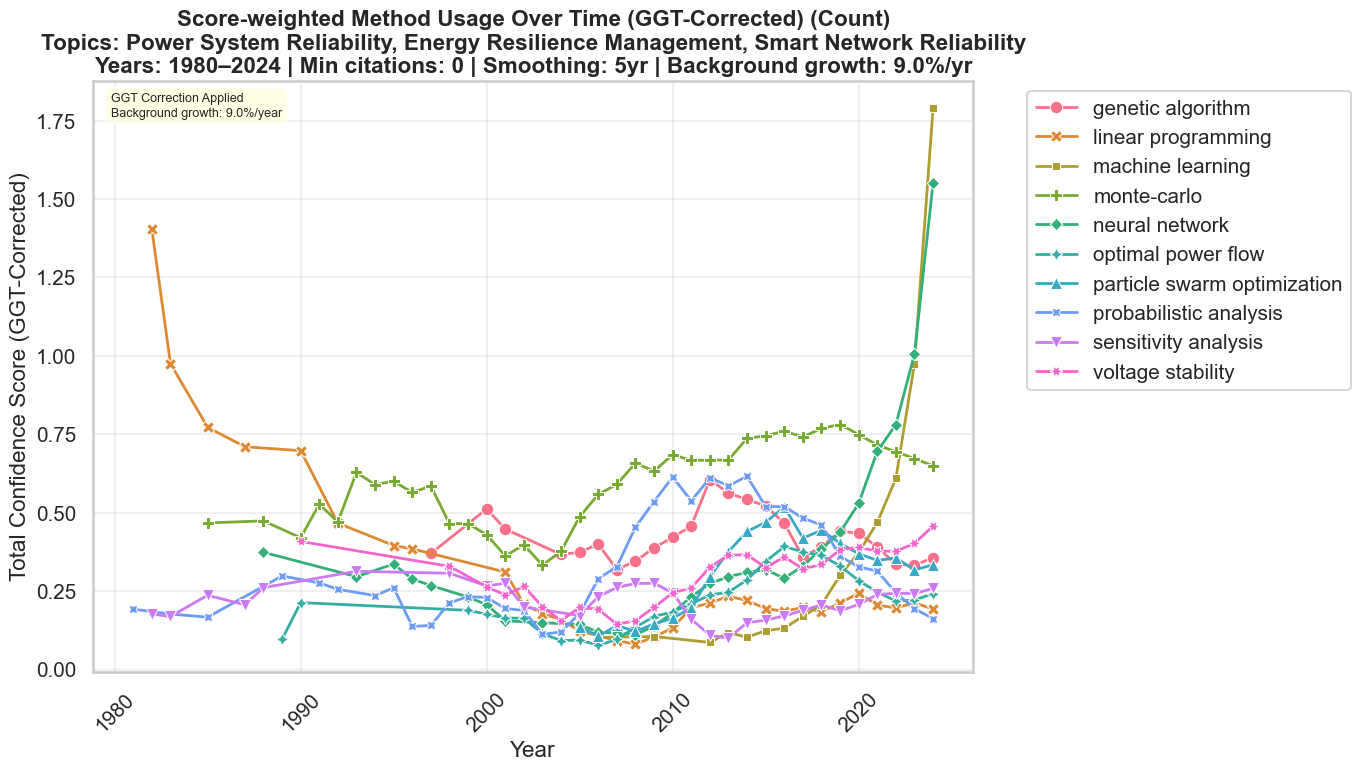

In [128]:
"""  Topic 0: Wireless Communication Systems
  Topic 1: Power System Reliability
  Topic 2: Renewable Energy Systems
  Topic 3: Electric Vehicle Battery Systems
  Topic 4: Energy Resilience Management
  Topic 5: Thermal Energy Systems
  Topic 6: Renewable Energy Optimization
  Topic 7: Water Energy Systems
  Topic 8: Smart Network Reliability
  Topic 9: Power System Control
"""

"""
    Enhanced weighted method trends with score-based weighting, citation/venue filtering, and GGT correction.
    
    Parameters:
    - weighting_method: 'score' (use actual confidence scores) or 'rank' (use rank-based points)
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    - ggt_correction: Boolean - apply GGT correction to remove publication inflation bias
    - overall_growth_rate: Background growth rate for GGT correction (calculated if None)
    """
# 2. With GGT correction (auto-calculate background growth)
plot_df_ggt = plot_weighted_method_trends_over_time(df, plot_top_k=10,#topics=[1,8],
                                                   start_year=1980, end_year=2024,
                                                   window_smooth=5,
                                                   min_papers_per_year=0,
                                                   min_citations=0,
                                                   topics=[1,4,8],
                                                   #plot_type='area',
                                                   topic_names=topic_names,
                                                   ggt_correction=True,
                                                   value_type='count',
                                                   save_path="output/method_trends_topic1_4_8.pdf",
                                                   #topic_names=['Power System Reliability','Smart Network Reliability','Energy Resilience Management']
                                                   #methods=['value of lost load', 'capacity credit']
                                                   #methods=['reliability economics','demand side management dsm','modal analysis','unit commitment','probabilistic analysis']
                                                   #methods=['multi-user detection','sensitivity analysis','optimal reactive power','optimal utilization','failure modeling','monte-carlo','automatic generation control agc','stochastic programming','feedback control','load frequency control','capacity prediction','frequency variation' ]
                                                   #methods=['expected energy not served','loss of load expectancy','stochastic programming','monte-carlo','capacity prediction','feedback control', 'kalman filter','multi-user detection',]
                                                   )


📊 Using score-based weighting (confidence scores, uncorrected)

📊 Score-based Weighting Summary:
   Score range: 0.013 - 1.000
   Mean confidence score: 0.549
   Papers with high confidence (>0.1): 26074/26079 assignments


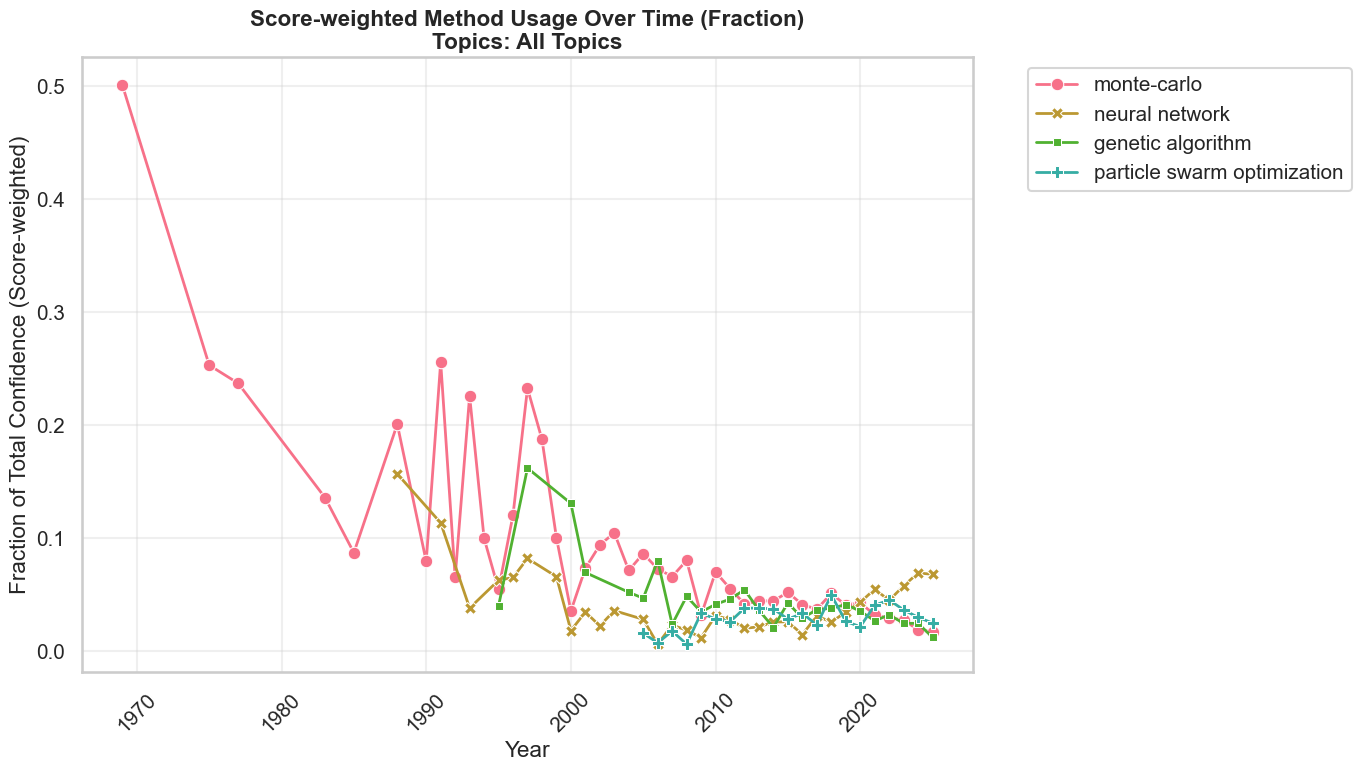

🔍 Calculating background publication growth for GGT correction...
📊 Calculated background growth: 7.0%/year (R²=0.554)
📊 Using score-based weighting (confidence scores, GGT-corrected)

📊 Score-based Weighting Summary:
   Score range: 0.002 - 0.960
   Mean confidence score: 0.100
   Papers with high confidence (>0.1): 10319/25846 assignments
   Original score range (before GGT): 0.013 - 1.000
   Background growth correction: 7.0%/year


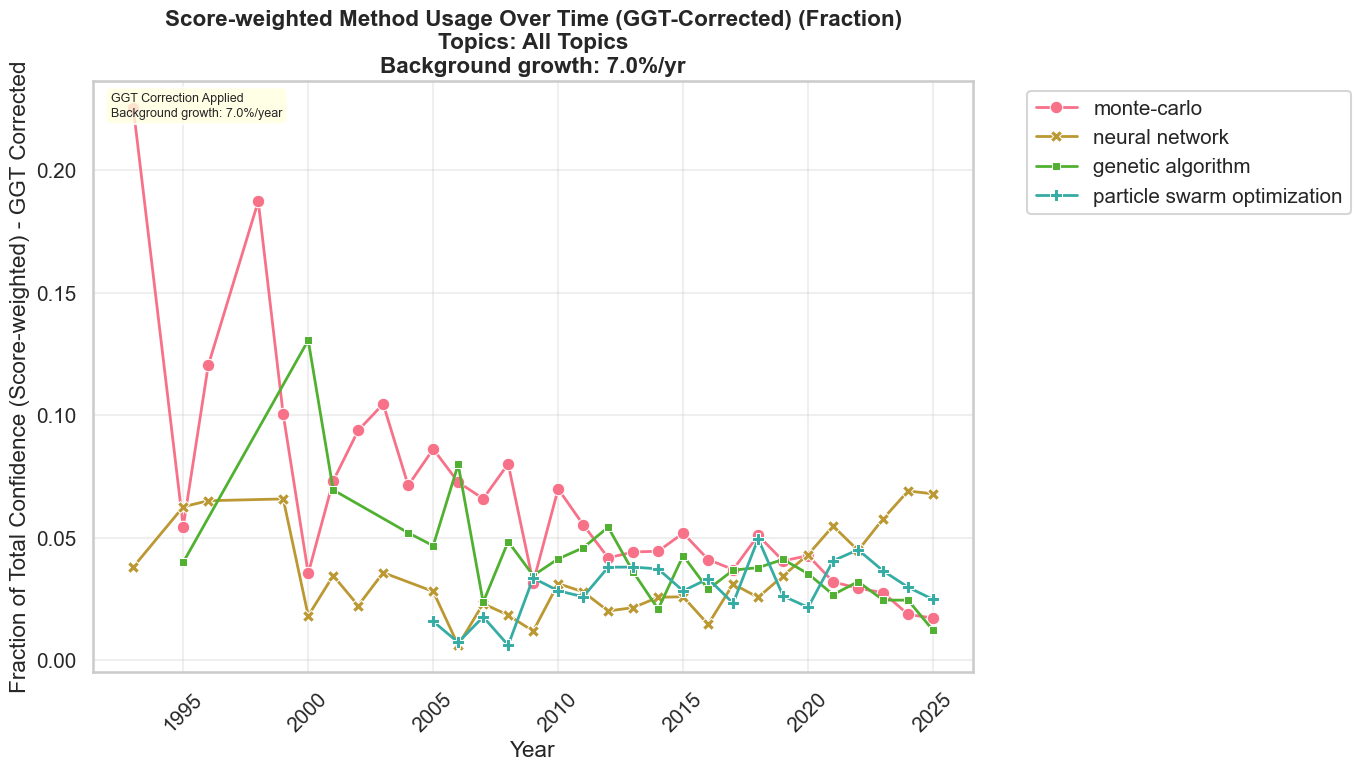

year                       method     points  actual_total_points  \
5     1993                  monte-carlo   3.811369            16.889480   
7     1993               neural network   0.643570            16.889480   
25    1995            genetic algorithm   0.846707            21.153186   
31    1995                  monte-carlo   1.154669            21.153186   
36    1995               neural network   1.326156            21.153186   
...    ...                          ...        ...                  ...   
3068  2024  particle swarm optimization  10.195141           341.472824   
3203  2025            genetic algorithm   1.982876           162.410499   
3236  2025                  monte-carlo   2.805248           162.410499   
3246  2025               neural network  11.037401           162.410499   
3259  2025  particle swarm optimization   4.038417           162.410499   

         value  
5     0.225665  
7     0.038105  
25    0.040027  
31    0.054586  
36    0.062693  
...        ...  
3068  0.029856  
3203  0.012209  
3236  0.017273  
3246  0.067960  
3259  0.024865  

[106 rows x 5 columns]

In [95]:

#Compare specific methods with and without GGT correction
key_methods = ['monte-carlo', 'neural network', 'genetic algorithm','particle swarm optimization']
 
# # Without GGT
plot_weighted_method_trends_over_time(df, methods=key_methods, ggt_correction=False,min_papers_per_year=1)
# 
# # With GGT
plot_weighted_method_trends_over_time(df, methods=key_methods, ggt_correction=True)

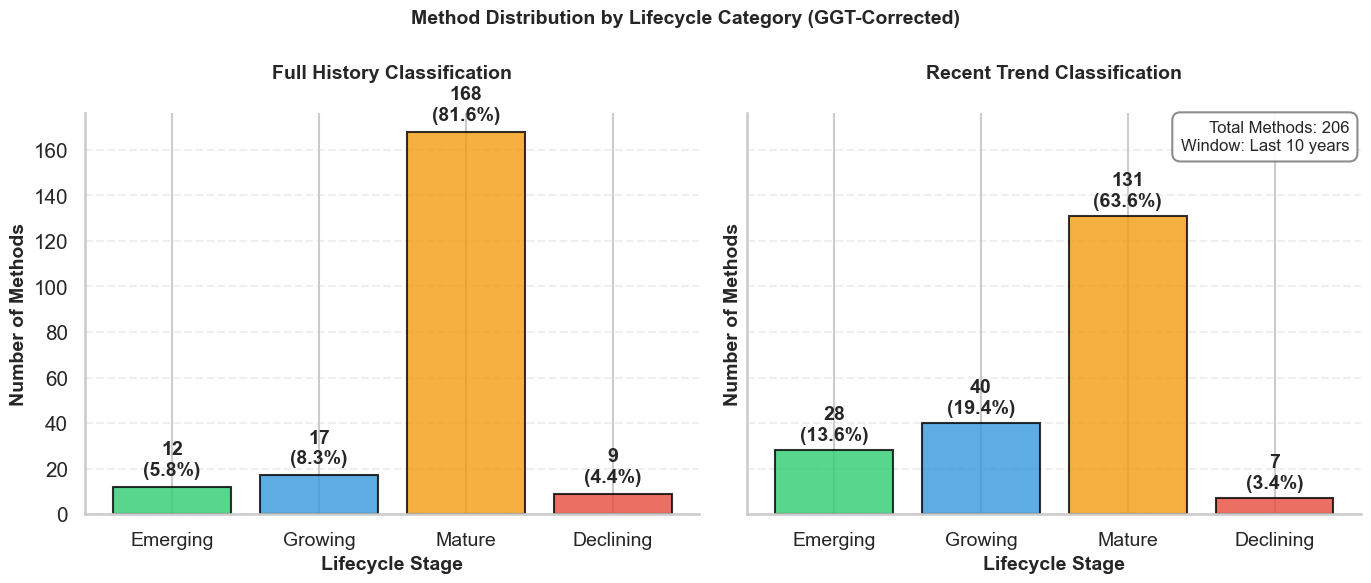


📊 Lifecycle Category Distribution (Recent Trend):
  Emerging    :  28 methods ( 13.6%)  (+16)
  Growing     :  40 methods ( 19.4%)  (+23)
  Mature      : 131 methods ( 63.6%)  (-37)
  Declining   :   7 methods (  3.4%)   (-2)
  Total       : 206 methods

  Note: Changes show Recent vs Full history classification
        Positive = More methods in this stage with recent trends


In [129]:
#counts = plot_ggt_lifecycle_distribution(results_ggt)
# 
# Or without percentages:
# Plot with comparison (default)
counts_recent, counts_full = plot_ggt_lifecycle_distribution(
    results_ggt, fontsize=14,figsize=(14,6),
    show_comparison=True)

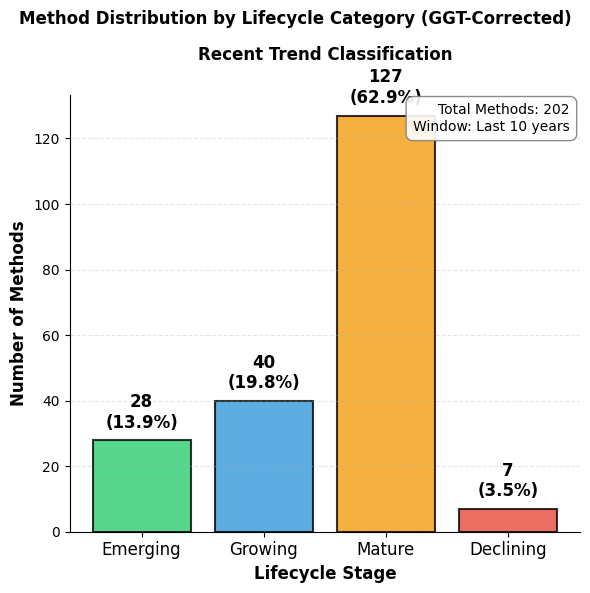


📊 Lifecycle Category Distribution (Recent Trend):
  Emerging    :  28 methods ( 13.9%)
  Growing     :  40 methods ( 19.8%)
  Mature      : 127 methods ( 62.9%)
  Declining   :   7 methods (  3.5%)
  Total       : 202 methods


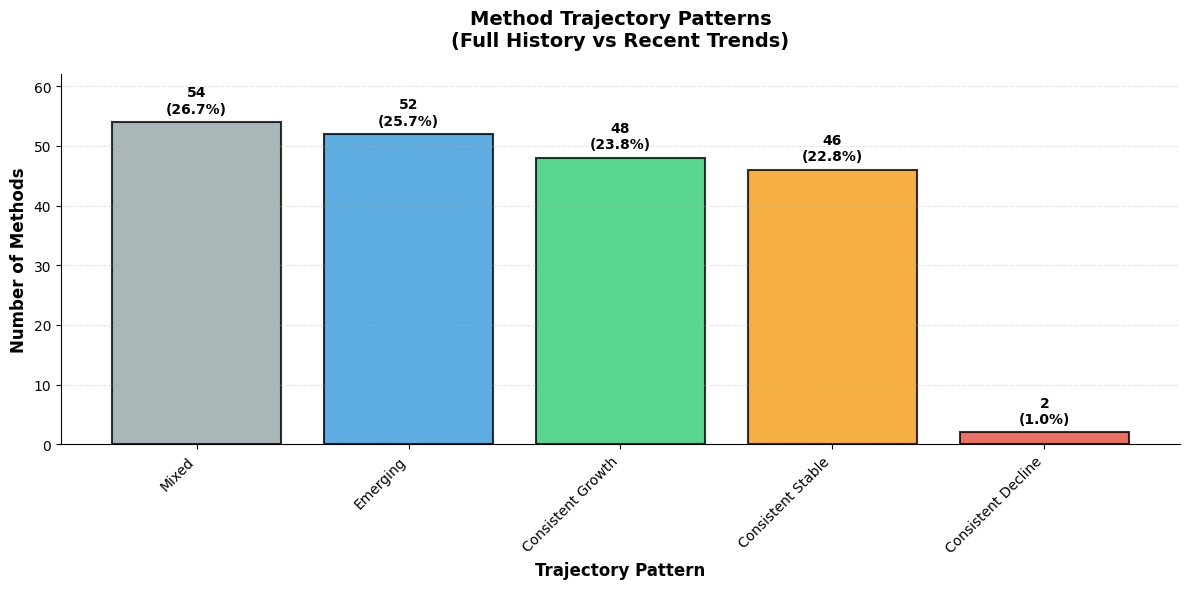


🔄 Trajectory Pattern Distribution:
                      Mixed:  54 ( 26.7%)
                   Emerging:  52 ( 25.7%)
          Consistent Growth:  48 ( 23.8%)
          Consistent Stable:  46 ( 22.8%)
         Consistent Decline:   2 (  1.0%)
                      Total: 202


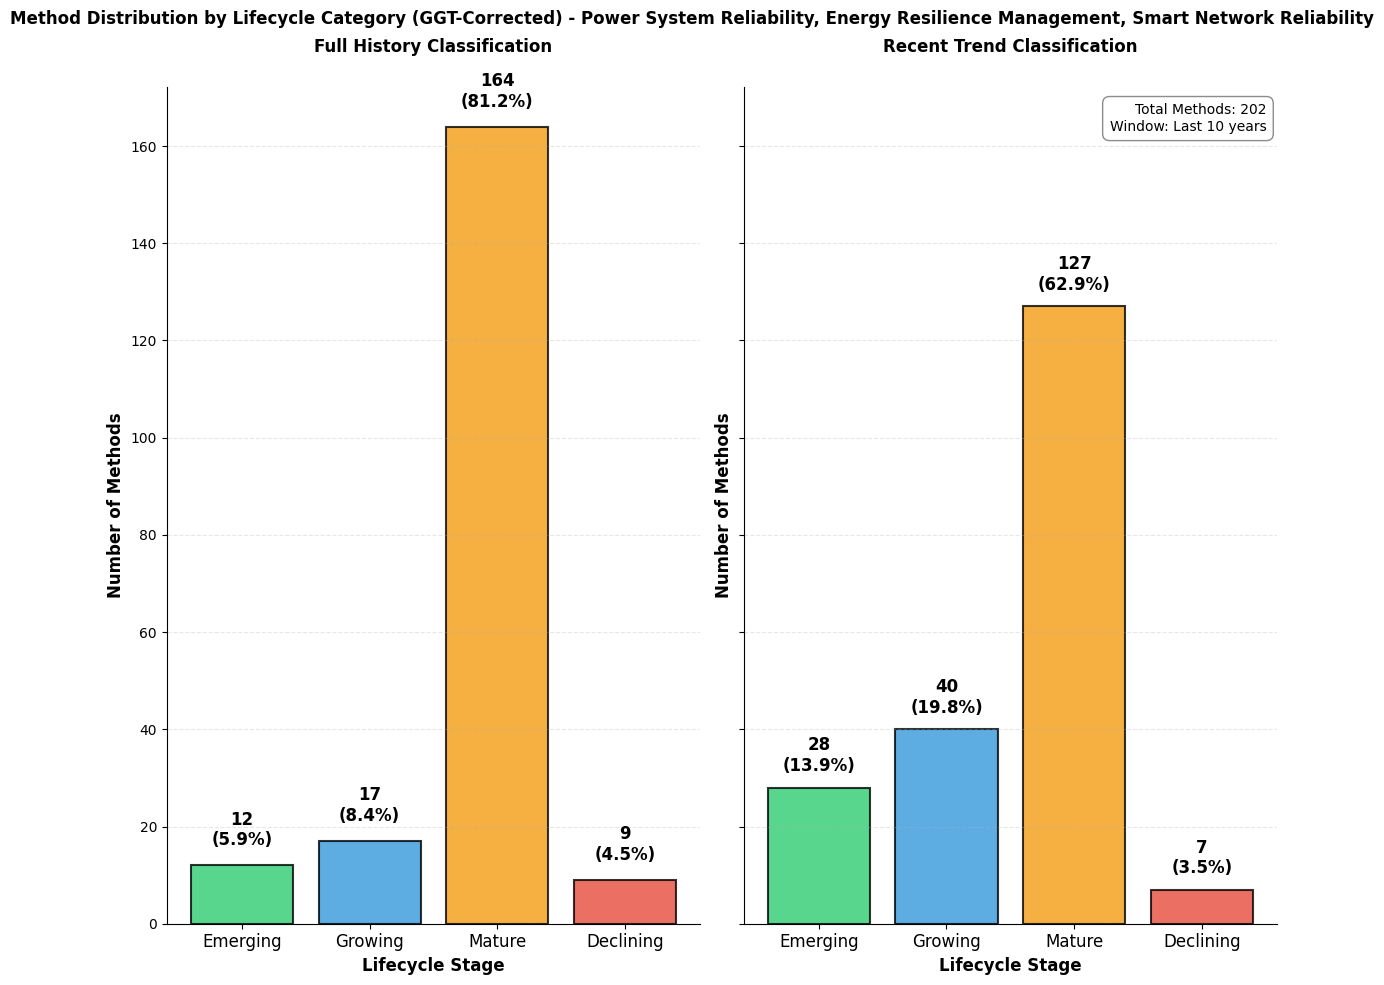


📊 Lifecycle Category Distribution (Recent Trend) (Filtered by: Power System Reliability, Energy Resilience Management, Smart Network Reliability):
  Emerging    :  28 methods ( 13.9%)  (+16)
  Growing     :  40 methods ( 19.8%)  (+23)
  Mature      : 127 methods ( 62.9%)  (-37)
  Declining   :   7 methods (  3.5%)   (-2)
  Total       : 202 methods

  Note: Changes show Recent vs Full history classification
        Positive = More methods in this stage with recent trends


In [44]:




# Plot only recent classification
counts = plot_ggt_lifecycle_distribution(
    results_ggt, 
    show_comparison=False,
    figsize=(12, 6)
)

# Plot trajectory patterns
patterns = plot_trajectory_pattern_distribution(results_ggt)

# With topic filter
counts_recent, counts_full = plot_ggt_lifecycle_distribution(
    results_ggt,
    topic_filter=[1, 4, 8],
    topic_names=topic_names,
    show_comparison=True
)


📊 Plotting top 15 methods by importance
🔍 Processing 15 methods for trend visualization...
📊 Applying 3-year rolling average smoothing


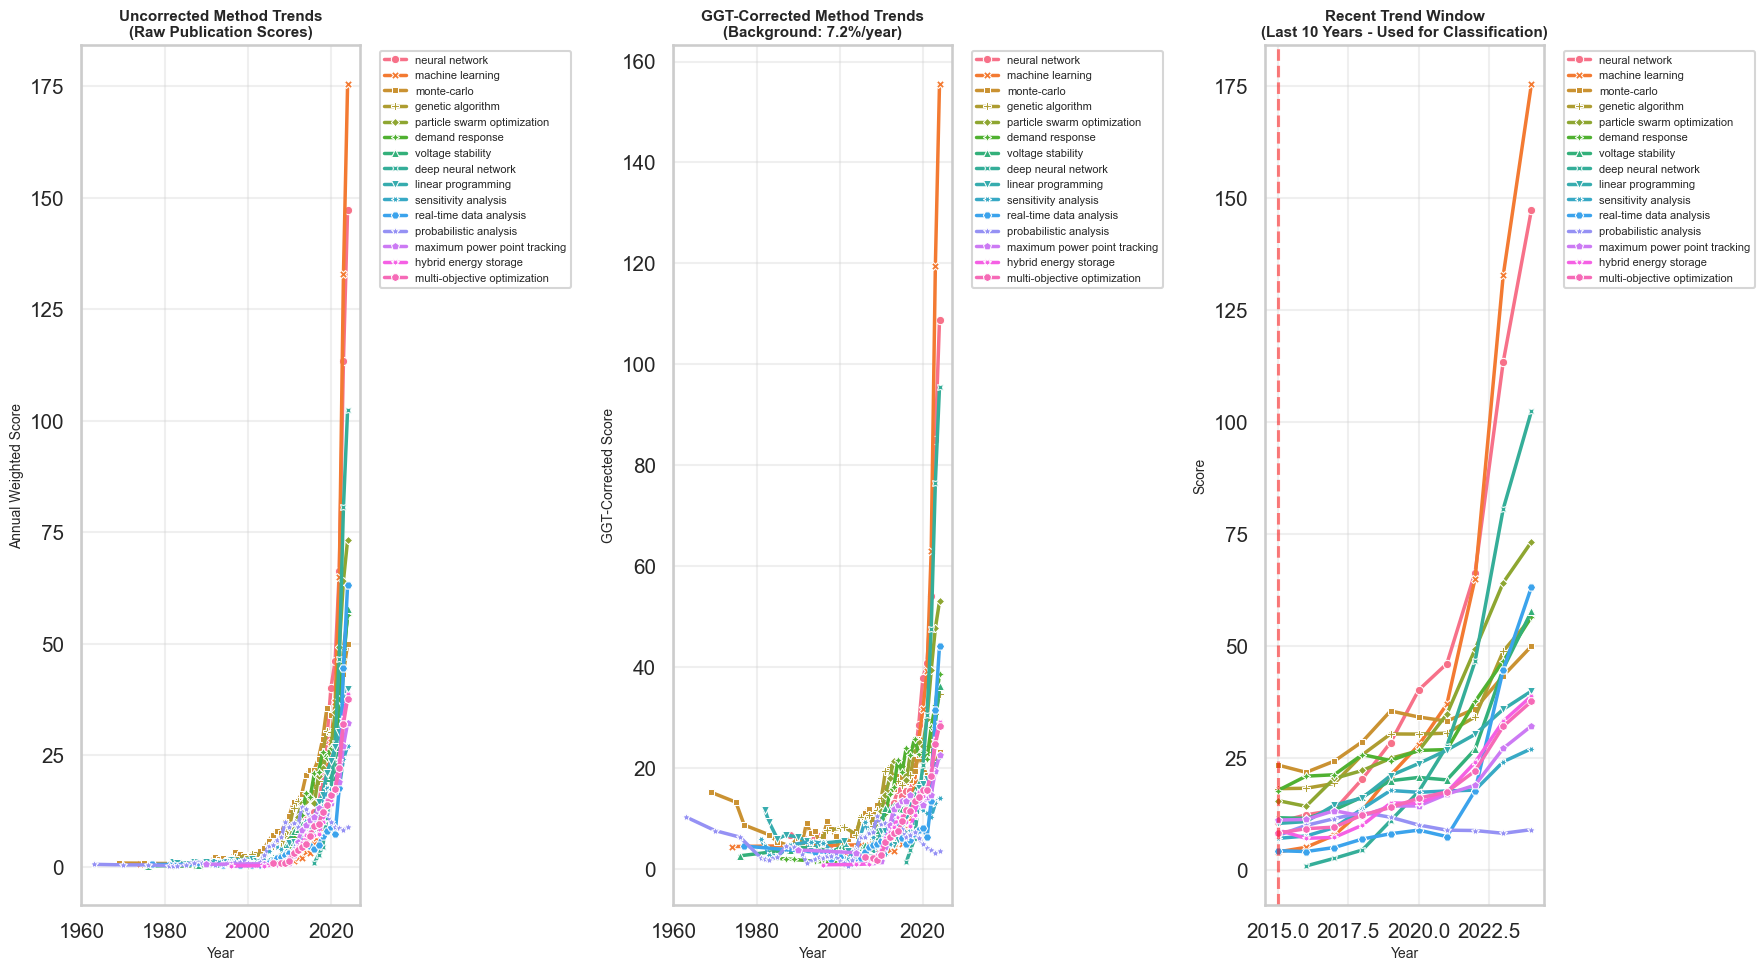


📈 TREND ANALYSIS SUMMARY:
Background growth rate: 7.2% annually
Recent window: Last 10 years

Method                    Full GGT   Recent GGT   Pattern         Stage
--------------------------------------------------------------------------------
neural network               +0.051      +0.227 📈 consistent_g  Emerging
machine learning             -0.002      +0.300 • emerging      Emerging
monte-carlo                  -0.003      +0.014 • consistent_s  Mature
genetic algorithm            +0.027      +0.062 • emerging      Growing
particle swarm optimizat     +0.082      +0.124 📈 consistent_g  Growing
demand response              +0.017      +0.052 • emerging      Growing
voltage stability            +0.014      +0.127 • emerging      Growing
deep neural network          +0.333      +0.333 📈 consistent_g  Emerging
linear programming           +0.009      +0.086 • emerging      Growing
sensitivity analysis         -0.003      +0.068 • emerging      Growing


(     year                        method      score
 0    1988                neural network   0.851624
 1    1991                neural network   0.782273
 2    1993                neural network   1.040340
 3    1995                neural network   1.199963
 4    1996                neural network   1.252616
 ..    ...                           ...        ...
 391  2020  multi-objective optimization  16.038498
 392  2021  multi-objective optimization  17.440533
 393  2022  multi-objective optimization  22.120298
 394  2023  multi-objective optimization  32.079408
 395  2024  multi-objective optimization  37.644390
 
 [396 rows x 3 columns],
      year                        method      score
 0    1988                neural network   6.728972
 1    1991                neural network   5.824686
 2    1993                neural network   6.379748
 3    1995                neural network   6.513365
 4    1996                neural network   6.436490
 ..    ...                           

In [97]:
#GGT correction visualizations vs non-corrected trends


# 1. Basic trend comparison
plot_ggt_corrected_trends(df, results_ggt, background_growth,n_top_methods=15,end_year=2024)#,methods=['monte carlo simulation', 'artificial neural network','genetic algorithm', 'reinforcement learning'])


### Basic Topic-Method Heatmap

📊 Creating heatmap for 5 topics and 25 methods


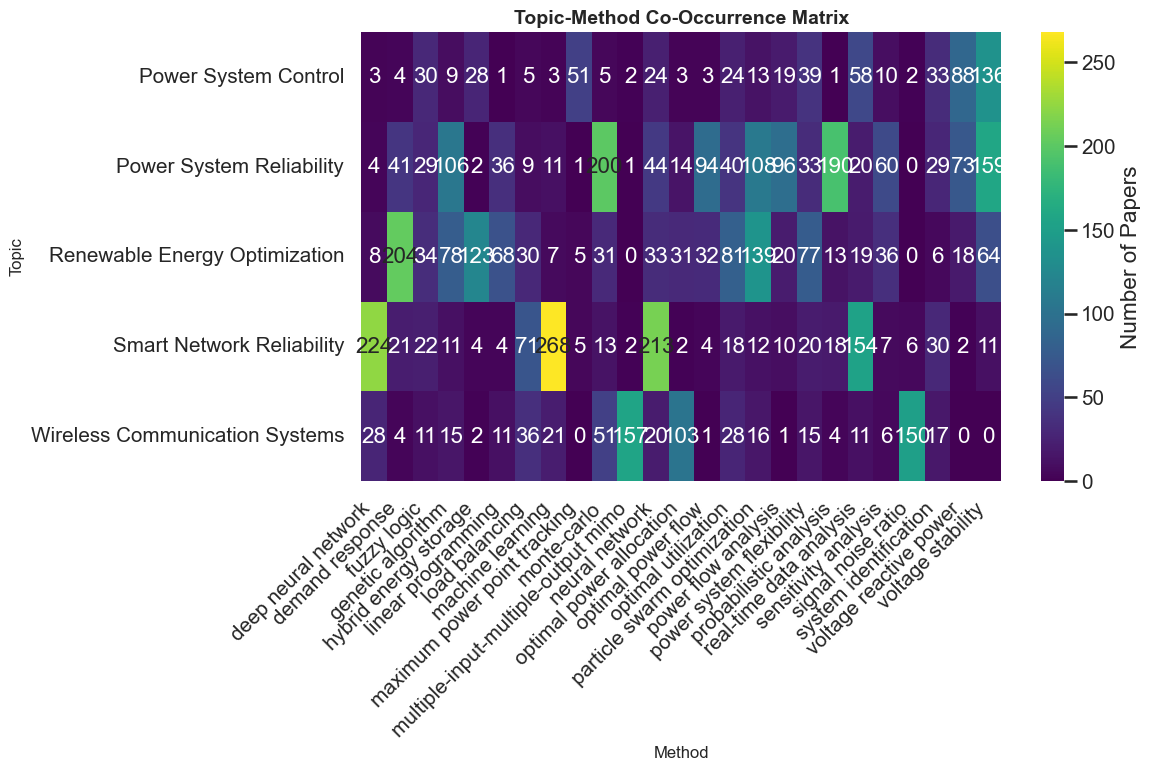

In [98]:
# %%
# Cell 23: Basic Topic-Method Heatmap
if data:
    plot_topic_method_heatmap(df, top_n_methods=25, top_n_topics=5)


In [99]:
# %%
# Cell 24: Advanced Weighted Heatmap
if data:
    pivot = plot_weighted_topic_method_heatmap(
        df, n_top=5, topics=[3,7,9], topic_names=topic_names,
        start_year=2000, end_year=2022, min_papers_per_year=5,
        plot_top_methods=8, plot_top_topics=8
    )

print("\n🎉 Visualization complete! All plots have been generated.")


📊 Creating heatmap from 4972 papers

🎉 Visualization complete! All plots have been generated.


## Prepare for comparison with method implementation

In [100]:
# Export dual trend results
# Step 1: Calculate background publication growth

overall_growth_rate, yearly_totals, r_value= calculate_publication_inflation_correction(df)
df_lit_export = export_ggt_results(
    results_ggt,
    overall_growth_rate,
    dataset_rsquared,
    out_csv="Saved_files_new/ggt_results_dual.csv",
    yearly_csv="Saved_files_new/ggt_yearly_scores.csv",
    save_yearly=True
)

🔍 CALCULATING PUBLICATION INFLATION CORRECTION
Data spans from 1952 to 2025
Valid years for analysis: 59 (from 1960 to 2025)
Publication growth pattern (last 10 years):
  2016: 1278 papers
  2017: 1238 papers
  2018: 1552 papers
  2019: 1783 papers
  2020: 1875 papers
  2021: 1814 papers
  2022: 1904 papers
  2023: 2892 papers
  2024: 4535 papers
  2025: 1913 papers

📈 Overall dataset growth characteristics:
  Average papers per year: 522.6
  Annual absolute growth: 36.54 papers/year
  Annual relative growth: 0.070 (7.0%)
  R²: 0.554
💾 Saved GGT method results (dual trend): Saved_files_new/ggt_results_dual.csv
   Methods: 202
   Columns: 24
💾 Saved GGT metadata: Saved_files_new\ggt_results_dual_meta.csv
💾 Saved trajectory pattern summary: Saved_files_new\ggt_results_dual_patterns.csv
💾 Saved GGT yearly scores: Saved_files_new/ggt_yearly_scores.csv
   Total rows: 3355
   Year range: 1955 - 2024

📊 EXPORT SUMMARY:
   Lifecycle distribution:
        Emerging:  28 ( 13.9%)
         Growing

In [ ]:
def plot_ggt_trend_shifts(merged, top_k=None, sort_by='trend_change', 
                         figsize=(12, 10), save_path=None,
                         color_by='lifecycle_stage', show_labels=True,
                         y_sort='recent_growth'):  # NEW parameter
    """
    Plot showing shift from full history to recent trends with arrows.
    
    Parameters:
    - merged: DataFrame with both ggt_corrected_growth_full and _recent
    - top_k: Number of methods to show (None = all)
    - sort_by: 'trend_change' (biggest shifts), 'importance', 'MIS', 'recent_growth'
               This determines WHICH methods to show
    - y_sort: How to sort methods on y-axis ('recent_growth', 'MIS', 'importance', 'trend_change', None)
              None = keep the order from sort_by
    - color_by: 'lifecycle_stage', 'trajectory_pattern', or None
    - show_labels: If True, label method names
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.patches import FancyArrowPatch
    
    # Check required columns
    required = ['ggt_corrected_growth_full', 'ggt_corrected_growth_recent']
    if not all(col in merged.columns for col in required):
        raise ValueError(f"merged must contain columns: {required}")
    
    df = merged.copy()
    
    # Handle None for top_k
    if top_k is None:
        top_km = len(df)
    else: 
        top_km = top_k
    
    # Calculate trend change if not present
    if 'trend_change' not in df.columns:
        df['trend_change'] = df['ggt_corrected_growth_recent'] - df['ggt_corrected_growth_full']
    
    # Select which methods to show (based on sort_by)
    if sort_by == 'trend_change':
        df['abs_change'] = df['trend_change'].abs()
        df_plot = df.nlargest(top_km, 'abs_change')
    elif sort_by == 'importance':
        df_plot = df.nlargest(top_km, 'total_importance')
    elif sort_by == 'MIS':
        df_plot = df.nlargest(top_km, 'MIS')
    elif sort_by == 'recent_growth':
        df_plot = df.nlargest(top_km, 'ggt_corrected_growth_recent')
    else:
        df_plot = df.head(top_km)
    
    # Sort for y-axis display (FIXED - now conditional)
    if y_sort == 'recent_growth':
        df_plot = df_plot.sort_values('ggt_corrected_growth_recent', ascending=True)
    elif y_sort == 'MIS':
        df_plot = df_plot.sort_values('MIS', ascending=True)
    elif y_sort == 'importance':
        df_plot = df_plot.sort_values('total_importance', ascending=True)
    elif y_sort == 'trend_change':
        df_plot = df_plot.sort_values('trend_change', ascending=True)
    # elif y_sort is None: keep original order from sort_by
    
    # Setup colors
    if color_by == 'lifecycle_stage' and 'lifecycle_stage' in df_plot.columns:
        color_map = {
            'Emerging': '#1f77b4',
            'Growing': '#2ca02c',
            'Mature': '#9467bd',
            'Declining': '#d62728'
        }
        colors = [color_map.get(stage, '#7f7f7f') for stage in df_plot['lifecycle_stage']]
    elif color_by == 'trajectory_pattern' and 'trajectory_pattern' in df_plot.columns:
        color_map = {
            'resurgent': '#2ca02c',
            'die_hard': '#d62728',
            'consistent_growth': '#1f77b4',
            'consistent_decline': '#ff7f0e',
            'emerging': '#9467bd',
            'consistent_stable': '#8c564b',
            'mixed': '#7f7f7f'
        }
        colors = [color_map.get(pattern, '#7f7f7f') for pattern in df_plot['trajectory_pattern']]
    else:
        colors = ['#4C78A8'] * len(df_plot)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    y_positions = np.arange(len(df_plot))
    
    # Plot each method
    for i, (idx, row) in enumerate(df_plot.iterrows()):
        y = y_positions[i]
        x_full = row['ggt_corrected_growth_full']
        x_recent = row['ggt_corrected_growth_recent']
        color = colors[i]
        
        # Plot full history point (opaque)
        ax.scatter(x_full, y, s=100, c=color, alpha=1.0, 
                  edgecolors='black', linewidth=1.5, zorder=3, marker='o')
        
        # Plot recent trend point (transparent/hollow)
        ax.scatter(x_recent, y, s=100, c='none', 
                  edgecolors=color, linewidth=2.5, zorder=4, marker='o')
        
        # Draw arrow from full to recent
        if abs(x_recent - x_full) > 0.001:
            arrow = FancyArrowPatch(
                (x_full, y), (x_recent, y),
                arrowstyle='->', mutation_scale=20,
                color=color, alpha=0.6, linewidth=2,
                zorder=2
            )
            ax.add_patch(arrow)
    
    # Add method labels
    if show_labels:
        label_col = 'method' if 'method' in df_plot.columns else 'method_norm'
        for i, (idx, row) in enumerate(df_plot.iterrows()):
            label = row[label_col]
            x_pos = row['ggt_corrected_growth_recent']
            offset = 0.01 if row['trend_change'] >= 0 else -0.01
            ha = 'left' if row['trend_change'] >= 0 else 'right'
            
            ax.text(x_pos + offset, y_positions[i], label,
                   fontsize=9, ha=ha, va='center')
    
    # Add vertical line at zero
    ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
    
    # Formatting
    if top_k is None:
        method_filter_string = f'All methods by {sort_by.replace("_", " ")}' 
    else: 
        method_filter_string = f'Top {top_km} methods by {sort_by.replace("_", " ")}'
    
    y_sort_string = f' (y-axis sorted by {y_sort.replace("_", " ")})' if y_sort else ''
    
    ax.set_xlabel('GGT-corrected Growth Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Methods{y_sort_string}', fontsize=12, fontweight='bold')
    ax.set_title(f'Technology Trajectory Shifts: Full History → Recent Trends\n{method_filter_string}',
                fontsize=14, fontweight='bold', pad=20)
    
    ax.set_yticks([])
    ax.grid(True, axis='x', alpha=0.3)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Create legend
    legend_elements = [
        mpatches.Patch(facecolor='gray', edgecolor='black', label='Full History (opaque)'),
        mpatches.Patch(facecolor='none', edgecolor='gray', linewidth=2, label='Recent Trend (hollow)'),
        mpatches.FancyArrowPatch((0, 0), (0.1, 0), arrowstyle='->', 
                                mutation_scale=20, color='gray', label='Trend shift')
    ]
    
    # Add color legend
    if color_by == 'lifecycle_stage':
        legend_elements.append(mpatches.Patch(color='white', label=''))
        legend_elements.append(mpatches.Patch(color='white', label='Lifecycle Stage:'))
        for stage, color in [('Emerging', '#1f77b4'), ('Growing', '#2ca02c'), 
                            ('Mature', '#9467bd'), ('Declining', '#d62728')]:
            legend_elements.append(mpatches.Patch(color=color, label=f'  {stage}'))
    elif color_by == 'trajectory_pattern':
        legend_elements.append(mpatches.Patch(color='white', label=''))
        legend_elements.append(mpatches.Patch(color='white', label='Trajectory:'))
        for pattern, color in [('Resurgent', '#2ca02c'), ('Die-hard', '#d62728'),
                              ('Consistent growth', '#1f77b4')]:
            legend_elements.append(mpatches.Patch(color=color, label=f'  {pattern}'))
    
    ax.legend(handles=legend_elements, loc='best', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        from pathlib import Path
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {save_path}")
    
    plt.show()
    
    # Print summary
    print(f"\n📊 TRAJECTORY SHIFT SUMMARY:")
    print(f"Methods shown: {len(df_plot)}")
    print(f"Selected by: {sort_by}")
    print(f"Y-axis sorted by: {y_sort if y_sort else 'selection order'}")
    
    print(f"\nBiggest accelerations (positive shifts):")
    top_accel = df_plot.nlargest(min(3, len(df_plot)), 'trend_change')
    for _, row in top_accel.iterrows():
        method = row['method'] if 'method' in row else row['method_norm']
        print(f"  {method}: {row['ggt_corrected_growth_full']:.3f} → "
              f"{row['ggt_corrected_growth_recent']:.3f} (Δ{row['trend_change']:+.3f})")
    
    print(f"\nBiggest decelerations (negative shifts):")
    top_decel = df_plot.nsmallest(min(3, len(df_plot)), 'trend_change')
    for _, row in top_decel.iterrows():
        method = row['method'] if 'method' in row else row['method_norm']
        print(f"  {method}: {row['ggt_corrected_growth_full']:.3f} → "
              f"{row['ggt_corrected_growth_recent']:.3f} (Δ{row['trend_change']:+.3f})")
    
    return df_plot


def plot_ggt_trend_shifts_horizontal(merged, top_k=30, sort_by='trend_change',
                                    figsize=(14, 12), save_path=None,
                                    color_by='trajectory_pattern'):
    """
    Horizontal version - better for more methods.
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyArrowPatch
    
    df = merged.copy()
    
    # Calculate trend change
    if 'trend_change' not in df.columns:
        df['trend_change'] = df['ggt_corrected_growth_recent'] - df['ggt_corrected_growth_full']
    
    # Select and sort
    if sort_by == 'trend_change':
        df['abs_change'] = df['trend_change'].abs()
        df_plot = df.nlargest(top_k, 'abs_change')
        df_plot = df_plot.sort_values('trend_change', ascending=False)  # Most positive at top
    else:
        df_plot = df.nlargest(top_k, sort_by).sort_values('trend_change', ascending=False)
    
    # Colors
    if color_by == 'trajectory_pattern' and 'trajectory_pattern' in df_plot.columns:
        color_map = {
            'resurgent': '#2ca02c', 'die_hard': '#d62728',
            'consistent_growth': '#1f77b4', 'consistent_decline': '#ff7f0e',
            'emerging': '#9467bd', 'consistent_stable': '#8c564b', 'mixed': '#7f7f7f'
        }
        colors = [color_map.get(p, '#7f7f7f') for p in df_plot['trajectory_pattern']]
    else:
        colors = ['#4C78A8'] * len(df_plot)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    y_positions = np.arange(len(df_plot))
    
    for i, (idx, row) in enumerate(df_plot.iterrows()):
        y = y_positions[i]
        x_full = row['ggt_corrected_growth_full']
        x_recent = row['ggt_corrected_growth_recent']
        color = colors[i]
        
        # Full (filled)
        ax.scatter(x_full, y, s=120, c=color, alpha=1.0, 
                  edgecolors='black', linewidth=1.5, zorder=3)
        
        # Recent (hollow)
        ax.scatter(x_recent, y, s=120, c='none',
                  edgecolors=color, linewidth=2.5, zorder=4)
        
        # Arrow
        if abs(x_recent - x_full) > 0.002:
            arrow = FancyArrowPatch(
                (x_full, y), (x_recent, y),
                arrowstyle='->', mutation_scale=15,
                color=color, alpha=0.7, linewidth=2, zorder=2
            )
            ax.add_patch(arrow)
    
    # Y-axis labels with method names
    label_col = 'method' if 'method' in df_plot.columns else 'method_norm'
    ax.set_yticks(y_positions)
    ax.set_yticklabels([row[label_col] for _, row in df_plot.iterrows()], fontsize=9)
    
    ax.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, zorder=1)
    
    ax.set_xlabel('GGT-corrected Growth Rate', fontsize=12, fontweight='bold')
    ax.set_title(f'Technology Trajectory Shifts: Full History → Recent (10yr)\n'
                f'Top {top_k} by {sort_by.replace("_", " ")} | '
                f'Filled=Full, Hollow=Recent',
                fontsize=13, fontweight='bold', pad=15)
    
    ax.grid(True, axis='x', alpha=0.3, linestyle=':')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Add annotation box
    stats_text = (f"Accelerating: {(df_plot['trend_change'] > 0.05).sum()}\n"
                 f"Stable: {(df_plot['trend_change'].abs() <= 0.05).sum()}\n"
                 f"Decelerating: {(df_plot['trend_change'] < -0.05).sum()}")
    
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        from pathlib import Path
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {save_path}")
    
    plt.show()
    
    return df_plot



In [ ]:
# Load data with both trends


# Vertical version - best for top 20
plot_ggt_trend_shifts(
    merged,
    #top_k=200,
    sort_by='trend_change',  # Show biggest shifts
    #y_sort='importance',
    figsize=(15,25),
    color_by='lifecycle_stage',
    save_path='output/trend_shifts.pdf'
)

# Horizontal version - better for more methods
#plot_ggt_trend_shifts_horizontal(
#    merged,
#    top_k=50,
#    sort_by='trend_change',
#    color_by='trajectory_pattern',
#    save_path='output/trend_shifts_horizontal.pdf'
#)

# Show most important methods and their shifts
#plot_ggt_trend_shifts(
#    merged,
#    top_k=200,
#    figsize=(20,30),
#    sort_by='importance',  # Most important methods
#    color_by='lifecycle_stage',
#    save_path='output/important_methods_shifts.pdf'
#)


# Here the comparison starts

In [130]:
# reload the results
df_methods, metadata, df_yearly = load_ggt_results(
    csv_path="Saved_files_new/ggt_results_dual.csv",
    yearly_csv="Saved_files_new/ggt_yearly_scores.csv"
)

print(f"Loaded {metadata['n_methods']} methods")
print(f"Resurgent methods: {metadata['n_resurgent']}")

📂 Loaded GGT results: Saved_files_new/ggt_results_dual.csv
   Methods: 202
📂 Loaded metadata: Saved_files_new\ggt_results_dual_meta.csv
📂 Loaded yearly scores: Saved_files_new/ggt_yearly_scores.csv
   Rows: 3355
Loaded 202.0 methods
Resurgent methods: 0.0


### Extracting and visualizing software frequencies 

## Method Implemetation scores

Loaded matrix shape (with MIS): (39, 210)
Software rows (excluding MIS): 37
Method columns detected: 189
First 10 methods: ['power flow analysis', 'security-constrained optimal power flow', 'security constrained unit commitment', 'Non Linear Optimal Power Flow', 'Multi-Period  Optimisation', 'unit commitment', 'genetic algorithm', 'neural network', 'kalman filter', 'monte-carlo']
MIS non-null count: 189


In [135]:
print(df_mis.columns.all)

<bound method Index.all of Index(['Include?', 'Vendor', 'Type', 'Coverage', 'Type of modelling',
       'OSMM Score', 'OSMM - product maturity',
       'OSMM - product maturity - API (+1)',
       'OSMM - product maturity - Implementeringseksempel(+1)',
       'OSMM - product maturity - Get started (+2)',
       ...
       'energy consumption modeling', 'state-space modeling',
       'quadrature pase shift keying', 'multi-fidelity model',
       'stochastic geometry', 'quadrature amplitude modulation',
       'orthogonal frequency-division multiplexing', 'minimum mean square',
       'adaptive modulation', 'error rate ber performance'],
      dtype='object', length=210)>


In [ ]:
""" previous version without dual pattern
def plot_top_methods_by_MIS(mis_row, top_k=25, save_path=None):
    mis_sorted = mis_row.dropna().sort_values(ascending=False).head(top_k)
    plt.figure(figsize=(10, max(4, 0.35*len(mis_sorted))))
    sns.barplot(x=mis_sorted.values, y=mis_sorted.index, color="#4C78A8")
    plt.xlabel("Method Implementation Score (MIS)")
    plt.ylabel("Method")
    plt.title("Top methods by MIS")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"Saved: {save_path}")
    plt.show()

def pick_top_softwares(df_full_no_mis, df_full_with_mis, methods_for_heat, top_sw=12, prod_prefix="OSMM - product maturity"):
    # Prefer columns that start with the product maturity prefix
    prod_cols = [c for c in df_full_with_mis.columns if c.strip().startswith(prod_prefix)]
    if prod_cols:
        # Average of maturity columns
        sw_score = df_full_no_mis[prod_cols].mean(axis=1, skipna=True)
        sw_pick = sw_score.sort_values(ascending=False).head(top_sw).index
    else:
        # Fallback: average of the selected method ranks
        sub = df_full_no_mis[methods_for_heat]
        sw_pick = sub.mean(axis=1, skipna=True).sort_values(ascending=False).head(top_sw).index
    return sw_pick

def plot_implementation_heatmap(df_wo_mis, mis_row, top_methods=20, top_softwares=12, save_path=None):
    # Choose top methods by MIS
    heat_methods = mis_row.dropna().sort_values(ascending=False).head(top_methods).index.tolist()
    sub = df_wo_mis[heat_methods].copy()
    # Pick top softwares
    sw_pick = pick_top_softwares(df_wo_mis, df_mis, heat_methods, top_sw=top_softwares)
    heat = sub.loc[sw_pick]

    plt.figure(figsize=(1.2*len(heat.columns)+3, 0.5*len(heat.index)+2))
    sns.heatmap(heat, cmap="YlGnBu", annot=False, cbar_kws={"label": "Implementation rank (0–3)"})
    plt.title("Implementation rank heatmap (top softwares × top MIS methods)")
    plt.xlabel("Method")
    plt.ylabel("Software")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"Saved: {save_path}")
    plt.show()

def merge_mis_with_ggt(mis_row, ggt_csv_path, sep=";", decimal=","):
    # Build MIS table
    mis_df = pd.DataFrame({"method": mis_row.index, "MIS": mis_row.values}).dropna(subset=["MIS"]).copy()
    mis_df["method_norm"] = mis_df["method"].astype(str).str.strip().str.casefold()

    # Load GGT results
    ggt = pd.read_csv(ggt_csv_path, sep=",", decimal=".", encoding="utf-8-sig")
    cols_lower = {c.lower(): c for c in ggt.columns}

    assert "method" in cols_lower, "GGT file must contain a 'method' column"
    ggt["method_norm"] = ggt[cols_lower["method"]].astype(str).str.strip().str.casefold()

    # Pick columns to keep (case-insensitive)
    def pick_ci(df, name):
        m = [c for c in df.columns if c.lower() == name]
        return m[0] if m else None

    keep = ["method_norm"]
    for key in ["ggt_corrected_growth", "total_importance", "lifecycle_stage"]:
        col = pick_ci(ggt, key)
        if col: keep.append(col)

    ggt_tidy = ggt[keep].copy()
    merged = mis_df.merge(ggt_tidy, on="method_norm", how="inner")

    # Clip extremes for readability only
    for col in ["MIS", "ggt_corrected_growth", "total_importance"]:
        if col in merged.columns and merged[col].notna().sum() > 0:
            lo, hi = np.percentile(merged[col].dropna(), [1, 99])
            if np.isfinite(lo) and np.isfinite(hi):
                merged[col] = merged[col].clip(lo, hi)

    return merged

def scatter_mis_vs_ggt_and_importance(
    merged,
    save_prefix=None,
    color_by="lifecycle_stage",
    figsize=(16, 10),             # larger figure by default
    s=70,                         # point size
    alpha=0.9,
    linewidth=0.3,
    top_label_n=20,               # keep if you still want top-MIS labels
    label_high_growth=True,       # turn on high-GGT labeling
    ggt_threshold=None,           # absolute threshold, e.g. 0.05; if None use quantile
    ggt_quantile=0.90,            # label top 10% by GGT if threshold is None
    max_growth_labels=20          # cap number of GGT labels
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    df = merged.copy()
    label_col = "method" if "method" in df.columns else ("method_norm" if "method_norm" in df.columns else None)
    if label_col is None:
        # create a fallback label column
        df["method_fallback"] = np.arange(len(df))
        label_col = "method_fallback"

    hue = color_by if color_by in df.columns else None
    pal = {'Emerging':'#1f77b4','Growing':'#2ca02c','Mature':'#9467bd','Declining':'#d62728'} if hue else None

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # --------------------- Panel 1: MIS vs GGT ---------------------
    ax = axes[0]
    if "ggt_corrected_growth" in df.columns:
        sns.scatterplot(
            data=df, x="ggt_corrected_growth", y="MIS", hue=hue, palette=pal,
            s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
        )
        ax.axvline(0, color="gray", ls="--", lw=1)
        ax.set_xlabel("GGT-corrected growth")
        ax.set_ylabel("Method Implementation Score (MIS)")
        ax.set_title("MIS vs GGT")
        ax.grid(True, alpha=0.25)

        # (A) Label top-N by MIS (optional, keep your previous behavior)
        if top_label_n and top_label_n > 0:
            lab = df.nlargest(top_label_n, "MIS")
            for _, r in lab.iterrows():
                ax.text(r["ggt_corrected_growth"], r["MIS"], r[label_col],
                        fontsize=9, ha="left", va="bottom")

        # (B) Label high-GGT methods (new)
        if label_high_growth:
            if ggt_threshold is None:
                thr = df["ggt_corrected_growth"].quantile(ggt_quantile)
            else:
                thr = float(ggt_threshold)
            hi = (df[df["ggt_corrected_growth"] >= thr]
                    .sort_values("ggt_corrected_growth", ascending=False)
                    .head(max_growth_labels))
            texts = []
            for _, r in hi.iterrows():
                texts.append(ax.text(r["ggt_corrected_growth"], r["MIS"], r[label_col],
                                     fontsize=9, ha="left", va="bottom", weight="bold"))
            # If adjustText is available, de-overlap labels a bit
            try:
                from adjustText import adjust_text
                if texts:
                    adjust_text(texts, ax=ax,
                                arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, alpha=0.7))
            except Exception:
                pass
    else:
        ax.text(0.5, 0.5, "No GGT column found", transform=ax.transAxes, ha="center")
        ax.set_axis_off()

    # ----------------- Panel 2: MIS vs Importance ------------------
    ax = axes[1]
    if "total_importance" in df.columns:
        sns.scatterplot(
            data=df, x="total_importance", y="MIS", hue=hue, palette=pal,
            s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
        )
        ax.set_xlabel("Total importance (literature)")
        ax.set_title("MIS vs Importance")
        ax.grid(True, alpha=0.25)
        # Optional: if skewed
        # ax.set_xscale("log")
    else:
        ax.text(0.5, 0.5, "No importance column found", transform=ax.transAxes, ha="center")
        ax.set_axis_off()

    # One legend on the right
    if hue:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.01, 0.5))
            for a in axes:
                leg = a.get_legend()
                if leg: leg.remove()

    plt.tight_layout()
    if save_prefix:
        import os
        from pathlib import Path
        Path(save_prefix).parent.mkdir(parents=True, exist_ok=True)
        out = Path(save_prefix).with_name(Path(save_prefix).stem + "_MIS_vs_GGT.pdf")
        fig.savefig(out, dpi=300, bbox_inches="tight")
        print(f"Saved: {out}")
    plt.show()

def scatter_mis_vs_ggt_and_importance_group(
    merged,
    save_prefix=None,
    color_by="lifecycle_stage",   # or "category" after you attach it
    figsize=(18, 11),             # bigger figure
    s=70, alpha=0.9, linewidth=0.3,
    # Optional MIS labels (kept from before)
    top_label_n=0,                # set >0 if you still want top-MIS labels
    # New: label high-GGT methods (left panel)
    label_high_growth=True,
    ggt_threshold=None,           # e.g. 0.05 for absolute; if None → quantile
    ggt_quantile=0.90,            # top 10% by GGT if no threshold
    max_growth_labels=20,
    # New: label high-Importance methods (right panel)
    label_high_importance=True,
    imp_threshold=None,           # absolute; if None → quantile
    imp_quantile=0.90,            # top 10% by importance if no threshold
    max_importance_labels=20,
    include_categories=None, exclude_categories=None,  # NEW
    category_col="category"                            # NEW
):
    df = merged.copy()
    # NEW: internal filtering
    if include_categories or exclude_categories:
        df = filter_by_categories(df, include_categories, exclude_categories, category_col=category_col)

    label_col = "method" if "method" in df.columns else ("method_norm" if "method_norm" in df.columns else None)
    if label_col is None:
        df["method_label"] = np.arange(len(df))
        label_col = "method_label"

    hue = color_by if color_by in df.columns else None
    pal = {'Emerging':'#1f77b4','Growing':'#2ca02c','Mature':'#9467bd','Declining':'#d62728'} if (hue == "lifecycle_stage") else None

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # ------------- Panel 1: MIS vs GGT -------------
    ax = axes[0]
    if "ggt_corrected_growth" in df.columns:
        sns.scatterplot(
            data=df, x="ggt_corrected_growth", y="MIS", hue=hue, palette=pal,
            s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
        )
        ax.axvline(0, color="gray", ls="--", lw=1)
        ax.set_xlabel("GGT-corrected growth")
        ax.set_ylabel("Method Implementation Score (MIS)")
        ax.set_title("MIS vs GGT")
        ax.grid(True, alpha=0.25)

        # Optional: top-N by MIS (off by default)
        if top_label_n and top_label_n > 0:
            lab = df.nlargest(top_label_n, "MIS")
            for _, r in lab.iterrows():
                ax.text(r["ggt_corrected_growth"], r["MIS"], r[label_col],
                        fontsize=9, ha="left", va="bottom")

        # Label high-GGT
        if label_high_growth:
            thr = (df["ggt_corrected_growth"].quantile(ggt_quantile)
                   if ggt_threshold is None else float(ggt_threshold))
            hi = (df[df["ggt_corrected_growth"] >= thr]
                    .sort_values("ggt_corrected_growth", ascending=False)
                    .head(max_growth_labels))
            texts = []
            for _, r in hi.iterrows():
                texts.append(ax.text(r["ggt_corrected_growth"], r["MIS"], r[label_col],
                                     fontsize=9, ha="left", va="bottom", weight="bold"))
            try:
                from adjustText import adjust_text
                if texts:
                    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, alpha=0.7))
            except Exception:
                pass
    else:
        ax.text(0.5, 0.5, "No GGT column found", transform=ax.transAxes, ha="center")
        ax.set_axis_off()

    # ----------- Panel 2: MIS vs Importance ----------
    ax = axes[1]
    if "total_importance" in df.columns:
        sns.scatterplot(
            data=df, x="total_importance", y="MIS", hue=hue, palette=pal,
            s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
        )
        ax.set_xlabel("Total importance (literature)")
        ax.set_title("MIS vs Importance")
        ax.grid(True, alpha=0.25)

        # Label high-importance
        if label_high_importance:
            thr_imp = (df["total_importance"].quantile(imp_quantile)
                       if imp_threshold is None else float(imp_threshold))
            hi_imp = (df[df["total_importance"] >= thr_imp]
                        .sort_values("total_importance", ascending=False)
                        .head(max_importance_labels))
            texts = []
            for _, r in hi_imp.iterrows():
                texts.append(ax.text(r["total_importance"], r["MIS"], r[label_col],
                                     fontsize=9, ha="left", va="bottom", weight="bold"))
            try:
                from adjustText import adjust_text
                if texts:
                    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, alpha=0.7))
            except Exception:
                pass

        # Optional if skewed:
        # ax.set_xscale("log")
    else:
        ax.text(0.5, 0.5, "No importance column found", transform=ax.transAxes, ha="center")
        ax.set_axis_off()

    # One legend on the right
    if hue:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.01, 0.5))
            for a in axes:
                leg = a.get_legend()
                if leg: leg.remove()

    plt.tight_layout()
    if save_prefix:
        out1 = Path(save_prefix).with_name(Path(save_prefix).stem + "_MIS_vs_GGT.pdf")
        out2 = Path(save_prefix).with_name(Path(save_prefix).stem + "_MIS_vs_Importance.pdf")
        Path(save_prefix).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out1, dpi=300, bbox_inches="tight")  # saves combined fig; keep if you want both in one file
        print(f"Saved: {out1}")
    plt.show()

"""

In [ ]:
#new version adapted to dual pattern



### Plots to visualize trajectory change

💾 Saved: output\all_corners_labeled_MILS_recent_importance.pdf


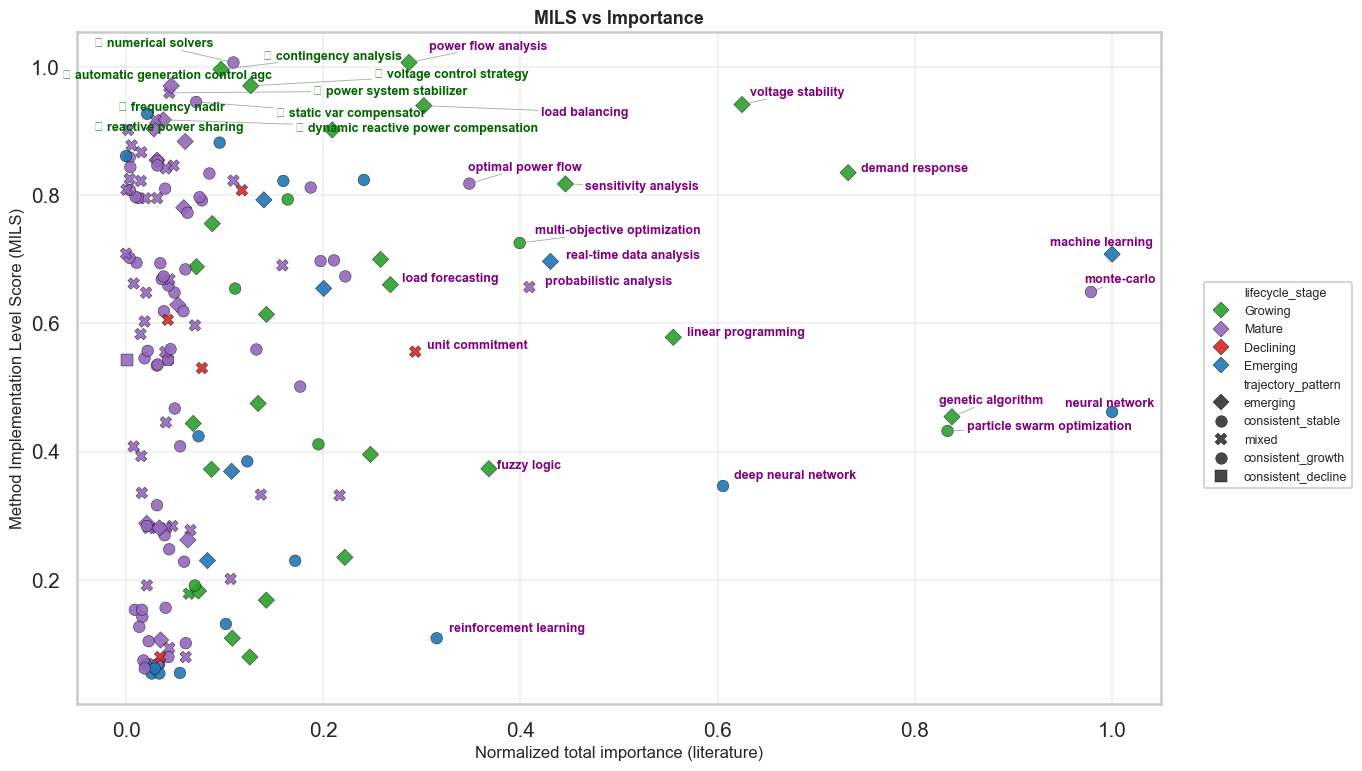

In [144]:


# Just the GGT plot with low corner labels
scatter_mis_vs_ggt_and_importance(
    merged,
    plot_mode='importance',
    # Top-right: Winners (high MIS + growing)
    label_high_growth=True,
    ggt_threshold=0.12,
    max_growth_labels=15,
    # Top (any x): High MIS
    label_high_mis=True,
    mis_threshold=0.85,
    max_mis_labels=12,
    # Top-left: Legacy (high MIS + declining)
    label_high_mis_declining=True,
    high_mis_low_ggt_threshold=-0.02,  # Declining at least 5%
    max_high_mis_declining_labels=10,
    # Bottom-left: Failing (low MIS + declining)
    label_low_corner=True,
    low_mis_threshold=0.35,
    low_ggt_threshold=-0.08,
    max_low_labels=8,
    #importance plot labels
    label_high_importance=True,
    imp_threshold=100,
    #imp_quantile=0.90,
    max_importance_labels=20,
    save_prefix='output/all_corners_labeled'
)




💾 Saved: output\importance_only_MILS_recent_importance.pdf


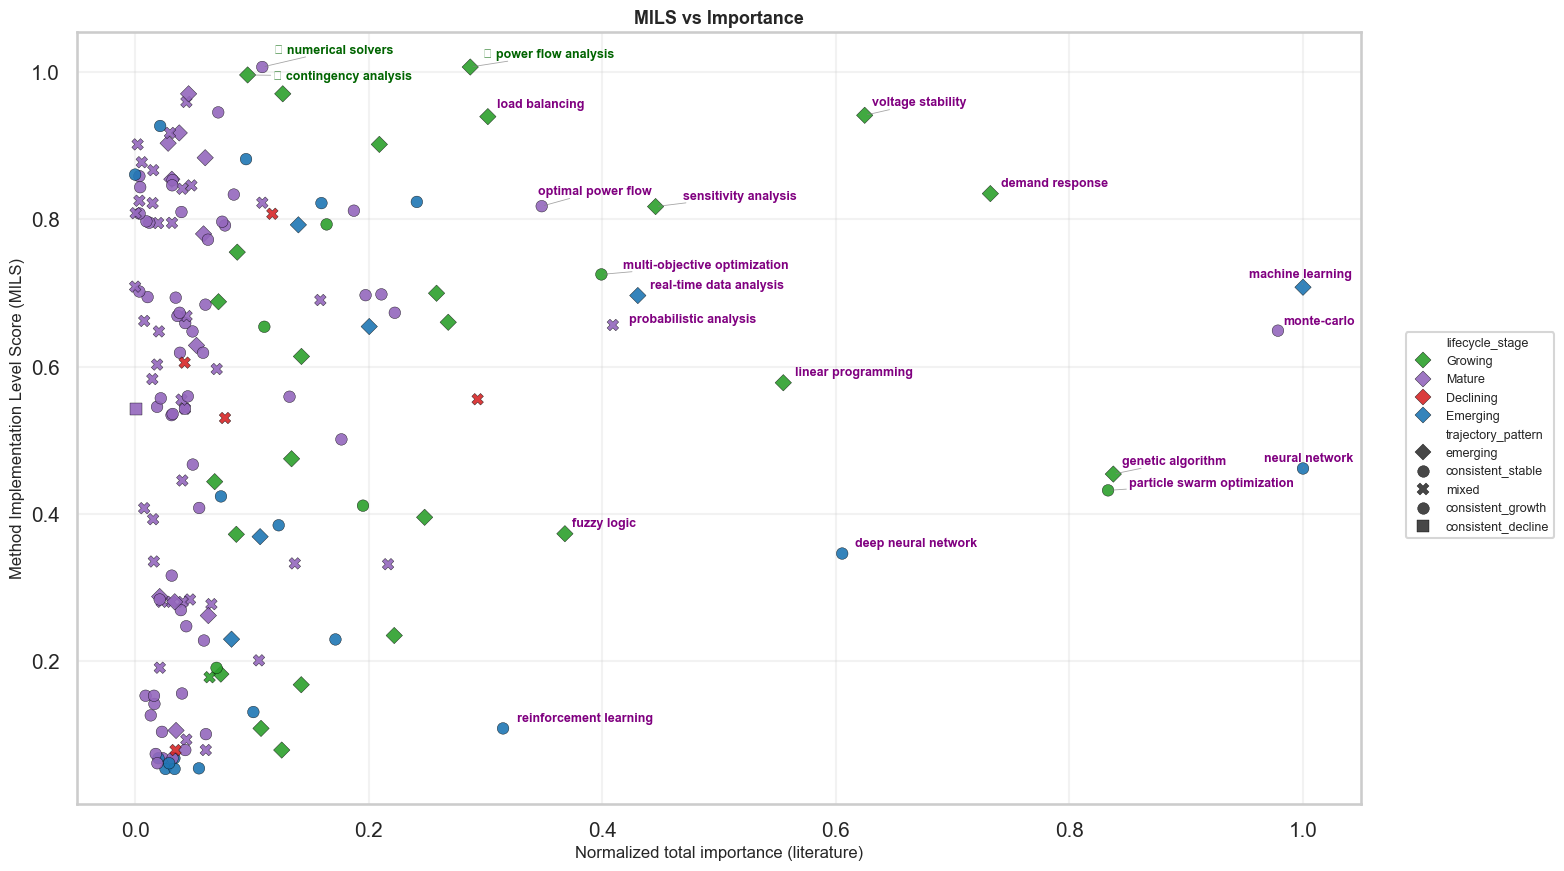

In [ ]:
# Just importance plot
scatter_mis_vs_ggt_and_importance_group(
    merged,
    plot_mode='importance',  # Only importance plot
    label_high_importance=True,
    imp_threshold=150,
    label_high_mis=True,
    mis_threshold=0.98,
    save_prefix='output/importance_only'
)



💾 Saved: output\importance_only_MILS_recent_ggt.pdf


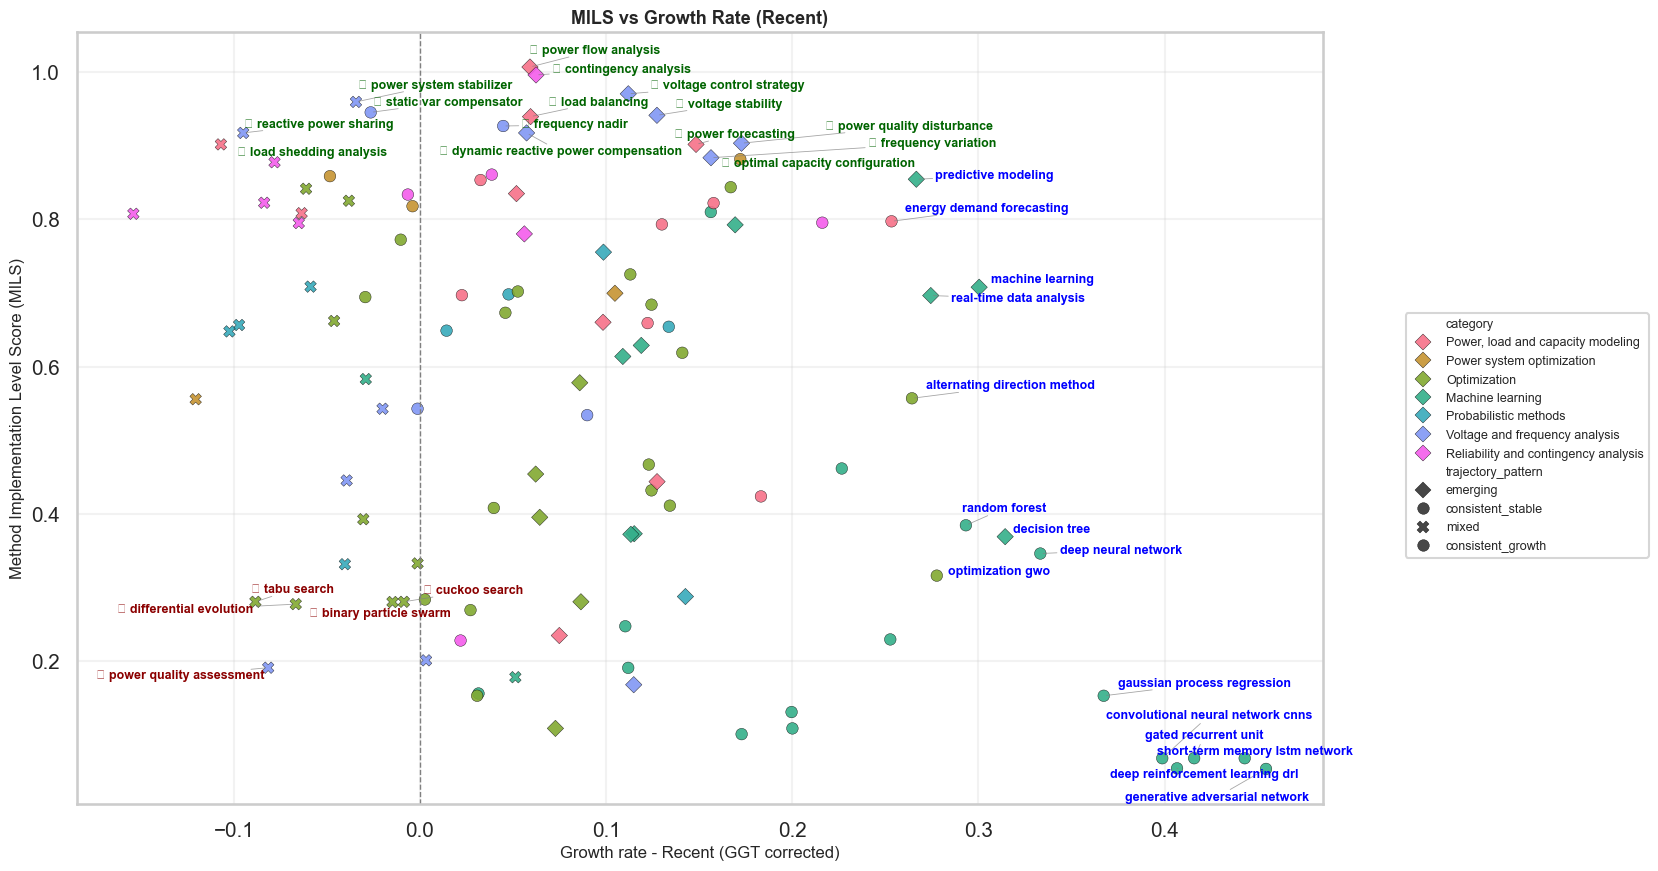

In [112]:
scatter_mis_vs_ggt_and_importance_group(
    merged,
    plot_mode='ggt',  #
    color_by='category',
    label_high_importance=True,
    imp_threshold=150,
    label_high_mis=True,
    label_low_corner=True,
    mis_threshold=0.7,
    low_mis_threshold=0.3,
    ggt_threshold=0.10,
    ggt_quantile=None,
    max_growth_labels=15,
    #
    # include_categories=['Power, load and capacity modeling', 'Power system optimization', 'Machine learning', 'Probabilistic methods'],
    exclude_categories=['Other'],
    save_prefix='output/importance_only'
)


In [ ]:

# Load data with both trends
#merged = merge_mis_with_ggt(mis_row, "ggt_results.csv", trend_type='both')

# Main plot: MIS vs GGT with trajectories
plot_mis_vs_ggt_with_trajectories(
    merged,
    top_k=200,
    sort_by='trend_change',  # Show biggest trajectory changes
    color_by='lifecycle_stage',
    figsize=(14,20),
    label_methods=True,
    label_threshold=None,  # Label all, or set threshold like 50
    save_path='output/mis_vs_ggt_trajectories.pdf'
)

# Split panel version
plot_mis_vs_ggt_trajectories_split(
    merged,
    top_k=30,
    save_path='output/mis_vs_ggt_trajectories_split.pdf'
)

# Show high-MIS methods and their trajectories
plot_mis_vs_ggt_with_trajectories(
    merged,
    
    top_k=200,
    sort_by='MIS',  # Highest implemented methods
    color_by='lifecycle_stage',
    figsize=(14,20),
    label_methods=True,
    label_threshold=None,
    #label_threshold=60,  # Only label MIS > 60
    save_path='output/high_mis_trajectories.pdf'
)


💾 Saved: Saved_files_new\scatter_MILS.pdf


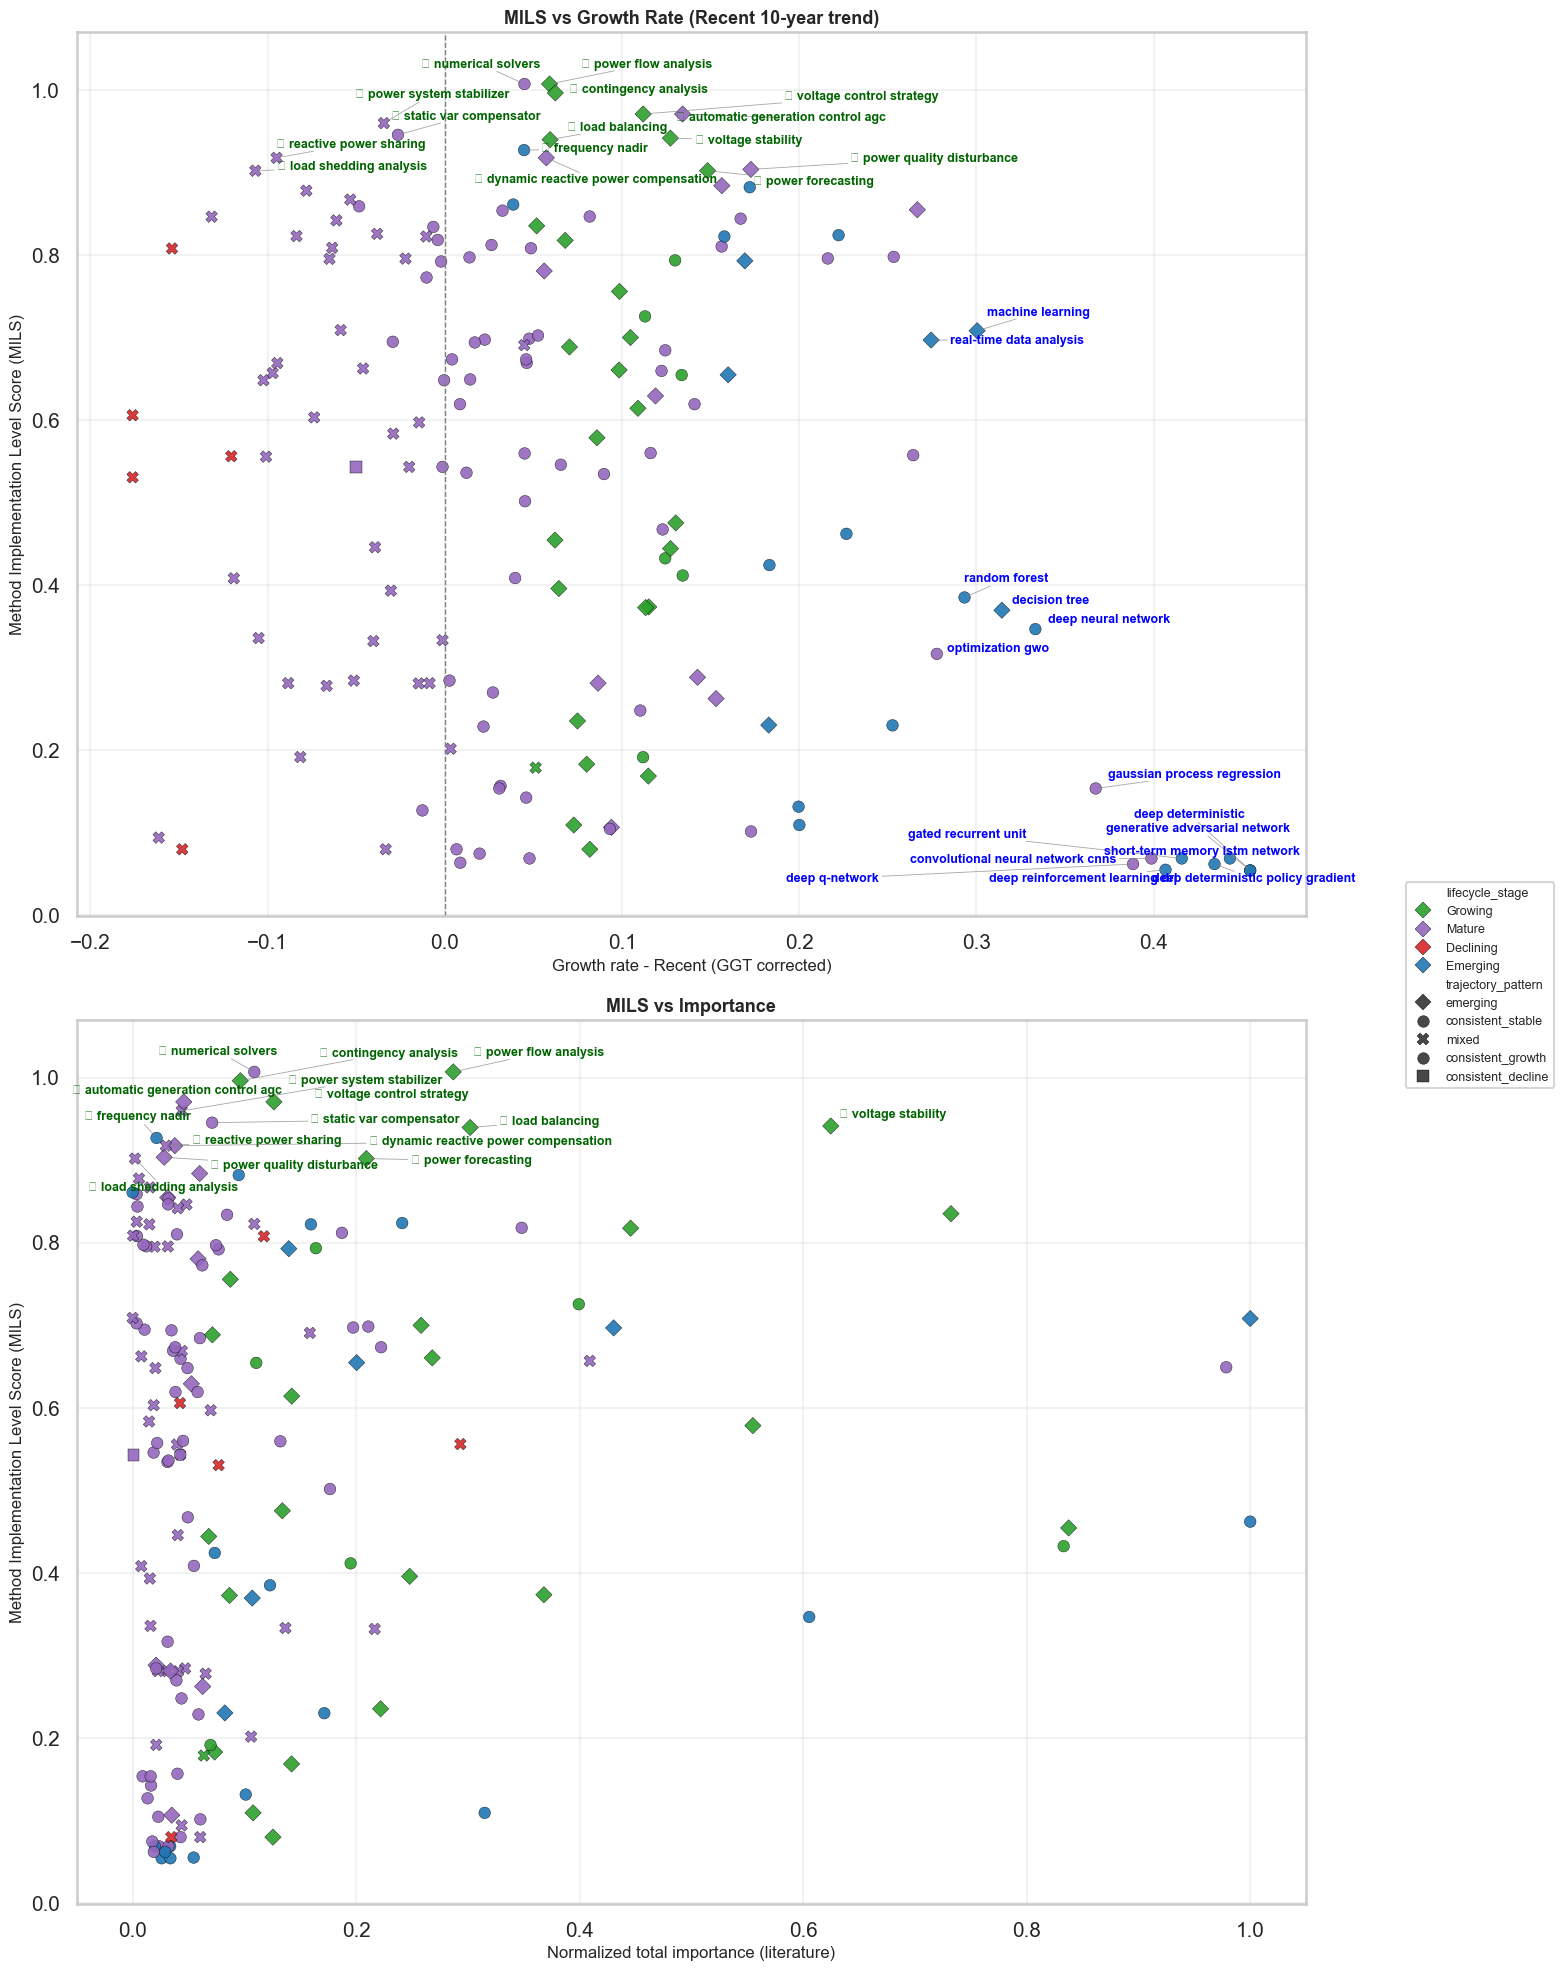


📊 CORNER ANALYSIS SUMMARY:


In [90]:
scatter_mis_vs_ggt_and_importance(
    merged,
    save_prefix=Path(SAVE_DIR, "scatter"),
    figsize=(14, 20),
    label_high_growth=True,
    ggt_threshold=0.05,    # absolute cutoff
    max_growth_labels=15
)


💾 Saved: Saved_files_new\scatter_MILS.pdf


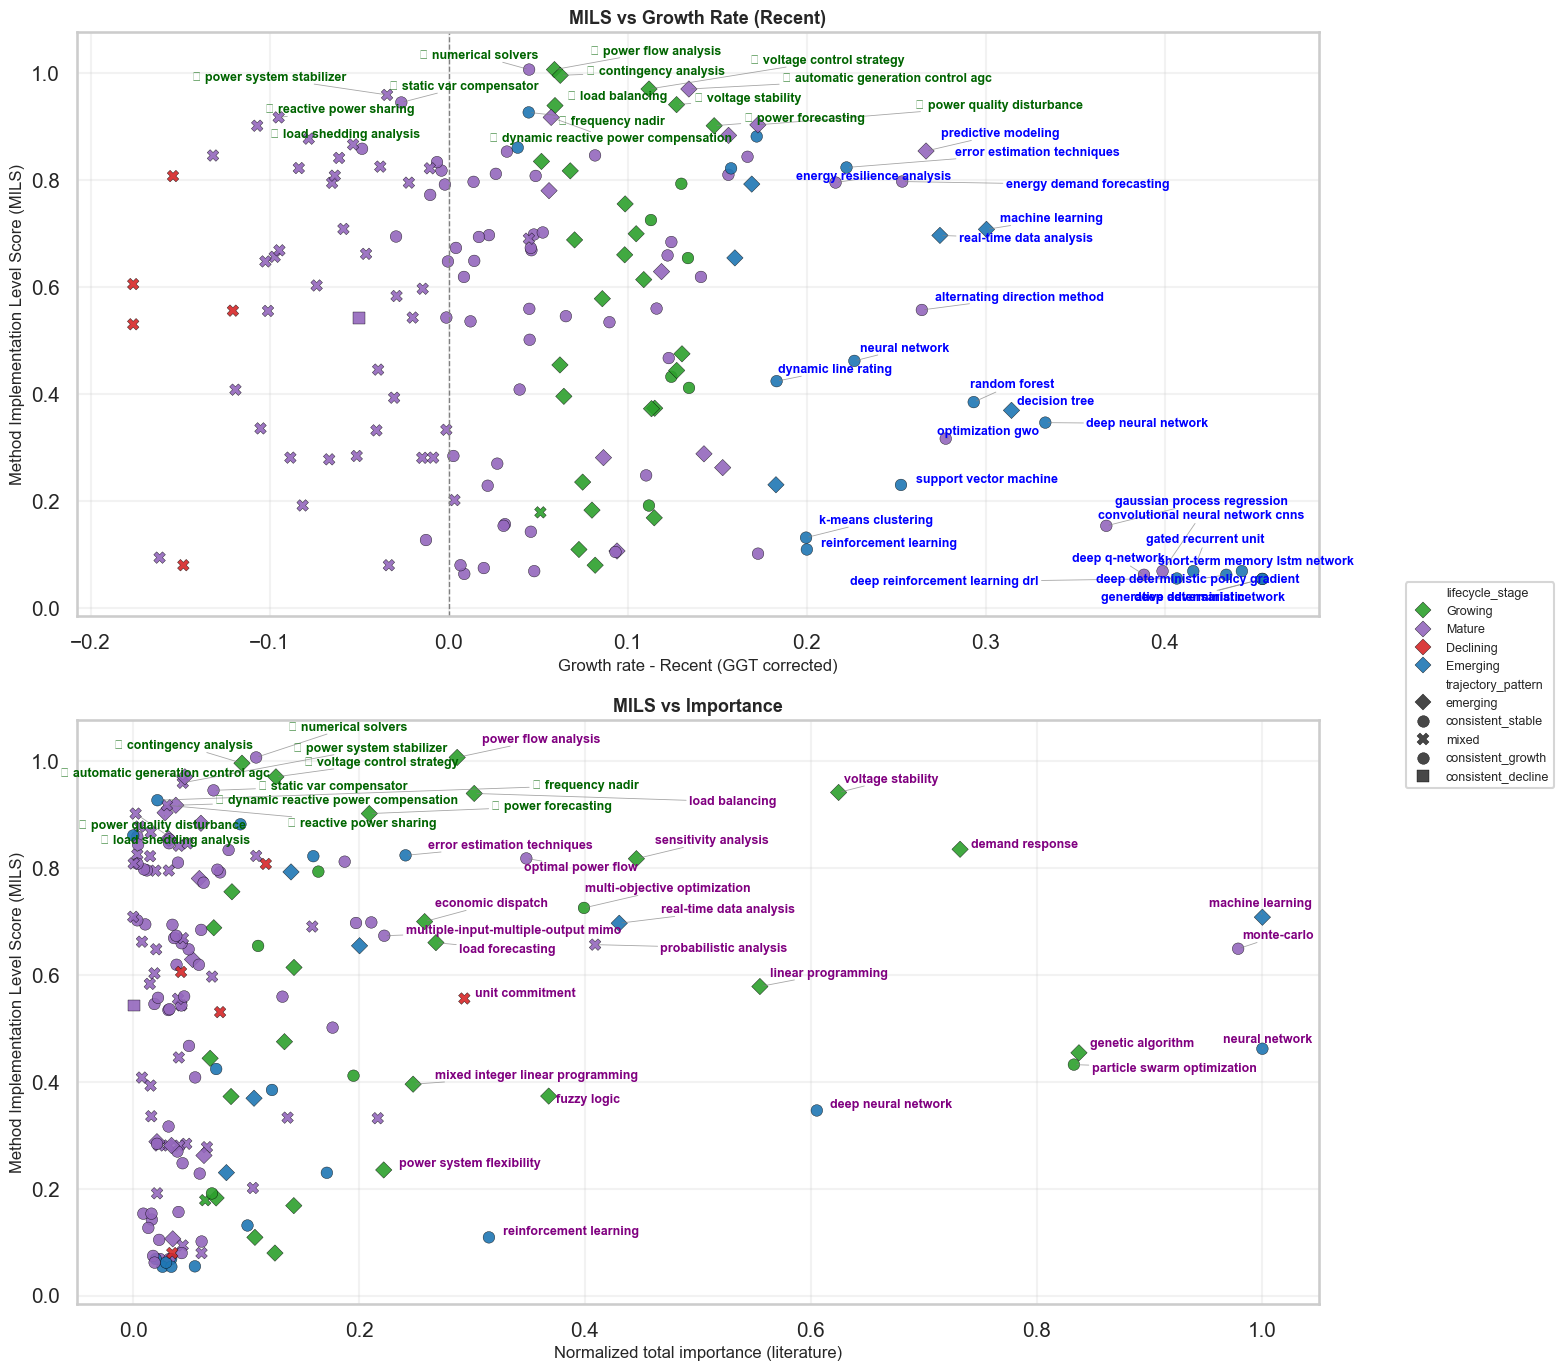

In [92]:
scatter_mis_vs_ggt_and_importance_group(
    merged,
    save_prefix=Path(SAVE_DIR, "scatter"),
    color_by="lifecycle_stage",   # or "category" after adding it
    figsize=(14, 14),
    label_high_growth=True,
    ggt_threshold=None, ggt_quantile=0.80, max_growth_labels=25,
    label_high_importance=True,
    imp_threshold=None, imp_quantile=0.80, max_importance_labels=25
)


💾 Saved: Saved_files_new\scatter_filtered_MILS.pdf


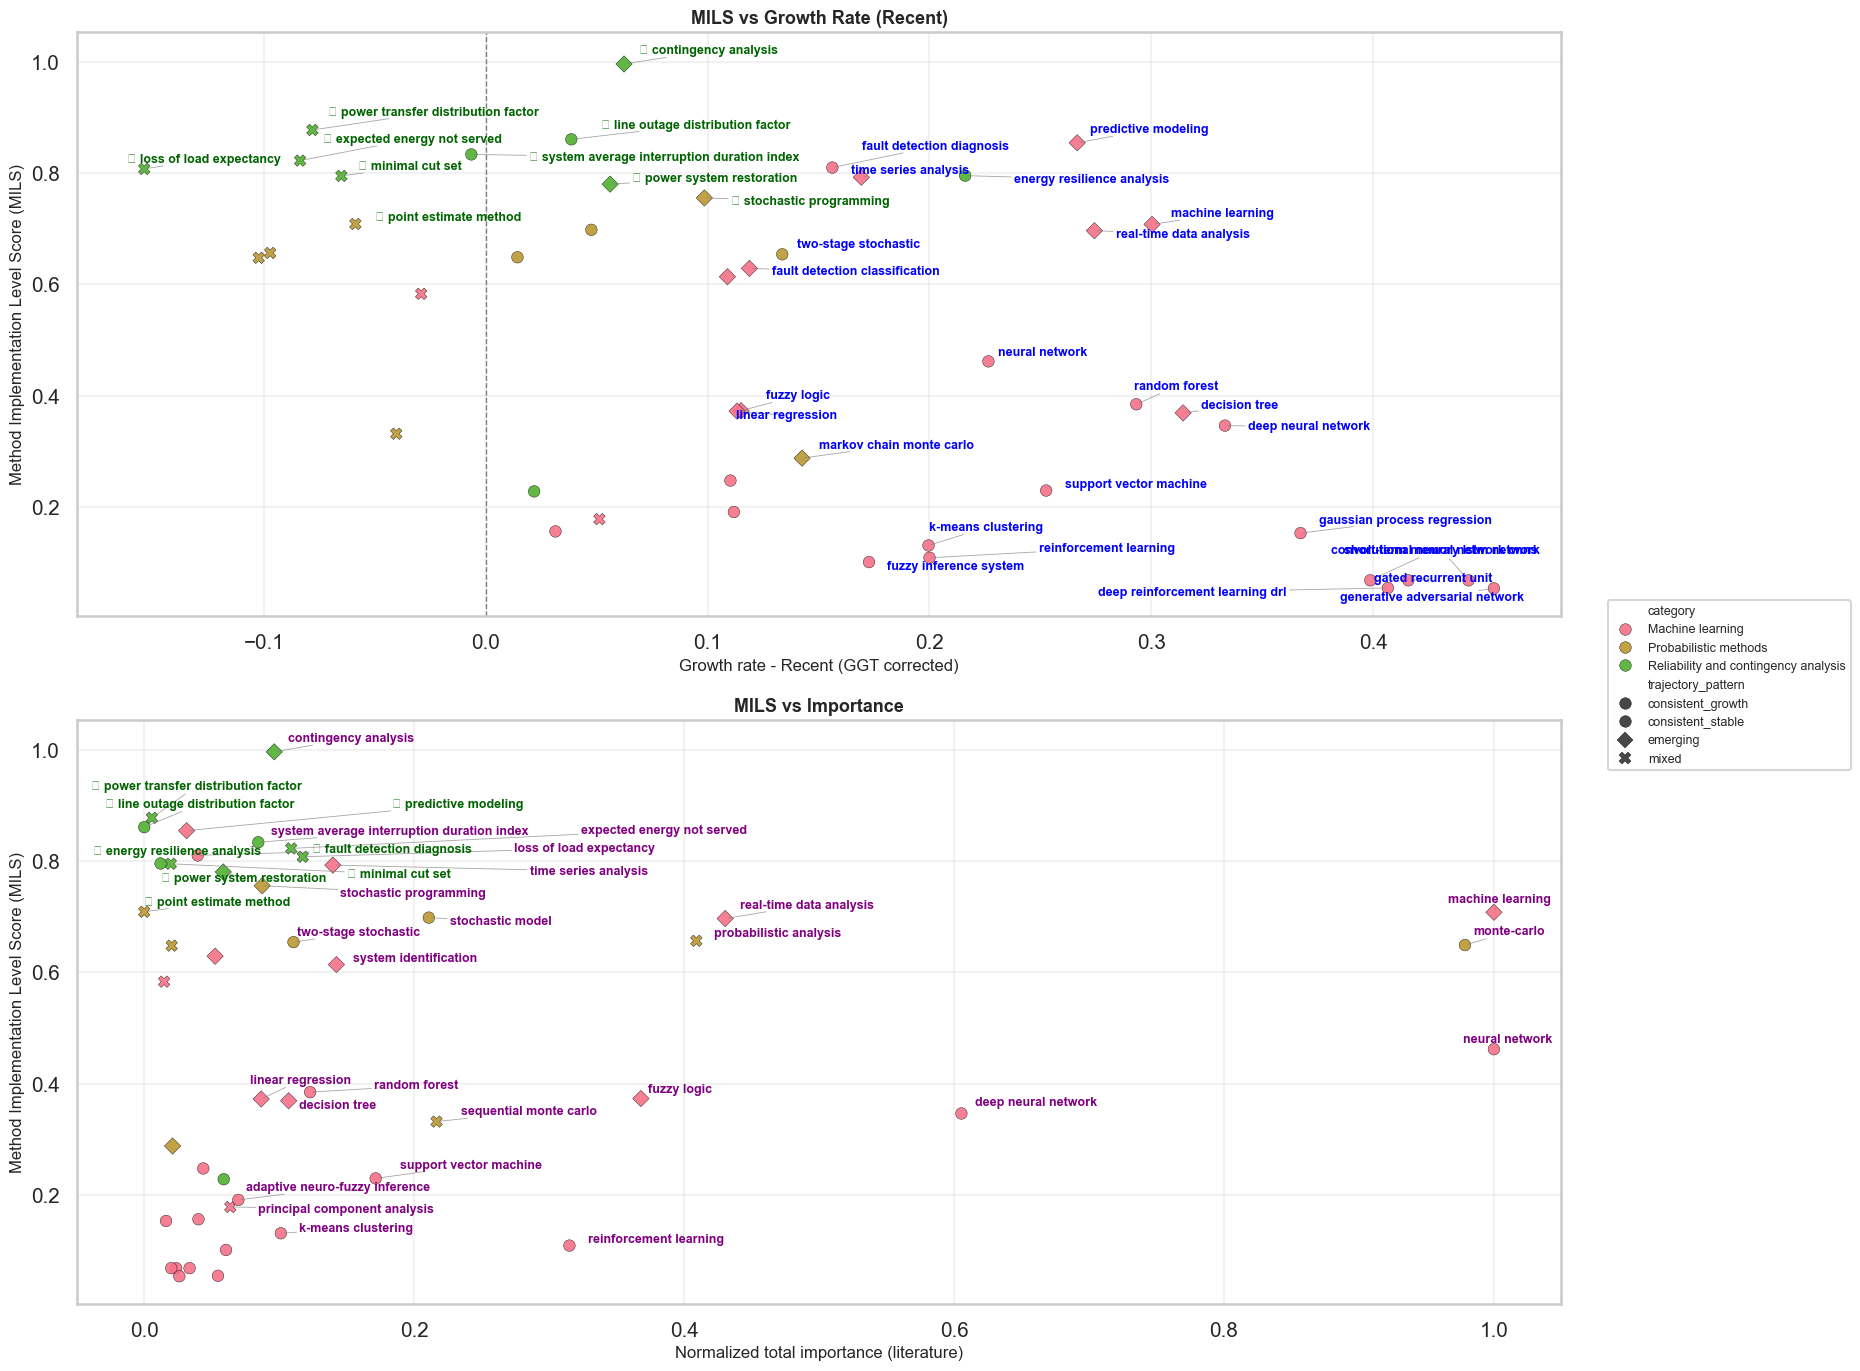

In [94]:
# Plot colored by category and with labels on both panels

scatter_mis_vs_ggt_and_importance_group(
    merged,
    save_prefix=Path(SAVE_DIR, "scatter_filtered"),
    color_by="category",
    include_categories=["Probabilistic methods","Reliability and contingency analysis","Machine learning"],#,"Machine learning"],
    exclude_categories=["Other"],  # optional
    figsize=(16, 14),
    label_high_growth=True, ggt_quantile=0, max_growth_labels=25,
    label_high_importance=True, imp_quantile=0, max_importance_labels=25
)
